In [1]:
from copy import deepcopy
import os
import sys
from datetime import datetime

In [71]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

from scipy.optimize import differential_evolution

sys.path.append(os.path.dirname(sys.path[0]))

In [4]:
import scripts.constants as con
from scripts.helpers import get_unique_frame
from scripts.plotter import Plotter, get_temperature_legend
from scripts.properties.ovito_procedures import OvitoProcessor
from scripts.rdf_calculator import RDFCalculator

In [5]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14

In [6]:
np.random.seed(0)

In [7]:
@njit
def math_round(value):
    rest = value - int(value)
    if rest >= 0.5 and value >= 0:
        return float(int(value) + 1)
    if rest <= -0.5 and value < 0:
        return float(int(value) - 1)
    return float(int(value))

@njit
def get_boundary_conditions(
        cell_dimensions: np.ndarray,
        particles_number: int,
        positions: np.ndarray,
):
    for i in range(particles_number):
        for j in range(3):
            if positions[i][j] >= cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
            if positions[i][j] < -cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
    return positions

In [8]:
def calculate_rdf(positions):
    cell_dimensions = np.array([12.25, 12.25, 12.25])
    radii, rdf = OvitoProcessor(
        positions=positions, 
        cell_dimensions=cell_dimensions,
    ).get_rdf()
    return radii, rdf

In [9]:
def mse(obs, exp):
    return np.sum((obs - exp) ** 2)

In [10]:
def generate_random_state() -> None:
    particles_number = 1372
    cell_dimensions = 12.25 * np.ones(3)
    return (np.random.random((particles_number, 3)) - 0.5) * cell_dimensions

In [11]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'hooke_jeeves_minimization'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_NORMAL)

PATH_TO_CURRENT_DATA_NORMAL

'C:\\albert\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [12]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))
cooled_1 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_1.npy'))
cooled_2 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_2.npy'))

samples.shape, test_sample.shape, targets.shape, cooled_1.shape, cooled_2.shape

((2464, 612), (1, 612), (2464, 1372, 3), (1372, 3), (1372, 3))

In [13]:
i = 1
obs_rdf = samples[i]
some_positions = targets[-i]
some_positions.shape

(1372, 3)

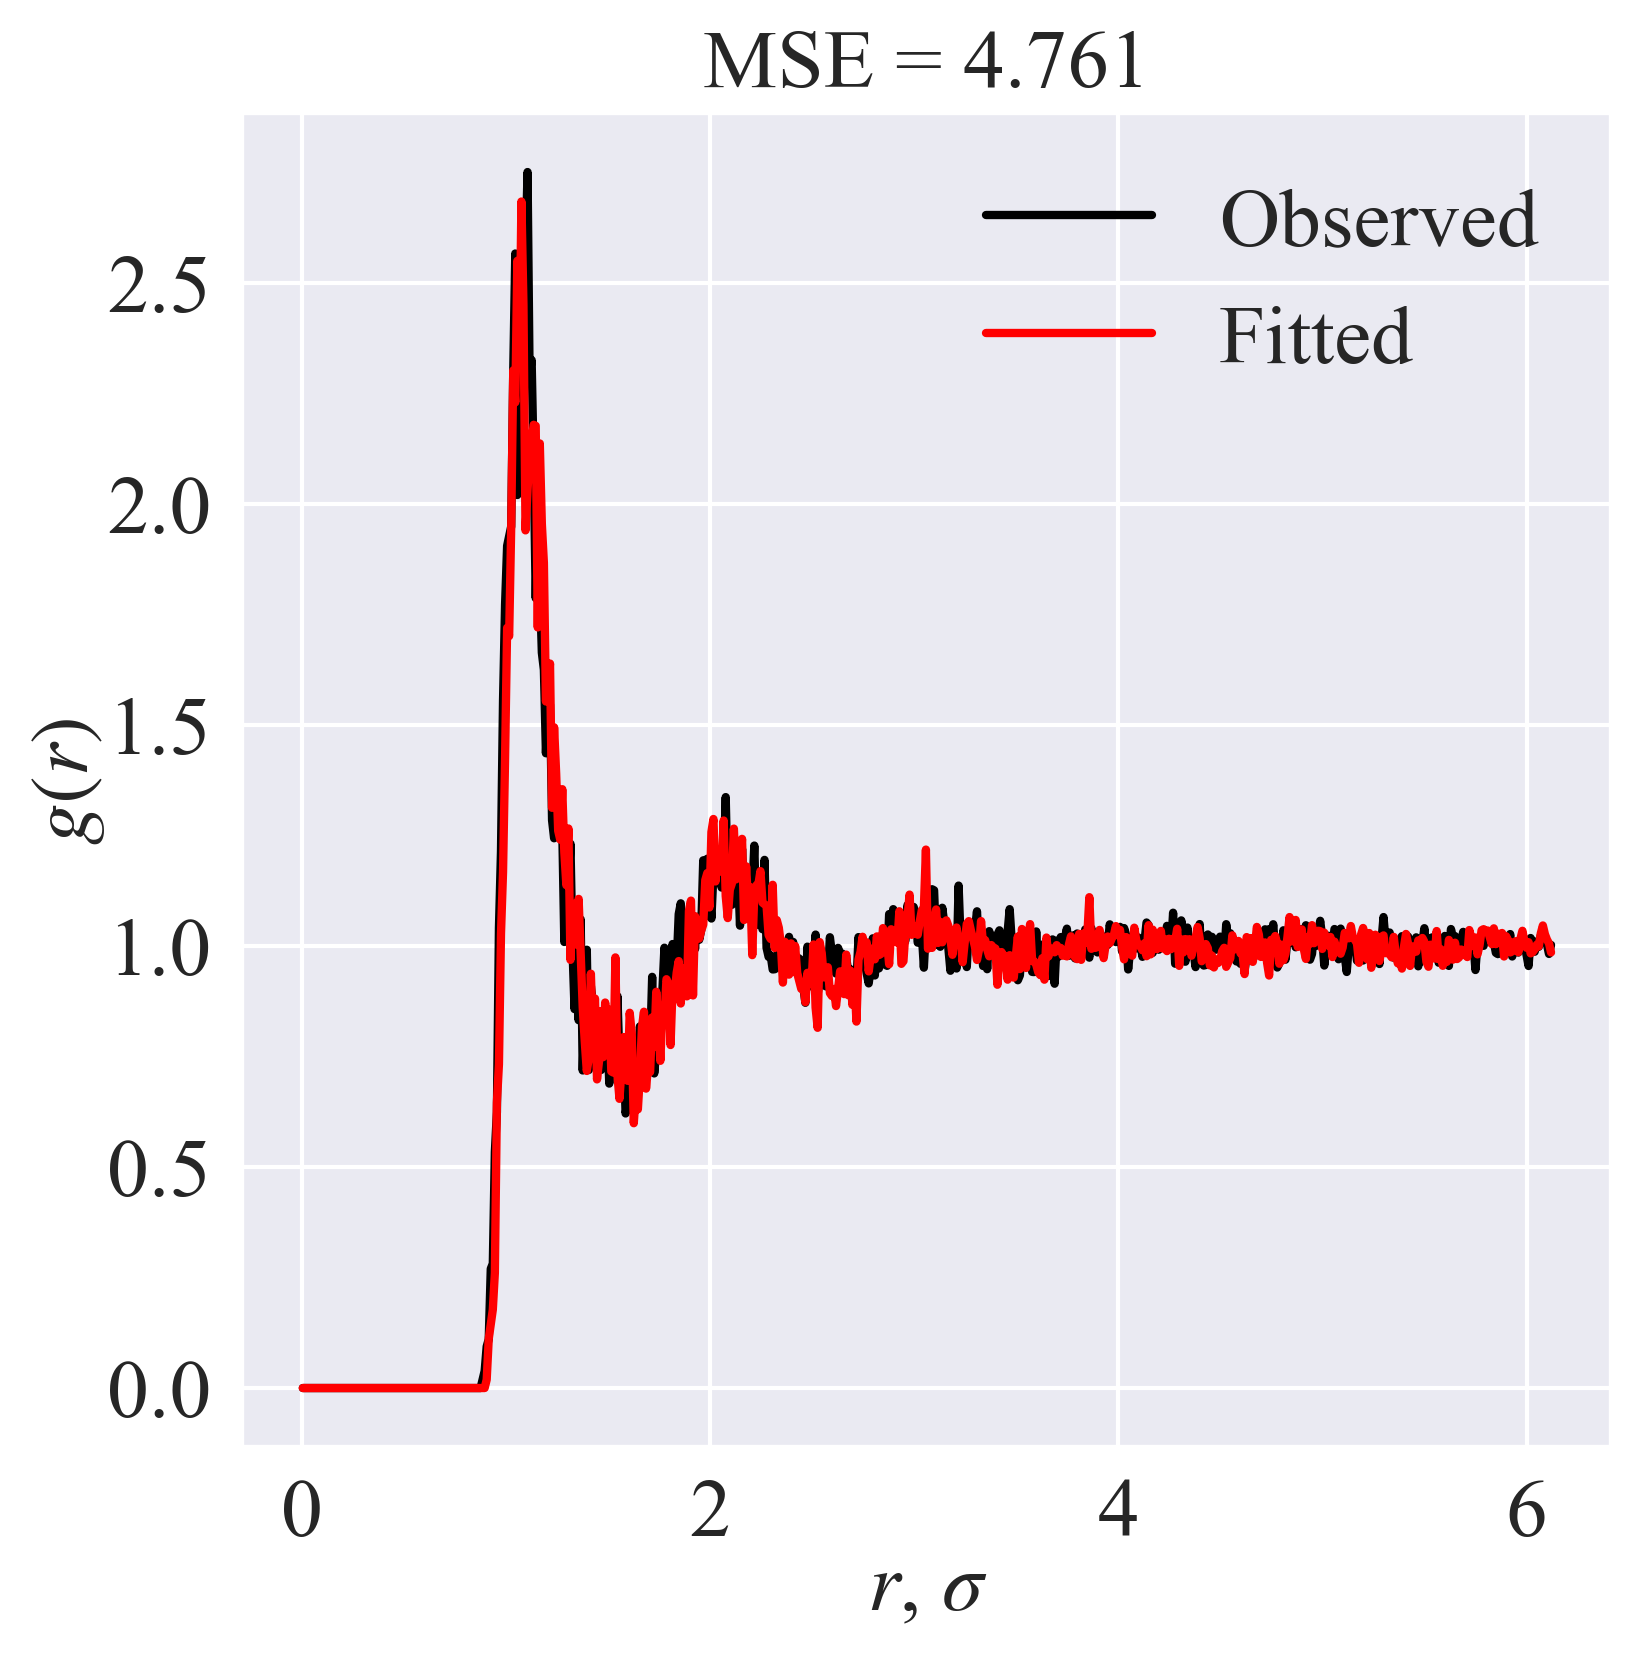

In [14]:
radii, exp_rdf = calculate_rdf(some_positions)
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('initial_state_local.png')
plt.show()

In [15]:
cell_dimensions = np.ones(3) * 12.25

In [67]:
def optimized_func(positions):
    collided_number = 0
    positions = positions.reshape(1372, 3)
    radii, exp_rdf = calculate_rdf(positions)
    size = obs_rdf.size
    radii = radii[:size]
    exp_rdf = exp_rdf[:size]
    if np.where(exp_rdf > 0)[0][0] < np.where(obs_rdf > 0)[0][0]:
        collided_number = exp_rdf[np.where(exp_rdf > 0)[0]].sum()
    result = mse(obs=obs_rdf, exp=exp_rdf)
    print(result, collided_number)
    return result

In [72]:
root = differential_evolution(
    func=optimized_func, 
    bounds=[(-6.125, 6.125) for _ in range(1372 * 3)],
)

140.57538243031902 605.5258564552109
165.63829905607548 610.9337450847377
180.04335999540265 613.3904242189391
130.39303898510119 601.7476310468961
300.64236644174724 618.4874813523933
4537.044928424971 668.3116773722934
292.5931039096156 615.9389704755945
143.52559766633348 605.4249879022129
163.85500230168526 617.2338691907762
160.34811622694124 613.247521703441
138.62482986081199 606.1888468639237
134.9354497183162 605.0138322698264
124.35432957869348 599.4585247088286
238.33004531441375 623.6870953861937
216.93608810432798 618.6644857583469
224.4989697142382 623.7232587974418
165.8442064875565 616.8738183316264
160.14717911493042 607.164082784658
149.86614581611883 610.9696293091506
203.8777249562341 613.9767747227969
136.30183704981786 604.9397250891193
222.44270269893426 618.7239210801786
289.5646191081135 615.5188607319258
150.85151002295322 612.7951001908848
177.1577418983181 614.7561260402542
207.9163299211357 617.3849791580121
143.2246689228463 608.3522726933872
165.579537667

892.2062204019136 642.7119300240025
151.39514751166726 608.325543933905
172.26899272001089 611.1868979511623
167.5745704751938 610.759677565484
753.0624647687417 637.875735542108
129.7481539157597 601.7354116604592
156.2491449045481 610.5128951638011
286.96197099398825 614.1400575149712
147.9861956138978 605.8021000156709
725.545049361345 627.1444345311096
159.35460567315806 608.7712071391965
121.8460244500324 604.3392779541301
136.06969913840658 607.1286542476722
179.78389139311804 608.9673674665316
135.42630589817972 605.8133807920067
144.58959419500692 607.1598444276858
134.08479234889327 601.520581536938
154.36033426223642 610.2969242465117
313.2482454445878 621.4184523884428
195.83698320236232 613.3821332327507
128.9817441089749 602.367826124853
113.40572551093094 592.7546725883179
163.52042864983537 610.4552828710449
234.23489158903112 622.01721155234
131.0035465277054 600.2594405454563
173.46447959959696 614.8461479311736
130.34341330098033 604.0226679904858
149.17964136597843 6

140.38345298495454 604.8722595504355
120.43508612030112 598.6613071381568
187.24688755954452 615.8825867269463
149.66250775928765 606.9026230827167
161.27968637524162 615.8333143870298
123.30146085327651 599.8223382916774
153.25365834480985 612.2144144295896
128.72785383104113 604.0553201831033
751.5154610295725 633.1710183031298
137.62906112598213 605.0443174998782
110.41967853775641 595.9021896418695
119.0752618153693 597.3356311392606
455.7068592188342 635.7044564275171
207.39734357074138 612.5214846649137
4562.091348845823 670.9742966747094
120.81707118681274 600.0967415823307
156.16666380519277 611.1262396836065
119.05959078055295 599.8862251145827
134.2360690315775 606.2949688906456
133.7551369382202 602.5643048638526
135.88012149718674 601.5240825889063
883.5265942633579 640.7901778750083
271.7332083745789 624.184056370358
139.74834653841563 607.4365221878104
154.16686349679225 604.3412439015732
124.90137951553032 598.801782824114
124.17684129619258 598.5837632761768
166.8692445

301.5581440737442 621.7884004412127
125.76440885331792 600.3107480791643
160.7160265867096 610.2653765585591
130.47227699744252 601.3660336260734
136.37091399306337 603.0213823933011
195.1661184962897 612.6284739777966
126.02643602136023 602.3524432182153
306.11860643365435 618.6693105210372
132.10074746749748 600.842248752372
113.11782313749269 595.3162001654013
144.24354020106972 606.1991570171792
130.12975101361147 601.667818577461
153.5455527064355 606.1280838097687
118.53737822759301 601.3041520249413
4554.082512914529 675.0217144102768
132.09141340716286 602.0584911310559
140.58659654242854 604.8114810128307
753.781986351658 630.3995298224572
150.44683936381912 607.3779496522088
136.60746745939005 604.4441333210286
163.3625999590964 610.5797813148895
183.66749603112936 609.4441219727108
787.4149162858113 635.4727053048111
134.492013679771 601.5297721389265
216.9533226877254 617.7472078668559
127.38180629918749 604.4937796227031
162.60650571018328 609.6493396358146
192.99165186330

185.39666008683935 606.9911121999809
144.7502763341966 604.1764481795499
231.95786997899026 623.1466426021809
166.6179978456743 611.7094840706782
131.4194474501978 605.9511037386311
134.82515618747132 606.4238756464645
148.67735749215166 606.0013219563643
158.04726194268363 608.8531379515068
1131.0541210072886 659.1744925381272
127.9191852015531 600.4258871851664
152.87673197568023 603.3677584316579
156.52754282727042 607.6808052365864
140.31588506073874 606.0535836891155
138.72427575193575 606.5600508579773
136.15136808331508 602.6500214274645
126.6278463612928 601.5804984732789
113.33579925258637 596.4727199068661
153.11765231871468 609.9506956386833
127.00938417046233 601.7554135985239
133.88604723507183 603.9947748526298
131.44375914809933 602.425278706819
221.4613030342805 620.6637117874374
142.31883211721532 606.2541616404897
145.55686803612244 604.7663973744936
128.36979952625342 602.4245920225371
196.78612803507932 613.7273575860818
148.55083935200403 606.1816228626652
292.4351

155.49334820027804 604.2612412024697
132.62165280309966 602.3625874778654
137.35328986721242 603.2026354128326
137.8034291020714 603.5935871916174
137.12756402845645 602.6450461096974
188.50388450549147 618.877647149131
164.9562528410943 612.2505796202962
128.66957275848952 602.1303467817361
135.84352819446127 604.0717379486898
141.9275092000822 607.1295104453227
266.3576900872455 626.3334207152316
174.17260616083723 607.2265501132158
132.73391840847748 602.6322079345612
137.8777114245665 603.6208822932488
166.48490037260322 616.4570445108877
389.0731084699014 623.5600872291188
137.65727639233046 602.7582034794709
132.73822798840465 601.4466158341613
130.73397021873546 602.0267823013996
130.16045665321076 601.9981285563347
132.67084400230564 604.0203323128168
160.12375947031708 609.5250497898134
182.8016871214005 605.9648117673034
165.66275565976989 610.7125334551818
197.2100988032672 616.8012285396271
136.09903630106723 602.8189833957061
134.84339177635138 601.4513045521526
126.974814

143.59079198879647 603.4828129869405
507.14495317792 624.6945257434431
135.68956101202514 605.8529275752146
157.24139083420008 606.7850521045698
254.34747424811437 616.8535027539263
340.1060429567993 620.3708203298248
234.6090246872599 612.16476235286
286.3225961424647 610.1695713822312
4556.079851956552 671.9786572120801
216.7545582159993 615.1340485418442
157.35536315596593 607.9122465033502
4716.665572989655 684.0399634177687
161.03255403755804 613.0607623388046
159.23325523269216 609.644258509681
173.06337183992414 611.1381269141618
125.51918393238691 598.2117293030648
170.98275429671256 611.6173861071063
190.14946645459486 622.3081923175519
4708.248186038678 683.8723764625468
147.07782434815002 608.8368157897075
150.85423678698425 611.0765258543979
137.94193745736865 603.608109610597
135.72751087726957 603.3783288574166
124.34630389959794 600.5879589830005
134.6521539775389 601.6854198502215
128.68291958128202 602.7116948681177
156.62936343160396 608.0842950371232
126.519208322391

181.6297889313266 609.6773002355471
117.94352168631731 597.7629898226538
176.20235118704662 606.9998700692377
131.2157914113957 605.2364023113739
122.2413608050192 598.382622616039
174.0587204403628 613.7547573047516
144.89847681447506 606.9571411096726
205.12271297778972 616.5579977883428
138.11817770091943 605.3542432363663
143.88287403585466 604.9266974467416
155.75721073414127 610.540450015475
146.4773368425712 603.5199376706065
238.99535163525994 627.2662537237675
144.5594710576387 606.2005168800522
126.41772178153155 601.7323261352353
149.11992874197261 608.6832038290977
171.51084419291655 613.9083266117499
892.4287081068036 640.6387595707691
292.30895245202026 617.1063843849947
125.79995577505238 602.5355406030299
142.13967772123272 606.3679175318512
162.8808016255899 608.6735627452229
726.2851105438451 623.5176210286583
356.78595103392126 628.0933488064048
212.95842997170922 617.1849378927343
148.98027023432633 607.6383723155825
150.81840681661944 610.8182459777731
123.51100179

331.4209809986828 627.0473271749202
147.81745288016248 602.406676069039
157.90962912862852 606.1020202627903
120.58660261085335 598.9263784630516
218.3548423389916 614.2165781710776
204.63000611131204 610.906755964657
124.638790685619 599.7856728316519
165.84542695280652 611.9263340601126
745.326962041391 635.083390555547
128.74117894242295 602.3512923790204
303.0621885304756 618.9109087903998
139.29144558780627 605.1555338128285
152.03524213628256 611.5411623469025
201.42134197685792 615.4662912311069
125.67903458120992 598.1697841298513
194.32571253209474 609.8648910177441
132.0151361327487 602.159233311994
141.41417167667436 605.472518770334
767.198337025976 634.1878339216023
166.4985867363713 608.0489636609907
230.62594950162057 609.8859266858337
220.67350415302312 623.3452341945595
145.8211952090121 606.1201974403616
192.56714605900183 608.8059502952444
790.3967029276157 634.7001835823935
164.13418024988624 608.7002051835066
194.68584558032188 616.9418521378007
158.52177121502845 

153.735963784655 608.3434774967749
184.3876208603343 614.7919068068682
124.3603234393908 598.3625412273823
169.47925287887585 612.1857631106868
140.25184436381522 606.6589669246351
137.9285379895223 603.3143992304117
146.15804713690488 606.8721748090763
200.75693135653748 617.5991466857841
145.9956408765497 607.5189984435785
203.8751995053321 616.2771599741013
142.26624041459348 608.1022672359195
175.56112934014314 612.8463564408395
289.21348059816813 613.9912468134982
134.42884357778314 603.8152123726761
131.2891888615251 602.845467879244
163.9170170198203 610.6351938607157
134.73778711736085 604.9117892488334
150.5117110339027 604.4908522891981
129.2170829530644 599.8761261456457
358.29949075658214 625.1154782427743
161.08125536188837 611.3085897382517
249.13961809619565 624.1688589396657
115.29318004012522 597.4770702432204
127.4736229549246 602.4616192389866
116.98806129342371 598.297757388456
275.12016900241906 609.853303302941
190.89006314652485 609.5602988538926
155.465193312122

137.3515871541489 602.1314766578782
185.3973492283291 609.707831224689
180.01060953649664 610.342878344975
163.2812652823072 609.3970391772596
135.8238230434763 599.3746877696362
248.0633326527133 616.6621373429128
4540.406462965491 667.6426549153944
717.7865221765676 625.1313237753143
189.18506092168178 612.9411861530959
126.7981714444035 601.2817496906403
240.31567202150862 613.4301090409311
142.73380645300233 607.2874499408872
302.26281484523764 619.328007796832
135.9472076298139 606.1070068328045
323.7143765298797 624.9987113725554
350.5935310803964 625.9528663216103
113.01833583266931 592.1011148826177
162.85043225247733 609.5087699172286
172.34636113507744 606.945798921568
138.48519218009298 605.1261869426982
4603.280831171647 679.2179191334347
155.7234581651232 607.5889492291103
176.35286085913657 614.901028840683
167.00403955919614 603.9797790668217
139.82975977910547 600.4493601563529
132.60698479078596 603.1061162705921
4572.114021348665 674.5697515746106
130.01846222888406 6

149.08344688214245 602.253677982254
124.51002173767044 599.7142450250306
156.98093984559193 610.3746756788478
182.30582862212668 613.2065631468945
123.6940429793477 601.6409514739788
145.702479424628 610.5975134552531
280.4009610684092 612.0618775859825
121.62527455228178 598.2520435590767
130.06405988496422 604.6771531446633
131.40521281712802 603.78143691114
180.347920359341 606.0954791299296
185.33514396532107 615.9267829406213
206.25213772456587 616.2135879690597
135.66755437923686 604.694960026628
149.55344962357137 609.3349003214244
127.34760149305951 600.6036624850623
143.47812153918235 608.3866815410643
137.21710040691048 601.2760882943251
133.4502421853647 600.7268753716609
139.19155242806474 605.544008013622
141.22339230007591 604.6600221797476
143.30709949824018 608.7685081543426
131.77776797850666 602.9535687375468
124.10772835215703 601.3085661628536
300.22430399528577 613.0341546342042
212.99829116773296 616.962236010407
144.5068420291697 603.9259845898039
199.44943451717

348.7854779487172 626.8289882424183
138.82867244107644 607.0882831343717
129.44971667840022 600.258865489048
153.0964997482619 610.8920738548566
121.86974641521002 598.7847980518086
158.31781977507694 604.2253078818345
122.00164049520484 594.4873265018957
1102.8209448536113 652.6233002659972
164.5403648930823 608.8218083438301
196.20609974592878 611.5971233271523
183.10515046620756 616.661261541186
197.788621311264 615.2475981423836
149.98563959125383 608.673832567492
155.66412309659657 610.6329997252501
129.16930925179435 601.2303673173456
204.97035739772994 616.013595924398
221.83852111054273 620.0949976084214
142.7089708648352 605.7349717146731
125.6326951355553 600.9680913637419
322.65143799933134 622.7341455678966
123.32864319149705 600.8455747347626
176.02609412947558 613.339238769996
206.22060740604945 612.5860800116529
129.45898479183523 602.5699401694062
152.03656781079061 603.8738275892847
127.75289765919014 598.976489860371
179.62767366678048 602.9568978564957
185.5291759429

133.0982536781894 605.6667260729023
159.8546992502352 614.3023087447089
856.2235447769522 640.6906874481067
197.7647380191811 614.1979855832617
189.61811889393167 614.8245237392767
157.54640277945967 611.5504754228969
130.73852762442894 599.5529293587713
194.0113199873335 620.7114841826599
193.94365308589954 611.0024897693315
311.6780776002674 621.3253899140773
153.08884196517224 605.506809495289
223.33678368247143 612.9217544613516
129.2244481266871 602.3212022126339
310.5880231862737 625.6871769753718
747.8193554605665 635.6469586941699
145.12856995208747 608.9646316413334
132.6239635740674 602.7198955866962
186.62836787667388 611.6552503179821
202.3913452858808 623.2902131180759
137.91708886787097 606.1446103924015
210.64413338441665 613.9498525162697
183.74110013421208 617.899703474272
146.15004744689907 607.9960977086205
132.0501448982842 603.4636517873089
321.87172652343344 622.8976517516983
168.4246651109803 606.6257923877206
131.95788521283407 601.6266791891932
133.934888339671

262.5705063827622 618.8376245869529
183.3236287809056 608.4945482334158
136.38003628563496 607.1556435563562
190.33723812875178 610.3220869668229
124.01678442833358 599.9314592422306
132.01171921569946 600.1064475034149
250.22132110377427 623.8037789688193
133.3985782896337 603.517741724165
743.8475693532109 619.471660575048
725.8092346847988 629.2316634873821
124.66610693380485 599.2111860185747
128.38831813261677 599.6105629588865
138.94390021798233 606.0381821199232
131.89224630607305 601.7988532185593
239.07588235456137 614.8804329310201
194.66859934416757 620.5919886173417
4546.547462261586 669.2392518945381
214.73141263782333 615.6973011228042
133.89193829779373 603.5192509840789
123.81903782501736 597.4319132222921
154.58710903193372 607.4315528261925
151.68919070277522 608.3694468089236
146.87387095695703 609.6355820115393
219.76925467616877 620.5160066896731
124.7454820877862 600.159134503955
147.097703161639 605.9627859299985
125.68998520684957 601.0422175353833
134.060496889

233.82385928882255 623.7666317789212
288.2253442352296 615.4879805354706
141.45362445821547 607.5194369354465
304.14875238322196 618.1221378487161
160.6669875009686 606.0015356238757
142.0111719279721 607.5751844268054
155.31969516498376 604.5901579180478
128.2487063132313 598.9887665902578
146.69454166667893 603.2774125718175
155.32225623525378 611.0395216639415
181.3524398250052 609.5715938604336
145.18539075570237 605.4001156632818
121.3379286756946 597.8032459867807
231.8020232904278 620.1128122501348
141.83187462912824 608.0843242363974
137.86808444249024 606.5238353840294
219.40827732416957 607.7659084781533
148.6891236983207 605.3581887090961
155.49193639718487 616.0737714671906
120.41504738095568 595.1575886155284
145.26942686411226 606.9311873955237
164.84334651295003 611.2204888102679
150.18627936660562 608.5907319877336
354.7277866362785 623.2622076444973
109.81620735611509 592.5766657842241
134.6681275824808 605.064779321665
376.997984566219 623.4002797064613
121.4683342453

137.22032096288308 603.9252650711317
120.99936990740221 599.5542470577597
141.7140737250479 603.5122814307733
148.2134313598505 604.3094201267438
139.76723999574773 608.939568151516
763.925264868762 636.4451106622306
118.65945323376371 600.295482960847
148.22333655214763 605.6866720449523
144.23094066636622 601.2114858594979
165.25713136996325 611.9901474431093
198.31008325424546 612.0699736182357
144.44900815739382 612.0015795329836
145.72949691021927 608.5417181704456
136.65481119016647 602.0037800660427
152.01446170715238 610.7761551772861
152.5060148845075 607.284564260837
199.7596602643354 611.8218613198626
121.24190258957567 597.4604894988288
177.20205378928878 614.4558041877867
171.2103854701143 611.3267769157713
4549.3128135220895 667.2097289062253
263.12612386526496 619.8281133125888
134.60670867905728 601.3878661865258
170.19597404366053 609.0624330019448
128.42692828048763 600.6903113102749
125.32346854675124 598.6021014661885
148.25715649099058 607.7003507841333
169.7231839

120.93298315754055 596.5260091726576
123.50520446926748 600.1283098940378
143.4893745853456 604.3633660246485
153.31483046154798 607.9508950253087
217.15733680555968 620.3809091387932
157.38774609897004 610.075681802949
130.59157132523964 603.2679201645412
364.8184146528271 631.5945745137949
239.41697028678107 617.7541562046358
129.3076526337967 602.6029238839692
286.93710489703307 614.8700781170648
130.0262680220243 600.0652635611825
185.1611112356172 617.6843222858724
159.3759747276019 607.6298599246858
146.7108161886241 604.3617955377312
784.8577899773509 634.8055774739157
289.67643871796616 616.7746732907075
232.15882770772657 610.2336919359141
203.76829406566392 614.428296851067
131.69834503330534 600.8048275233136
154.692146164305 610.043748107888
286.32702985416336 615.529755461793
163.84720051151734 616.2413930061183
138.26934768894577 606.1877147130126
143.8498298964202 606.3493074477664
300.7204411992307 618.8605244865712
187.46058280492528 613.8521145391293
4569.303490410421

155.86587301115293 608.4410310522519
4566.760577009659 674.2848889837064
136.40722009932793 603.3011939324604
229.5725410733204 615.3715799552216
176.8401622911449 607.1050605183553
4552.459653551711 671.336846682376
122.54217446591059 601.3707238592986
135.16922581673472 602.6130756192672
183.33755037672609 609.8839917965711
125.94473905904327 600.1537029294662
206.6558770236578 617.8854165084967
137.55551871312002 599.9896904092967
119.15265921801439 600.1227527188119
139.48119351274389 604.1213271333459
160.07932661109874 611.9709805642017
198.64383920915364 612.790623816378
160.3990167159646 608.8880572654149
248.79218831721593 620.2942753269512
190.11067194126466 612.8294218126848
177.40473762081697 618.9117480483744
159.57277326600024 604.6633670813081
140.94709836746043 609.8577031265315
127.77969352258653 598.0878768480518
296.7926999375253 618.4702947818649
141.13939070564524 604.4785002520623
186.6806897353355 613.3028070077534
174.22650792874384 612.3665229841755
221.5993281

166.17993903376464 605.1066117895382
193.49069784924757 616.5249096024495
123.11067909190888 596.9880476466977
312.6385198183626 619.5691837264822
145.43950429677005 605.465160641637
142.98460374624983 605.1474549454434
185.2945063168015 611.643755010316
137.72171678901648 603.1166950951426
138.65095972078993 604.9246208368734
310.90937086885754 624.0214686757631
148.7202295459073 609.2918232511175
169.93331092164038 612.3491132100013
154.5519833136165 605.9544268528149
234.9331318425636 619.0154189903484
181.83326234931056 607.1861107456637
125.31834599822876 599.6253303864539
147.0320867760906 606.6452569947973
135.14569420628052 603.9804559222629
166.8672219011302 615.9257865560571
134.84940098146365 603.4482708311766
128.74817091082917 599.2149770577953
122.43480855503095 598.0753774914016
128.34941242310052 602.893638262221
156.90756349777092 603.2773171240581
149.67226237834635 604.9513186042113
134.1033220234382 604.423281624118
132.09739843461443 603.3480403931471
116.825273632

135.02529408799504 603.4559350070847
162.28797699476308 612.6615430179579
133.93280417084318 606.1653644253914
135.7024950896679 604.8240514139458
139.38344359796258 607.2021506831663
172.6066161401106 613.0111529141844
117.57671428620324 597.1974787375132
125.01869028644371 599.6401537001268
134.9402206729432 602.2982561444849
266.59065331413547 616.9477928463457
320.4324574618762 621.4104750579189
153.20635001510823 609.6457850691263
124.82610859516824 602.3772413029546
217.7957009817839 615.3319163049302
132.3841417417666 605.7723282154461
160.67112047421602 607.9201675258893
295.19816165852694 618.1338269892569
215.58753523368412 620.6185358898495
121.22748729202016 598.2862012484856
132.24456074028004 599.1917669810966
4719.788145454238 683.7689282672295
125.92824837988968 601.5920027013533
137.83166589518007 603.3878210690992
134.77607006509797 606.7370883248725
192.8499575619222 611.1576895746329
124.53724582071672 602.9136714658581
141.17104877583554 602.1235573243221
162.37691

123.67957852803985 601.1347467540636
134.82281024744935 602.1735285561988
150.28328348965977 607.5673398279232
129.25551154039923 601.1668168862958
140.99383199766064 603.127855854061
317.5051179777426 620.1124013232422
155.88805110153257 611.2133565877137
4700.964698131238 680.2013394277092
187.0942836452399 613.4519642788109
190.0493587092072 611.8143987323613
141.67611631379424 607.6958082090018
114.95496744871623 595.062251476972
310.08103013695603 624.1949027566997
145.60734847859766 607.1348576383537
133.71650183775137 603.5864689955621
390.17547414309956 631.8693704111145
144.19478936428533 607.1803010933332
199.0690118741667 621.8805048462923
138.16070450958313 607.8844577235412
140.86880230558447 604.6411855698038
131.56754774379988 597.9612277029729
193.01243534301543 613.2772765248653
285.1202461856314 617.4128739235819
198.19677327122696 615.9893260745497
131.88258536512393 601.6140214287162
123.89877169977272 599.4134920814038
133.18376121839643 605.7608743152828
148.90459

146.03285760468302 609.0529333323611
300.7019547792839 617.4996544060122
177.70962428782266 605.9821994230822
140.09847114727302 602.1219373025551
124.1926970839753 599.3018080465607
149.15544292993158 608.7932440892642
151.17778849466407 614.5481196007947
190.66549944193335 616.4965592460678
210.82890063895772 619.4431860902865
128.47427295442685 598.8981285934435
147.2533207351099 607.3218134459524
157.09033704205217 612.4051441563965
137.98614069745778 607.3310224691597
172.20447378060257 610.0139271580001
142.3128257872336 604.4349813833197
724.8161260595585 623.9019511357869
141.66896521788433 608.5228411206638
168.40687980690598 612.3857349768309
134.07421733907594 602.6927555492682
136.12247464010724 604.861946223869
223.9194048811778 620.8256479532888
129.81829428956746 600.5076510837927
145.63974351792157 605.2791126482095
128.95192454526642 602.3912833876218
208.80476595319377 612.8489703614715
136.97796236441403 605.2549312241879
155.57999381457495 608.9698102516625
203.0693

144.47537151463405 604.467588062323
150.9365102360948 602.0659794924586
226.31852899040967 616.0584707584869
128.96392300306334 600.4567509935382
154.3090574197351 604.1143382821278
187.96011410722568 620.0866453124895
215.457911163043 616.723187525191
375.27063412563 627.9047476662593
132.99404679315845 603.7917158376605
132.4992171002105 599.3365863038626
423.84976542649474 634.6050457948081
728.1379166471726 621.7766442401729
174.00420938503595 614.7157330890669
127.77553440079927 598.7888940174516
344.7988207242297 622.9546804499082
153.80266770582483 605.4958500255894
130.53134303846457 602.675821623318
131.38482092121794 600.3672349028782
132.02246547206087 600.582537596593
143.3108596848566 609.5665994974819
176.35930423867677 615.6179571826989
301.24527409984285 615.9733521984056
131.5540894773631 602.6231630601904
164.14473533887758 609.6920390048713
163.3788968697526 609.6274472599988
166.7459027552593 613.591893000696
201.16391473532673 616.2435478987154
299.2496766866565 61

334.45044934243475 620.9057394123145
306.9332512130281 623.2712026662691
144.6303094976411 605.4775765701422
149.01525726975916 606.2352521583335
140.1639244682224 604.5031883281642
143.6149734971775 608.309040159633
146.0223757461841 603.0665709235702
232.0071137146259 624.4909141706804
205.82521177947515 614.7720649841533
154.4532928294522 611.8119714969566
122.2381589079372 599.2868361896594
137.3048424939283 603.8922163402838
157.139511732334 607.0521093763501
172.34496748431414 606.1523701418959
118.00869122864192 597.8181605475684
131.3411101487797 600.901541916382
133.412928583437 600.3409055430108
219.84035389240668 620.500155941033
369.48201365984977 625.423599985124
171.77678351005162 609.1164522564848
212.26255264548377 613.296629358498
202.16704558887986 619.3413393672917
176.00863108134246 607.0151908503929
426.5832545340821 629.129102071251
239.3321096612318 620.0989080182953
138.3575477940517 605.6346916937364
157.9294208873871 607.7227000982853
208.28114913525587 618.55

143.66375690680928 605.746009791309
138.2770603707346 605.8993039852128
187.26606078610953 613.4638848739642
177.6229278919349 613.3634525282557
140.1461971310685 603.0792595448302
134.3574772369013 602.7983595782512
143.4050445343653 604.6804037959488
144.11552977794926 607.9779037834451
215.82386589349858 614.8156267540191
896.2487929636495 642.944615344547
143.95890061257847 605.9260219710775
228.6134763284719 611.307831719135
118.97352787335615 597.5361820850997
144.6738538981683 605.927597619938
149.84718220361813 609.030314133595
145.5793740497304 605.729185391154
908.7256993518271 644.5043289613404
137.80353859597219 600.0809150368227
351.95946155972837 621.6018623133187
168.82930058762966 610.1873791870796
187.2729547412989 615.4613351608577
251.07374963573125 623.1304847010147
142.86079230936372 606.2496426509692
142.92242885038513 605.4835627506916
143.72078217562427 604.0825906895136
129.6350674561016 604.0083662033416
119.51438036519811 598.1611094350823
136.63740555208224 

129.4642877429455 601.3576850632428
163.16701490296145 610.4712702743775
138.91639174119337 603.827211984503
162.02149774379924 612.0019568822831
152.00856779759212 609.0688228858354
251.1091899137832 617.5596255363835
735.3602350578357 628.1401729776071
168.60962959547507 609.3382204447726
149.69703875168477 605.8081329059646
126.80460316393078 602.6053462496617
221.78369160501364 620.5500234819201
128.05224514285317 598.7851151633089
124.94611160448899 600.9158147232129
125.96939470807574 599.274802824498
129.18918562068342 600.7828724564436
141.65232440093456 606.1596913326482
161.9568396368835 607.0347356661387
150.96645369434307 606.7038738784888
146.97645035675004 607.970664795941
148.33036848986572 601.435905712717
196.93802452628734 611.4787088681396
135.69938607091896 600.78429337589
300.6515872226058 619.1148093390759
167.53560456268497 609.8451657144132
121.66939431954313 598.9513572928475
152.43200071306717 606.4000127242758
307.5918121763921 620.9769085568964
372.450009076

123.1866611679131 599.1164591103205
4549.257190364568 672.7012778796709
249.22474210750482 623.2603138407835
222.11823339451598 618.4191090070785
136.36578210300655 601.893619976303
779.2342630734831 631.6530876223477
145.21428332315875 607.9133301490124
355.4943762619061 627.2931472140021
132.77294983723954 602.8658679749342
150.78959583736736 611.8284117432864
113.68881219512643 596.5313191254725
234.39172529176935 617.2641072876288
177.54149472840618 613.609909497316
158.58437354724265 607.430560544661
117.15950107237231 596.738448502449
135.82333096447576 603.5087114987257
179.8273865308136 608.0974766838008
250.0112921888273 616.1852163471005
161.6037946653376 606.9823869366473
160.98563596324536 609.1591029403786
237.79489604330502 624.783630903849
194.43449776822706 616.59461453323
140.54150116984934 606.7578558989042
208.116422778193 610.9459380388887
181.2032743810053 605.5249521199423
118.96097648490208 597.7291831978196
144.77281355726316 608.6061821071943
194.6743341613471 

133.29241941226633 601.5455636006254
138.91275475998128 604.4686102700938
140.68628049632855 604.0564842579386
128.6170399856206 599.89383054995
117.57494354402273 599.6684051143873
156.50333724622598 605.3855621303705
154.05731178134354 603.7074501569396
209.07735465310884 614.4447449407974
201.50926844686484 609.4761746040048
131.11714419087835 605.3711021953454
147.36301707261686 608.9635150707583
137.99344628377114 605.7216150884703
146.29198974917497 606.0546156189546
4557.427640645785 673.3447819633025
127.01126518251213 599.0083246610643
182.3343016492598 605.6236460814692
153.07739986522063 607.3938512426529
127.43534239088403 601.1434100780202
315.8237230301364 622.6113153946616
135.06071340377747 598.7231698184537
136.11103262691628 607.5247997219819
111.8596112782301 594.7017985797999
165.68194302634123 611.117461300555
165.46451089010338 613.6433694524055
349.3293485228077 630.1911979766664
133.50743092496384 603.2340067429162
135.5113694787873 603.9425956315865
159.3913165

135.8217839885096 606.5179632375394
186.18984792706544 607.2311948176878
219.818277971976 616.2038353200096
126.95344475366804 603.653352119416
136.2471758227549 609.2925612570995
125.08590419419467 600.3580852359244
147.46541163151366 609.0219375809502
758.6244018607827 635.3550395821271
156.98573216900292 609.197262455978
394.0015633799347 628.4980642992034
140.51610159204503 609.2666259584556
141.52503676922598 602.058780557997
188.28716735462405 610.3311109666538
176.78812850154395 612.7627237392117
138.67427868315016 603.8936805711111
171.8204238443462 612.4407931812823
166.5488046867898 609.0479092082016
210.1014345032105 616.3943765832751
174.08709450536455 612.408149443922
119.6874950244812 596.0701015344097
160.1034512776045 608.6183599299069
136.6496925726563 603.7502126691064
114.72934688739177 597.2049680248147
151.6750964296281 604.2433292597198
158.26878310403333 609.4846093684068
139.43292816279867 605.9111274842186
140.24064913949698 600.7435951579104
142.81983466684179

122.37827751867412 601.9325320614288
139.6530737969875 605.0961211201472
776.9493733155813 641.9378606519379
141.9447607207143 610.1337877024263
161.33575027827007 608.7008458500435
118.53177095397305 596.9116988983806
119.16433897076148 598.513237354256
163.29236215572962 610.2657158835752
122.07391943757676 601.20672855453
163.99473530284797 610.0715099422728
143.98400525804573 605.5037861790892
157.97345114886645 613.7754107301901
239.5304441608124 620.0066482917036
145.69869344074723 605.6573367312012
174.45702915498356 615.416414759673
132.1441878642724 601.5685696142416
219.7697031174027 612.0359090643636
138.17522526631086 606.3314088804843
344.7477140192279 623.9017099828421
740.8474080523455 625.5391315166156
161.33894584960618 608.0797333687547
155.03941244826242 610.2192374925228
131.15695257488022 602.6592441336693
169.96097606111414 613.773977109007
126.29569661345397 600.1282116175884
145.59694138694184 602.6455203485075
174.51256988395374 601.2694847423008
144.9272272556

122.33244414342435 600.9009698045472
749.9904704538503 633.1970941766888
193.42893819677292 612.2205401842009
176.62912570945065 611.5460298189262
171.81996063928707 612.6003636057397
728.4848199192073 627.4647298780474
155.43854565357654 608.2796294421944
189.0578081260692 619.3478954993327
150.4830958837871 608.2350221109637
223.9142106731212 615.0680343085727
201.2519723290825 614.6919968522307
319.6688829672714 623.7392328732911
143.01526914981443 604.7060382573637
140.44548376202857 605.3924097732062
300.02337485367684 615.0789134764345
730.1113008529538 631.0898673335068
162.78373389093755 611.9948353813076
191.63896700119065 608.8195320559838
217.2747101478683 623.4522349469232
141.29435031242716 606.8744580869408
136.6967438102062 607.13245347911
164.86304585076167 611.1025423505292
168.46471109758227 604.5924958260446
232.31978997089234 623.0099563454366
168.53198699840223 609.9737071537958
164.7708414277307 612.6266494290871
143.4011405590463 606.0701787811038
137.46416150144

733.3912294431935 628.1848043387441
142.66166238283873 608.9327067378501
132.9146618277108 603.3974553604078
245.8212228543621 623.7992841055283
119.11264084055146 596.7342732305115
118.4671587151447 596.6542338181627
749.0802628721365 631.9955758651622
139.3642012227564 606.5509863855125
151.40167533668617 607.848111400998
4560.752001900109 668.6291618877688
169.88726366086618 606.8780785044055
143.87054880795057 606.894765284514
136.40135438926325 603.9084073305721
130.0336958595126 598.7550723981401
158.8824430101187 605.2682363134518
333.46095469135213 624.9391746283777
153.50355193833371 610.936833310061
155.77813932190944 609.4295471150815
137.12563603155579 605.7314064143004
167.99739565407702 611.7292345006126
135.6833626320985 601.5791165449707
129.81993084742055 599.727857920062
157.79496982768347 607.7790441682987
161.5003377293626 606.6992267142214
4541.648648955777 665.6494671283201
766.2270410158761 634.4882303671959
122.30741360147027 599.502780450374
197.61793007028862 

147.70407686443048 604.0192049709781
145.001587958025 607.4772355344791
164.38699338286625 610.1406764533551
200.26140661012312 614.6370065414327
130.0361768647673 600.0367769811093
170.52804782985484 610.5570713472578
200.0299941752342 610.3831568209915
173.9774019753016 615.7240841111277
202.9930003397634 620.4144198266591
383.1602769314648 630.9951827839031
222.34709283947336 622.6706841137651
142.81090875151955 604.974061730958
122.4582601493279 598.8189847174692
170.41782894177507 616.4916402467156
137.33152839765384 605.8957759829418
300.27375654718134 616.5812466694618
807.413678397575 637.543097229466
153.1706685076161 610.3211890075133
133.84030350494353 605.7441921483332
747.8747403102241 636.6617806132289
161.44645941620578 611.0791769722894
412.89787496791024 626.7068543416356
125.17606925577408 597.7874947069362
213.41213922599172 622.3160867825694
333.79953814874057 628.5798962871784
185.9884986485716 608.6359567971197
129.22367603198836 598.2334445189539
142.361950424091

138.48705097773205 605.9877556632678
154.76539338242995 604.8344848415395
152.51678349965442 606.8036555195299
117.5530400168088 595.7835769797965
314.00059908936964 623.9806615668945
126.17297091340255 601.0922672064871
134.6627139331961 601.0211660798889
131.10286432592457 603.4777261332015
140.86074930345586 602.6191047935199
324.36958573126 625.3652792336129
126.75872570471161 597.4495699382524
150.7724042604202 609.7586508675971
129.50394123705863 603.9610217957778
169.63353543305 607.9181626758116
134.65213425198198 605.2807573917087
145.92270590295755 608.4787437060209
145.84684961523843 607.635164470125
144.14823529415904 604.029782192886
140.77919251262014 604.5865582834753
173.19855097889138 610.6873987523059
140.7145882078197 605.347498270342
145.21575190938216 606.6324476399253
125.17434865467989 600.5771985531184
133.05675371484887 601.3735799868862
155.7216093731066 605.4220166001697
122.9592086674696 595.7385008397721
122.52366001580315 598.3966153523181
132.992875527977

195.65656165152555 615.3684688840735
122.77289624155492 599.1271329653389
286.99647267687993 614.4934639783489
148.0159598531526 609.1310685410301
133.6061676285326 605.2964300965202
739.2206122973116 630.8886010319727
207.47611241703083 620.208047089229
132.64550034041764 605.1211801889036
143.51713134529192 608.536373908114
165.8069139409202 610.5563975485492
124.9385644235722 600.1839321390021
154.2944786861972 609.0621989002706
136.57500225494405 603.8109426719516
897.5344352187832 644.2668121679496
199.66691983340306 610.8707767036121
125.13593638631505 602.0330723384052
196.20175402938176 613.7702699854104
311.519085168206 613.8157887410192
160.28940661824126 610.0655628692008
203.11671463314747 618.7436315722738
150.6159196093637 608.5090418762247
122.95620758626698 599.6038927377131
147.28403086991332 612.4688904672012
183.97019841205056 618.2461334275556
172.10770814167165 615.8193930265277
163.70874414816916 611.3669311119829
151.82128516500984 610.2831546301019
278.973993395

178.8589900688646 609.9369943758007
301.9328014085943 618.6136851694735
120.1406005955299 598.1324722420685
138.4997051190147 601.5566676827341
132.2748413342011 601.4784909633453
151.04881452794896 603.647013750629
150.66485094536196 603.4187823797876
194.6271515773867 613.9731611442098
137.9262328095037 606.758856747351
132.15503002216585 603.2708938218263
139.92439101038462 609.585029979297
131.09930261891918 603.0872671298232
131.73290728022184 602.2528476361974
159.73285119802222 610.5722799980117
135.63581270625357 604.188342300018
143.01180187130203 605.286247638844
139.8791753934967 605.9684676504585
128.66044484661833 602.0842644890342
292.20127372146493 618.2424582079432
140.23412797658628 605.1953367709839
121.4971025414707 602.3726304477659
160.39203140567892 606.1922023652155
191.7112184412843 610.940873923349
150.41601922849952 608.5445618378112
140.2867947127158 607.141803418147
180.6790514229097 609.8120793495465
126.86151587207873 601.230163800108
124.74343912152112 59

131.98776259040076 602.7709101593118
245.87034022003948 621.21948491351
127.9749485040273 605.6329252617386
130.0848715008061 604.3187563425223
127.47082099955091 600.0839278407946
216.9845199726564 619.9547932181258
157.74791789063164 602.9041160243158
132.45238234579693 600.1877410760876
156.83342847486028 611.2315680050649
155.15078278266472 608.2138677439252
251.77502563343612 620.1455087707434
130.72669767294795 603.4205528077031
124.03202406067473 600.5104264705931
370.0084007898726 624.9632316642018
138.94892567426257 608.889376602019
161.50895266430973 605.6263174464509
165.13261019226513 611.6147763042142
129.8182551845611 599.0935960348402
185.67855150206904 615.6750471712921
4572.591512625676 678.4045290276148
176.74124042009166 609.6157132881224
172.32403187955555 615.9948391426292
145.90238478838148 606.333899793219
157.20598095410833 606.4594136477059
204.10941351863065 613.2368469266075
133.8232780478978 603.0826575014735
131.1487736492144 603.2766443388839
153.713926927

763.6989926729841 636.5484148785948
164.9619086880318 609.5827463802925
4578.5104693705025 671.1537338593425
176.48680794124712 615.6583345831638
143.64686773827748 603.9953828599442
132.89418532956307 605.0799986731673
171.43641231513212 612.7427532470656
188.3495303256542 617.1770616332876
157.3305260099543 610.0537286230178
219.9973034388818 614.2466325937182
124.70500069663133 598.9930803484585
789.7573342392664 636.0780791849126
148.9204427321218 608.0817891424499
163.29092458088377 609.0622943498621
175.2506772867738 609.9588871891252
164.57436591346334 604.8552998497537
186.80986861207035 609.4817524892873
126.47710500378352 600.9350295284694
195.44652531646736 619.1094693947236
129.07670570621332 598.7446032408911
134.11517520503654 604.3075791255328
174.53442619074403 611.8174124453602
141.19289054201934 605.7038109432117
955.2142017282406 655.7531199591931
161.81293916785492 605.4210534741453
323.5180743942451 622.1972040456494
206.70251360078265 612.7872413964603
119.3083334

740.0272643045274 628.7525617916186
4556.122325671966 671.9301122696047
156.25928651315633 610.2963491915932
722.8488579388865 624.6516432630062
148.86647713328804 608.1768917370698
290.61591898454543 616.898658642902
140.23194268833686 606.8989268751997
193.77325334109568 612.9217631356036
152.06025002715143 610.7224206501987
133.92664486472034 604.0887419062972
179.19092072429171 607.7291439251112
158.79269400464298 613.8241644558789
257.5404642263819 624.9153452295132
128.52536910935765 601.3131153707944
812.710615300547 640.7517210786696
175.30590630819265 605.7460099514348
366.20280103353156 628.2549223584601
125.42381343659028 599.4491861166919
137.89488212760298 605.0360040717949
211.38797689981973 619.7410975556793
150.97804081267333 608.0159139362561
137.0930022067167 602.3853491053884
255.94600382656856 623.7928923105692
187.51766324048256 613.2790796914251
119.66494386975697 602.1956303713971
157.30683825485497 609.7865222108351
125.96529579127794 602.9953039482943
178.68379

196.87695159796664 609.4004215744253
129.6640497804967 603.7532416691988
141.21352285433653 607.4738648019329
4564.929187431904 677.608762777157
174.2670782518171 612.1421120960332
279.1829856355776 613.3292327071724
161.30668655751495 610.809762944649
142.05223251930016 606.5526263916732
105.00868791532704 591.5246246387318
130.99478069095272 606.4805210929093
143.29273851230832 604.3617774939819
131.55853660514416 606.6606279041396
127.94109954257092 600.1203013713205
273.534046399743 611.041300251213
157.882424475875 613.2860281130493
121.44906774176376 599.3333544325385
157.21777408924171 607.2054202556226
170.90747444160678 612.0170590170527
203.38332976478836 616.5589797375762
197.1552686091062 612.263167937197
149.76368808323156 609.2951313238982
165.7841664983907 608.8090310499476
127.90504799440006 603.837507008592
159.34696034454436 609.779272350531
116.67157343682555 597.1965222815872
124.32467859627171 599.6357075473838
156.93782204709728 608.2549618093387
189.3948635687835

113.62706950533834 596.4209202760759
133.45329052777063 606.7048028288193
293.3956057380073 617.3002250351819
175.6607297324487 610.4547585039189
127.92364662825665 602.3329748852154
773.3775290618995 640.1958729089542
145.27043619428733 606.3598001915533
132.6798460315689 602.2415115328638
162.09622656882203 605.2070018650594
122.34618071716294 601.607876934035
161.50620271003606 606.1324985486335
164.31268011944988 609.5626652512528
126.69540464176931 601.9923203064957
132.29558358371455 599.8963451393612
303.9059196434095 616.6798761570344
159.10106573211021 611.0824053406825
160.5163675362165 606.2435306794014
203.90988378457067 616.5818460497444
125.40880687319574 600.3132161290862
207.35353065501477 613.6740181127473
135.40902109581674 604.9377152377617
233.69491362675146 623.0029195187335
148.65404356020164 608.3654446692176
154.30437352394873 606.025093429088
123.43885293139057 600.3229375885891
179.95094113893342 604.4095161296917
129.34254988603107 600.2928354612267
232.55861

154.4483450604646 603.4756684152087
196.81757290181682 611.2785296612615
128.8844070375748 601.6103047767366
123.12108057763017 601.5952389689112
127.57444095354047 601.3994427253626
168.91308737287915 611.7796090601315
124.02958237466754 599.6689250883524
168.21720741449653 609.5439010915426
137.0633329692771 607.1347514253725
370.58064145415 630.1334031627366
197.4125924867066 612.0430556705574
161.78023517077324 607.6296443664523
160.08354928734178 614.2270897283811
132.6706085240113 605.565259440212
286.93053673192145 614.3358553311857
133.65629542998877 606.207559071577
727.4165152847746 626.5318312176512
110.57272251177125 596.8731856847046
131.7408276179295 600.1792412092357
160.24797394682176 605.5167285884113
118.61690084415727 597.0351727351122
124.73284931493932 599.7536676781309
145.1419435299051 607.6418623493491
135.4197835622543 605.6763803769213
145.27108593004118 611.6175327749054
142.19115576577275 606.7364123915686
122.79258180329686 599.2632232026873
287.24306422856

144.59229917061987 607.8044943422914
154.08125185840365 606.2301582793918
137.34296902658724 606.7259192874347
211.27821720033037 616.4383488545056
145.00286603771485 609.838968100168
149.47930588725444 605.2383756927807
140.60357093624773 605.0013245398584
151.4632981341408 608.1807850521853
310.54524068733576 625.5103283402684
166.44896409625056 608.746919730314
150.30568029814935 609.1919256459803
150.32391644160793 607.6676744637716
157.136365426811 607.0869863590542
212.39374120943415 612.978037612593
162.24618078846555 610.5207794921789
188.1911260905691 609.7235400915431
142.84584401166182 604.850745282419
163.68941312143735 608.8480404210593
162.46455302194963 608.5908819976704
129.64613630363448 600.6663546847378
336.96582711002304 628.1717721888866
127.64565119253149 597.9400334419485
160.2293873632854 609.3632713036052
116.41584847007407 595.1109911549373
148.0403412932574 608.0634378937325
142.86303147598542 608.2733753356254
153.36786620450374 610.2900683038667
133.9656203

382.38215400644947 619.4978566841372
152.33730316713445 611.2060116681643
525.3054525776413 634.4036201277877
122.55671106865117 598.0246987634968
738.6610451629213 627.7087166809879
292.4962532185893 617.1323822464292
355.9497845094522 616.596192685055
134.11159712330982 605.8926175741257
363.7055182180142 629.9686662044988
171.68565668094615 611.866875825036
140.10205284532944 603.8692341470719
130.9948899410732 604.2459598836056
126.6314478462428 598.7220829116045
171.60291008997646 612.9110721888692
132.95223413144834 603.7922462135311
181.1708379896535 612.1562908202081
161.38232623526218 613.8608389900463
128.29259098001575 599.7054723879745
152.9119028557223 608.4029542834545
109.95702694913452 592.5872775434734
140.26486359747307 603.2535968876991
136.18656849176335 606.3993303845967
201.81479935280436 619.4535665791286
175.86955743414921 618.5171260758374
155.21708783603026 605.7005684289165
178.55128887253954 615.9978955342235
146.23119608189157 606.6673286567292
145.56434108

135.68971254248714 605.3062303360273
173.11335504602008 614.5727641523615
132.1021261960741 606.1823750608514
139.39652500552796 606.9086415525414
119.9203102963251 598.9959305233793
130.0859266410542 602.1231143887944
142.49281031078436 607.1198741188923
150.7267357886295 609.0235422136498
293.1442932722451 615.1438134072654
126.50588460571362 599.4371085498905
162.72274360663192 609.112120985118
131.1964332484114 605.3446232214601
132.0345278274628 602.6322444382779
130.02638166714934 602.3895440082248
131.23194805592215 604.9572068426742
286.76470036554053 623.8699347348092
157.5836980451061 609.7559076970815
170.5173871761183 614.8988214737614
208.2682041529644 618.6722244784619
126.45065702778116 599.04218397164
136.94818446362876 603.6601919983277
130.29869016833464 601.6443704181386
161.4443066018915 613.214674633183
169.98971449894063 607.9750193103793
182.30040034470355 610.8456991188981
113.70332425035517 595.3820723116817
198.265376270932 614.5724502036342
211.66206516960227

116.20415259503683 594.9748378296384
140.22421777973616 605.6242221837872
178.13920244938402 617.6330172144999
170.7078882159844 611.7429695375026
721.3089841763058 623.5926037139877
213.27011362348557 618.6024053357888
278.62295460232446 610.8231675169526
308.7707773353964 619.8995758154962
135.25037299454317 606.5639226389552
138.91262161479287 604.2889967565426
150.1549802663657 611.6649884274347
127.39683835377663 601.0818876107602
148.7449703909037 603.1346178812569
146.24719584984643 605.6803752896552
137.2770401441709 605.3319927634991
131.22213396841173 602.3232555673103
167.06825024476458 608.2914373421862
129.95250557603458 601.929545419609
164.5888555108472 609.2254950504064
162.06755094337785 608.8277327424619
146.4251433961993 605.3260718873057
308.6343771856518 622.6218458766735
126.50727522736746 601.7553761680572
560.3746356493349 625.3601107385293
231.77408922590635 617.9773520702216
144.36325560266673 605.2813523220906
307.7907430528908 621.5272685040363
281.465841552

193.97237094782207 609.6150416000345
305.1329163119855 621.3713170125654
130.6931146829985 601.1110629335435
205.82149400142796 616.2038097380575
188.8623349297296 609.1114126389083
142.00359878780182 602.6531439278891
164.75543589408895 608.79789836851
120.6564923708031 597.0329102559838
167.84759110168667 613.6635007949524
749.9254571850163 630.1051680492155
136.70469140006801 606.707232596473
163.0866519660726 608.3890021184866
140.23516819876838 600.1030364691242
160.0107859856934 610.7058798345895
136.71265492201078 605.3770395364777
154.91536288163223 609.4678804174948
127.41334435573648 602.8181038247387
413.11835223241553 633.6043288559886
122.9301562997638 598.5829701428502
192.36894437213178 615.2595827926626
728.9237856260127 629.4408649887102
137.21581747064826 604.0801240629086
129.64442743415702 601.5193863839811
200.86241469200883 617.7140077047304
286.4735880670113 617.8073995380807
138.37391711097706 604.1939748144285
155.96051153964407 605.9083354593923
124.7145861807

157.32516949852004 607.1147037367896
164.68399246708137 613.6104103421653
143.82473115041626 608.6847365895268
124.48501803155419 603.4364351887211
140.96746237458984 609.5912863830326
191.4244859946183 610.1176985070692
140.58342451378093 605.9808666276429
135.5220296716776 604.688512723473
136.98294675656211 604.4269439097155
147.56041777738406 610.3262014646405
149.52851526135785 611.8113929337351
153.99171073324516 609.6593717825361
164.7945526778302 609.006514902266
182.9808721647139 614.4604770391495
166.96641859868157 612.775252551716
228.5904561438706 621.4888807668954
225.93638673921873 619.0346811468714
146.88207664687985 607.096610315599
136.08790133083124 598.89915507499
138.4065391519556 602.503277088964
766.391700015637 638.1276296886326
145.2410697445446 601.336270284427
152.61192945983245 606.2665268037224
131.26858119658664 603.0707129738976
363.72941952840125 626.4823520334216
193.7005836523613 611.7762109515991
130.30353286564804 600.6611613705534
145.56872081483513 

158.80343578479113 611.0728743933987
146.88441267701523 604.6448362538484
166.4145657870314 608.0843285290512
123.21013800604491 596.2680028920256
172.25482334539151 613.0237138924322
123.05477554553505 600.8360692040123
134.37781211148504 604.5476496417945
126.53004570622389 598.1389110426494
784.5655266603691 638.0895891278955
121.01279882065582 597.7808659284071
137.07556326522013 606.5393030430625
163.69278860656433 612.6777319741194
140.86189856046244 606.2009442683525
193.26744609751233 612.2244426730715
139.60007929655302 607.3811869982629
143.40625496260688 609.4628690170937
184.56150642782433 609.1772673819869
160.14553591892277 609.3861779092078
168.19710470512578 613.408585203892
134.00089451793298 604.6011263440835
185.35663966398107 606.3568892040353
772.178670868105 639.2728672463345
131.04713884717077 605.3965406875561
159.49256860816124 609.5221245880186
179.46398005794998 608.3967521072557
151.8275847184413 606.5702503866447
112.86430268586886 593.4873029000871
145.339

126.2662967154455 599.1164996602831
329.30666493217063 622.1671458451513
179.79752374829627 612.43096096753
129.2672522502234 600.5025426758187
172.33815267492938 616.0141609272573
119.967543793536 600.9122462333155
195.47486769597742 608.4401599051696
142.98069805321398 603.9745956572667
193.71381061795128 610.6592350350134
268.86906857808424 625.5658514307133
134.54983991696412 600.7350453006657
150.73701575470952 608.6824692722657
258.4396660317899 615.3303766319665
153.43629731210982 604.5258262953311
145.8038540728424 608.1272748578638
119.8699119495221 597.2181956696952
122.4338716440508 599.3386853854819
300.9824633562135 620.2987586076993
130.828686995592 604.2045030282403
157.60141890679404 610.358321490946
133.7668453514174 605.361055043818
159.28912345238385 612.6067295264955
190.59670088922684 607.5515213870372
199.61223504596416 613.4101313023677
131.0647497860396 604.3178639099992
163.51573235012185 611.6926690966385
131.23888216116492 602.2867582958161
133.76670505385425

176.6200456277929 616.989951531971
172.9638794862038 616.3737820087664
113.4403329893577 591.891843305473
135.85037591686702 602.9585028423445
141.65242278375524 604.6536779334552
154.10728107129282 605.0448538259768
128.6043519923107 600.7204661770621
130.63119825039723 601.6266337777312
153.98844509227501 607.0337573637307
181.80468410056434 617.1473469703622
201.83332002493847 612.274133621593
155.37175520503865 609.0744174535216
243.02358221870415 622.1377789769325
135.84436901472358 607.6558587690807
142.01134910950174 608.083904199017
123.91321000071937 601.9611778727465
132.89482637993555 605.7545192478781
146.04125340212494 605.5861609294593
169.2728473333718 610.7658772792549
144.12275938008975 604.8800684657059
269.4730604934219 622.2015936769214
161.0664066808476 609.5255838786977
151.33712545497377 609.3081499102456
281.0430919344168 609.8236792501566
144.68970940455642 604.9872900710477
155.45201393760573 614.9919159908727
135.37862934690722 604.8781914581418
309.924629696

243.5293107117298 624.3973776179502
151.69693975618176 608.6516737590998
390.7619924360715 625.0878411406334
155.11192780042464 607.3683727163841
151.2094398395975 609.0441094275875
718.259157738006 620.0049687664439
132.58840848135733 600.2191096546517
208.41057936561873 617.1183098880538
144.16448671409097 601.4597948188216
290.69157138720203 617.8225212220115
149.08207996869538 606.2373813289432
135.31761357318112 606.1974247548341
752.0710796655537 635.3590198838799
153.07717114833014 606.1922025895324
199.75534444843416 612.9348277192893
182.0628159405975 611.7663212746302
206.7436058989201 617.794521074294
335.2645137786522 622.8564261482577
132.50761526584665 602.4274513518734
141.565578635232 605.2283779104264
144.00718220384303 607.713376340671
131.815334554492 606.9630563053688
163.08664271740565 607.890427292855
169.90977224525068 609.8821402869999
195.00968845724708 609.4906090063581
317.4966309198038 625.1022950547415
167.03251934291603 614.8310531647717
138.8416198811336 

131.9540688764233 599.8279289092692
294.5159341665619 619.5544194331262
150.76054117786344 602.8559509343233
200.46035712422176 610.1992417132899
385.7388391699153 621.1798239317969
128.51146728304752 598.095736629683
248.49432119809023 609.942137325535
161.4374314191738 614.0638524300807
168.2972578980792 606.781100451965
163.2923759311712 608.3628078172849
191.72836364405873 613.2083272311788
149.14490986251366 605.6171755754892
152.31902019586687 608.6821855657188
120.17647812851348 598.6540735328321
133.40685838971584 600.9649193366182
190.23553523270928 611.6571707074771
130.37369608987396 604.3319018722107
190.7251204293889 616.8494795929626
205.63568845808905 613.8816865219768
139.47410350259656 602.751297670759
179.64068545367525 616.4818806878536
137.08477083646423 604.451194200891
731.7427425761188 624.4928217206495
183.72194856811055 607.141137104657
146.84940882997356 608.5833480175249
300.80123415043175 620.4467677337303
388.32160755228034 621.8813869312002
166.43703544399

284.8216608959551 614.3275523362884
131.33722093553507 604.2160316144207
125.5772370647456 600.3328952705497
137.3769816688024 605.1869814913027
122.94125675958485 602.2012970712719
142.5040756709171 606.5308278438363
203.9185148963809 615.2147813668125
147.31698072630172 609.6974112004438
185.5523101491479 610.0869964409919
124.3852350409814 600.2169231046321
308.0707159361538 618.988181448751
152.8630503191887 609.4097581116744
141.14020598690212 604.3808615746752
170.10093468470012 608.0024645162831
135.31729915786616 604.9618734595947
135.11946096035032 598.7730477754658
229.05401780699134 609.985051311131
128.83668176574668 599.328904480097
145.83535575189404 609.6845214899821
127.94560028180362 598.9116548659512
140.8335186919993 605.3161278571972
713.265674747132 618.2733401792159
294.27328332896917 621.5387230858296
140.08562031319826 603.1435366133109
235.09134250286002 614.6441861306016
289.6184347951133 615.0634105200988
275.5487546866104 611.0340647743158
130.51640941115727

157.9950064039301 610.0071522902351
132.35879447955222 603.5480810552806
4587.916172711604 679.1137083878266
140.0323839700492 604.4632577090815
183.78677477365744 612.5446080089205
127.03938012315442 601.2950989335678
135.51932093600422 608.106836685303
121.6148503687044 597.8180676652532
109.96696483083947 594.1679135030552
144.0877681588092 603.8085397339056
159.64411806198422 610.8018024287223
147.47423308481984 609.919028369299
211.8936853132028 617.4645617248796
293.52184902310245 618.7917159988253
172.84385813675192 612.4723757523153
130.45271985393913 602.3659923589349
129.37761508316896 601.0928387180886
126.05508586723566 602.6358110661002
133.0178987364882 603.7036053960915
150.56981625592695 605.3395810155575
123.19338917889435 601.5658026085572
118.73361185882027 597.2363196023931
157.14445997497944 612.6846192826525
140.88474507587043 605.694862033687
136.79978029131732 605.3532860883262
220.91345141029925 616.4459116559306
155.10239618484033 613.1661980379973
136.6708399

164.28778412881834 612.0054793779696
122.1689101670636 600.0377450552078
153.09054374617793 608.4023305204756
153.18063132071183 607.185244394221
157.51417950560662 610.5308457785529
122.03998001742852 597.3694120098976
126.692432214709 601.956753812353
325.88788142685047 622.0662738225731
153.76883517937785 613.8260313775563
816.478536286566 639.9861434000195
129.12512375234863 600.0261575182484
151.80084490858445 608.139940151854
143.40949139764672 606.9945434148913
170.97988069487224 613.9123003144455
135.9838596333723 604.0099422012322
4579.0344329888085 678.0881547761413
163.95165444795074 607.6839049042125
154.05543733914277 610.177289053352
790.2253915055699 642.7852288935167
145.8557703239436 604.7046286742893
165.04858322470466 611.8642830444799
124.57494565981132 597.1779141908216
4559.4027102561695 673.4485797564764
150.59398372992015 606.1121311743514
149.8397499838649 607.7663009041478
155.43824558262492 606.4826848740158
157.04890808970225 608.5196571321874
123.7540345620

133.77363520704262 607.091197579568
129.4781303603076 602.9154406216423
128.85853610703734 601.3634851774432
124.91454538086836 598.792267472744
138.6355999995872 603.0538434408604
163.28095012465423 613.5339261052679
836.6732814686108 638.3598416715495
145.89062568554328 606.5758398557639
143.10888595604578 604.8683738079806
134.03011678527272 602.2473578415343
166.76345486009475 609.8463304241213
4526.896691704511 662.3546562117392
145.52731807584496 611.2164872074388
131.66128355811392 603.3635602167228
307.0427956319787 616.9089212816402
132.47287779965137 604.5570548403828
133.49099439039452 603.9452851179944
175.87341054027883 615.7923524826342
131.02855970320056 602.2026720538109
251.2827744654686 624.7621484555791
143.3650477844168 606.5254778504147
140.21529603167085 603.1460976105388
150.21217235317658 610.0041852869892
125.54796487591838 599.0285776744622
157.88225620137587 608.009859516603
333.3332439159343 625.6580357446953
250.36598198026743 611.0678075374026
376.31670764

136.65649091567732 603.6713191565873
148.85038529712426 605.7930435765993
148.73198534581687 610.2673160046226
143.72769523560143 605.5956354322873
170.77870499445754 611.2256638330019
158.74784958347587 611.71255679361
194.8480788583323 609.2838553671941
197.01462845154597 612.7565165474622
182.77827812454754 611.607175970363
765.5989097201015 633.5708223953154
320.2990701997874 625.1589183011044
4596.533454063005 681.5933964698095
136.6646609296546 601.5534733926187
146.02212766578702 606.6657397627794
169.05578221470114 611.7065469572898
206.55566424699614 619.2150945710596
309.259004589763 623.0124623184391
152.83148479640943 603.8242729310689
139.70452231253458 606.9535634358542
300.358089087316 619.29074746369
136.17602203471554 603.6474363220295
306.5409992340759 617.559497205192
189.95448407408776 610.771785171054
149.4082215239267 612.0013571084173
150.0773949603604 609.4675231160281
142.65654649200388 605.066699014945
138.2718547373834 602.9818146315781
156.1278596908583 612.

141.44093918221628 607.9601891583422
143.307090070687 602.993043870928
224.63965064734546 617.2761228387844
365.7395400761108 629.4225392424773
110.94199658483267 593.6249747844776
138.7313876893989 604.263540875164
178.92123336613116 614.8369309714611
4574.822971347497 672.5806036562665
130.84442728643964 602.5052330546557
129.52750454891137 602.0665657535088
153.81704946629736 606.2961803659861
173.94633834940117 619.0650355711763
188.83301844679966 613.8365789495494
299.1908890143863 619.1609883686313
136.0832209500796 601.7453325834605
128.0218647801082 599.7511284083034
115.19698127952734 592.3091329238642
132.9495819637747 603.4200472685486
156.53768001329865 609.1521830541185
140.5406477627669 606.8151593474537
179.59723458512542 614.7926712975319
156.86737019989556 612.6084975414071
161.39411375360936 608.5522184720514
308.8491449055375 618.6579936977521
162.61694993287745 610.0557818327472
190.7681603788247 617.0722468291534
142.35103612309211 607.1145740596045
331.81911240398

120.33388787769368 598.840272368473
145.25963643965977 609.6247183245551
148.30908279436485 605.2574409187619
206.57700574726564 613.1906604873102
121.0131032362577 598.2212515256972
137.23428218644796 603.871217698235
165.67308476331164 610.8406513632669
4590.8276340159955 674.848817900916
133.78958309380002 603.735805656888
140.1396368269022 605.697267768265
218.51845368776455 616.1150691930895
298.47873994767707 610.087014308517
143.472107817084 609.3754159139123
148.76762189228722 608.5015942382424
145.2844950615367 609.6024830315172
147.00175133202112 607.0631277279251
166.48365780935197 606.8680258353944
136.76849808086422 603.2545851338768
742.5646345763856 633.4900013563488
137.10616999512197 603.60446588218
128.00268201164027 599.5714910570402
18082.092258679302 763.4073971238538
143.9346722223559 606.8380281618579
759.7743344879575 637.5884024484224
130.77953398987302 604.1201632698287
180.4978625787671 614.6994280203824
141.94880354790348 609.3579603716923
177.54572052394678

135.9427382949164 604.9480238725527
289.0737921306156 613.4974367490023
4577.153287164416 676.816467800318
124.48511871951875 598.3389427739337
135.93880700342024 603.8647931690755
180.25441247958918 609.9879140524145
122.31701044795558 597.0903209932262
153.80478276939073 610.2339796191736
740.022622216257 633.1182959659222
157.81593849539442 606.2544053556192
134.23350727840474 602.1260664893553
133.45389334849793 607.0788509292655
176.06874899481323 611.3286592096764
162.89195622191392 613.7896383305531
415.2029649526536 625.9257074416155
349.7372711398827 623.3822199090647
154.89677732958273 606.8499757977087
183.722708968545 609.115570555631
162.99217883636013 611.8534485305584
146.76194972741675 605.2999801424169
145.6210755924119 607.0699478053175
125.64665370302036 603.0776896616767
351.0485763036754 634.7041868741815
4658.015830919775 683.3124320281623
267.1470992344071 618.3606812666468
169.84685172882888 614.4058105511183
306.8598667321287 617.064387669442
137.80482509534363

137.3894940627387 607.5599492892845
153.44905986087034 609.0840221542277
361.31859762605336 622.4984257522588
133.45560466410674 603.7530922875881
174.7838426226633 603.9338737117389
125.29413902205076 599.4769883328614
147.78768796461398 603.450519816171
4580.811798863886 677.7535472646539
321.4632075158665 624.2825662473601
129.4824090403202 602.0793966873119
175.6847272921745 612.0651222930376
187.8613170288413 609.3883306173748
167.60872121588082 613.7221656398115
128.72771585442473 597.1669163187903
309.9533113444244 621.3774544769017
382.62136123593854 635.1277333412397
131.1943030980202 603.3601635539417
132.68557600093743 602.4138117053138
175.15732181039039 615.0196552390423
142.21483185051665 606.4527617379966
142.96196600879884 610.614971804664
122.12954045085682 599.7530748833601
175.17729123821272 606.2017833326972
201.39486668109086 617.2328006452028
129.46942847948478 602.0980721727171
151.27278124810778 606.1921140644597
169.205216288444 617.009544489574
151.86539051795

128.6057744913342 599.7080581323283
397.9378195231963 630.9399348589136
141.2545279241382 603.1943342428583
141.42628972288298 602.9400420081015
219.76431741526915 616.9774305377365
312.3957922969096 623.7892932850154
124.38019763376664 598.732399399628
146.862900730494 607.2271558741872
298.43575017086283 620.687072646276
189.69939910728775 616.904841569966
149.9554752744731 605.0888056549901
811.2539084934725 640.8195299729282
166.40927331622356 608.4776826108691
137.49159715814343 604.8267275775104
135.87821026884959 603.2061473685853
179.84701285106655 614.7429564536685
130.09047568769577 603.1675739129266
330.8361985448475 627.301846354465
132.58647022599828 601.631740421415
740.6802871643779 631.1595558540477
129.90202749930407 600.8102501691162
130.60153805356842 603.108696140521
132.3440105498504 603.0635528611783
135.6732648716339 606.5357317333097
130.4828643113137 601.7408649622648
131.08029955258706 603.4941506726057
152.74107004467928 609.217812067873
171.1780783174691 612

171.24634704763474 609.7761541989273
284.48363224098 613.5775490949422
213.12935969695627 617.5802033748598
154.3775640387733 608.4280473627052
129.4558403437205 605.1168628853463
154.36153522688096 606.8714634665567
219.9123617269059 618.5016455131711
113.23516232029507 595.617875595281
150.01212451245854 607.4984878852719
145.0394083573929 604.3488068901098
210.25808252473055 616.9362505972972
202.54096237350808 620.5414876763263
154.23445756556856 609.6601506800838
157.03921912067696 611.9239853713921
159.13096562415168 612.3869396898348
145.03701436972514 607.814125371805
163.3331038903998 606.4561639545275
133.13433093060775 606.2899330540953
131.82322649136756 605.4814415791576
153.47987872268098 608.5951116588265
143.32344079745826 601.3249840804523
247.77386399793141 630.047326134455
168.72174426376617 613.166961883594
744.0779203397855 629.6418112884461
169.74039130829237 613.7526521119003
159.7989344029111 612.0623804982155
137.4304167650062 600.9075981430062
119.499292743813

138.47436664504224 607.6637440170257
133.44211318278803 602.21852731944
164.32853504857098 611.557522227917
148.98252282996611 605.5920549498483
137.9291595849302 600.9130249629634
154.7109725244798 604.4745706469996
226.88609068375015 618.3358528915701
136.20726604629323 603.6877492535428
160.5189063254245 612.1407701335218
126.5674497491959 600.1667523802189
130.80192573443856 602.9921402837662
134.06072908109775 605.3103267017498
185.181972553213 617.3334703983046
205.74252545157466 613.9444885070769
141.27977508740938 602.7550048654591
143.80593145020742 606.1596606275958
133.44313192327346 602.1501337031611
133.27057555644586 605.2578948713644
129.18781988909143 604.8711378334565
736.3808251745212 632.8805424099372
392.8675483569169 623.8224040699498
115.46276019161884 593.5972861491169
739.6923322820372 631.6646659870435
730.3755443910959 626.7179412822302
183.31189778302388 606.4082712344396
166.8156786285262 613.4068895896346
152.99914558323394 615.4785255152949
146.65046517389

149.11533109774788 606.1542925965957
128.08719909969358 602.0688641539682
127.89791173135156 600.1684550568259
148.0087143209974 603.0811119350847
118.67250747648453 596.6990632773836
139.14612303251576 599.9620089765967
168.88098834609218 611.2117052780425
157.73789997909296 611.236804998776
138.83375531534833 602.6826207587955
131.17299239490612 603.258881516546
232.89672391841708 620.3967118108521
225.67048127361366 625.1110446903906
166.28675325995997 609.1612127741646
319.585416676091 619.2592243518895
391.8230550744984 624.3988876407749
114.23682909014623 600.4840672157391
284.0108879305027 625.8670792825377
149.65160479519037 610.5666077609044
177.27047261079588 611.9389813320197
149.39196350961507 602.5754063260373
139.23431020985058 606.755809953901
752.1054981546905 635.3263385194182
720.5771203288488 625.3419258210356
184.25345272190694 610.3060191796492
319.3582626633306 622.5809813327098
221.74968967449493 616.6843192800454
131.71119375989915 604.0524759385635
179.30047458

123.19538123294633 599.121338156692
139.33243808436353 608.5017881163777
112.48550783876934 596.0985931552636
156.41621898909062 610.1331042653442
147.44247694510858 611.6546547771659
168.78514440014928 613.9646688920149
144.53873984141256 606.8679300136823
199.137942259444 614.7334620301738
293.592002880473 615.0542178440171
186.66943748996167 616.007003763265
184.61746507700587 613.7874641857918
141.6354512031372 603.6192721534059
161.60094834877034 607.8851569938859
162.8277424059695 614.1682599307426
139.4499040320107 604.9378483133885
227.0447291564197 615.5670210189114
152.96120778469057 611.7424187817253
160.3917718959986 607.9635464078733
170.32987365964578 610.6469940207867
137.56460039873065 605.101611578129
151.34003585564778 608.2166462440429
150.89521132156975 605.4214811827568
115.17812672917886 596.6765610150253
188.44686207152677 609.2125396031659
122.65112124532513 600.0226000898294
363.44708440595844 630.283366989087
155.3681842580211 609.097913392993
234.236584002784

164.34301158639062 612.1454249577284
250.60032478008463 616.3045233567677
144.51326936150113 606.8324415947395
142.1161098839919 605.3791495844123
135.09362951939468 605.104033794528
150.04624009721402 605.6856914819107
148.03834502934313 603.9339681972888
165.02227982318288 610.0932627795041
143.44185775332022 611.4966872181125
156.6157624775384 609.7761860499203
166.2876774762912 614.8763834409069
144.6487595551708 604.2956906342765
126.74958646865878 602.0373970898598
139.88007969332938 601.0380937675875
140.0313744903264 604.7775108033322
132.72218870463516 600.686082375694
137.90664003193461 605.3408667301626
4551.257247305335 668.1483337153808
161.4541567042424 611.222878261925
137.62077721632912 601.919853299765
185.48438059401542 610.0301920937336
151.4132700765547 606.6858293718733
124.05466762487694 599.5725709809792
734.2864359682862 633.5625812529331
128.36731126209412 602.1967390504925
141.99914600898168 609.7275575523067
205.7967655873807 624.2546554303786
267.04535508522

134.0616700217752 602.163609303895
169.52315260901773 612.9402327111945
284.27431102884833 612.4997571074908
173.2190826062389 612.2832781798465
157.87528977522808 605.9797080593567
729.6645554474293 622.3024936292004
140.32870788588062 606.4547351567326
131.12369459269325 603.311783768643
140.23389520704478 604.9282566072818
144.61679475738165 607.9252208627988
169.5510831679194 603.4602265853403
185.2472032189906 609.6167142759793
255.45341063513428 615.696495977486
117.36238537518764 594.8010022150916
125.88710494240233 602.0781151782927
138.30941654507717 607.5135531095336
125.43419633408656 599.8866404818115
160.79211626604032 607.826923510717
146.0579763438779 604.3194728879089
167.83684001531094 611.6243633708254
134.0104373815724 606.0488205432739
193.21224496290517 618.581244762074
168.5904179428373 611.1437293532194
145.66817753318634 607.0015281330957
128.73071517929935 602.7837279820678
118.36103738193884 595.5648415479023
137.16487975311742 605.0915734623015
154.4777108392

144.90914485272222 606.313457403472
185.32344858605168 614.13662099561
119.64194482284903 600.5552860596633
128.20666881483334 602.9242042364763
163.0861382683139 608.5836831362292
226.29641699476625 613.7155892893691
144.02158835941185 603.6226720157251
164.44096934869214 611.6401534442111
289.3095306967385 615.1078556839841
149.35043154237616 609.6894103877185
298.52830995215953 615.3411484219857
133.990967866425 604.3592824993685
294.1287886841278 613.8394829338456
189.51455808975916 609.2864236654368
152.2792279472081 610.2011913910419
171.44629336436256 609.0293190717422
226.8475676151654 619.0890851576562
128.2801066020948 602.0301094471122
139.0364365772277 605.3791557887243
299.1588250635777 620.9449811958726
563.1430844959616 640.5467669624733
151.911865206564 605.556274331829
151.24341806524382 614.0970738761631
167.27151302780553 608.9510037102305
151.77868858796666 612.3408932488427
154.32851789508496 603.602717224285
372.95198076211307 619.4020771451578
289.49752860269587 

139.5527771700838 610.6170862931501
184.87699967265644 613.1829811978499
146.12472459507245 609.1499757945587
154.42657161090375 606.1425444855088
149.32179656196965 605.7156443071005
179.65553385900648 613.9867890914417
145.58443942075527 606.0798159795906
4556.467885194022 674.2392055833495
136.5967188542934 602.0569530528896
152.8612891324798 604.7929022494019
144.7804807973665 608.7359699254287
137.98448897372293 604.8512819201521
151.59487278785917 610.3929787865718
125.20237642119565 601.7164844230806
127.18705379686169 602.2487646761024
138.82181196433461 603.0439780092657
117.93864529440647 596.7372124729867
144.010653776493 608.3694601979801
141.6836136130833 609.4783416818927
173.40828655996944 611.0013810738521
282.68787811099565 610.432099965306
253.6200152914154 628.2082751901974
144.35990875711607 605.0743312724198
130.6538027551911 603.1810838649687
165.38701040156568 613.0445771129966
389.32658536901727 620.5700123020572
186.95282343900283 609.8405044639549
140.09734337

4552.716716547896 668.2856712741948
179.05703924146783 606.8981568078352
158.6145762353146 604.279354254184
133.87801662157503 602.496429683725
119.82605159031269 595.813373167091
150.44264553000747 608.4562299916081
137.89730963065344 602.4000917332604
118.95049078242373 595.7618972083071
742.2019167150347 630.4598263380508
239.97806066252932 613.8885136866895
150.73562964428083 605.8062239681935
124.38535095849448 602.1235986790057
138.41415521101788 602.386006692102
135.63781600895584 603.9758451536486
150.24871001628836 608.5430409261771
332.19218313691704 622.6650809667065
149.9090752823065 609.826106984067
144.50989550329092 606.635114077811
130.7988584502407 601.9149781451275
214.20533542140234 614.8843751909393
155.86424678993026 608.0361823733951
128.29421077221548 602.1745901766853
164.84626092520492 607.8642096690407
128.75178105558433 601.3539562432809
149.27967265540912 608.3782691925228
130.93856132033824 604.1093690481976
180.3963847434237 616.7067160628983
290.575874582

119.57948818048413 596.6853256545648
117.42597724460214 596.9178849104426
159.27184456431215 614.9761155902656
176.25252402011827 615.8241892009607
129.44322712317538 602.7956175919168
134.42349242849414 604.0204978218779
117.02492094307378 600.6248852709957
134.25871050078803 603.722818748261
138.29001914372196 607.3912651332366
128.8129873566675 600.9456708512961
143.0108696692044 604.1101505144081
147.9612981018484 602.3051690564938
197.67526446234925 612.4935935546212
351.3908348183215 614.4872954519681
141.75780630404316 607.3886795436031
135.4851991819966 606.2218726524125
141.29420405307698 606.1238804002533
131.83592544659544 605.8747884922444
130.76322741134538 597.3292664394215
132.04405041127632 603.5180669772935
182.38209242766106 607.6953939902617
175.03376954873872 616.3545778212895
141.59211149669537 603.6067150811333
154.675301253076 611.8046294112155
239.3968941751195 622.7624980381174
169.7255841745438 601.9592636486142
159.64361478950997 610.391595354934
160.58757064

129.54796559316858 602.1310034503629
122.6907137451416 602.132906919906
169.1996341182448 613.2193423412192
115.53782753653584 595.5123366358507
174.63510033160642 610.8839789708146
239.66609315960523 628.0225835404347
216465.78977550488 1060.57265608331
161.996655617294 609.9565649905371
144.04254689447103 608.1208696797383
795.0345696418804 637.1044649184737
128.41431440193847 600.2546412287861
133.90981243694728 603.849390273331
140.55168944460786 602.397398626303
168.74959630718462 610.0833226246748
161.9655118472573 607.616284909434
185.82586307814552 611.6632801900882
142.26089855969823 606.3746842732887
141.45121071639647 607.3158346805504
165.63622829782943 610.1600554337069
149.3608677780134 606.0599605052844
124.30355283391292 599.3647467694716
189.04213842500116 607.7625784273457
141.71742250917694 607.3183320381706
725.0123937602033 627.570292798913
179.85804477899143 609.9483315451507
135.26543950477085 603.6580232400427
150.63304096710885 609.1004742289329
151.85790767117

128.93518237838236 602.1076060401147
287.1988035541536 617.8249912395956
191.64073759826456 619.557947169334
155.24148266055167 607.1443635740045
126.37199995127718 600.2405855642332
191.5825260451712 614.0847836754846
316.91033963224356 616.8583632715907
145.340607819007 608.1231176830602
181.8642442580526 614.6550384124148
147.43035982406195 605.9094919178418
199.51362720880905 612.6793696687882
143.92726271477525 602.2977448836
118.8743795287905 597.516234487324
152.3003819306678 610.6364613431963
156.6490617075715 606.2815393309235
125.9043505363441 601.7414498068981
145.11559363517586 602.821192437829
145.664530600994 605.8618217631663
766.557835884794 634.8499618798286
296.54166216077346 619.548449156719
124.60100921210692 600.7340338876825
154.40591494666188 610.4597336181203
126.10976869301463 603.9648005846185
140.71709501049705 602.8959635643636
144.85658376428466 604.1259946976755
239.55948755888758 626.0435177708434
160.31922452653347 610.7397615509772
129.58695493715774 60

130.78565668743624 603.1295545519638
315.6952820042491 620.3757506914751
4807.607580417022 690.9803585113764
254.51713393096028 616.1201269183744
133.79432241335715 599.9982409162988
131.37721406549616 602.3029862036565
141.19668111231346 607.7544155196333
136.70970298893937 606.4019462454403
147.18189813812197 609.7870755385065
230.95088593437927 623.2611802518826
129.5487655159937 601.9250165794189
211.40612067376384 614.7775714958996
147.06449700003745 603.0908192591392
136.527121538786 603.5963471914381
124.13560928712361 600.6160800176217
376.65313102596355 633.3565587278736
160.94187137274972 609.7639233267641
127.36783884885821 600.5975830597492
160.6902520580051 614.8895810836983
131.51123356959795 604.7785902799881
722.5986123094623 626.4390590709977
283.0538443279297 612.3164812412281
257.37691563245033 623.5114392124044
156.24404547573144 613.7859024051445
783.6015615713908 631.3307807419183
139.18383615190197 603.2679628162138
165.9816417657259 612.657011309675
733.90476985

145.10601339909317 607.1471994274846
182.33990261880794 612.8899606817138
515.1864946628575 629.4033915218606
115.0271915357777 594.2335598633737
159.64431286122687 612.8572962194391
181.45878252022595 614.1987222873081
141.6871500577049 603.8259483237096
210.0227259306849 613.5169920970193
233.03559725873754 619.4996690901897
289.4959070116927 615.0739452028008
216.95842767045096 617.9638520447088
163.63058524630912 613.6917150518655
123.11908030330974 599.9304746191203
116.14899196229572 595.18868499943
124.59244902757372 600.0934273310932
188.63717994144858 610.7132812564319
178.9347995408952 605.2977138366131
167.65275712054844 607.1815175628162
416.2817492804811 624.4454954366861
140.4178930919266 605.7885700707843
123.0968874962142 600.622207048859
154.42784279314444 605.7706204265334
346.18897963301026 630.4562636514058
278.93643740691977 613.6765919854578
141.208528716194 607.1401546284444
137.5618226439856 604.7984659231754
167.1382288399468 611.2473297539846
215.6670272933119

762.1366541709695 633.2812698683833
120.85572418092941 596.7243101440006
128.45353527862477 599.0270625780819
296.97483601698326 616.7643172249336
141.88772923809015 606.7778999586342
816.9318535769347 638.4641247201452
383.4309025266593 621.3793140877112
142.6367722369614 607.5392052712149
4560.879061267427 667.464791137146
298.98005375016766 619.0304659669288
143.72928124733176 608.986068285865
171.7318648167314 616.1864361206232
186.1625194462905 615.8363367073691
164.70019219790382 605.1006794743772
181.20733270588022 615.0734386952317
161.01350927616375 608.1269295249258
142.79733759416 604.5822436685405
169.14735070371628 606.1681789878864
143.43127181479667 607.8930125248894
124.78862666773551 601.3914550428099
150.2576556000449 609.7980144464025
132.9030274414015 606.5452988274639
306.63689969985984 618.099459059729
124.75633459146665 596.0030469973059
730.1045242069591 629.2470503561913
153.7448461712022 611.258146647589
154.93921254891865 608.5996443743106
187.71384042322165 

128.9876296095332 601.5208459562148
119.86400433496374 598.694961463628
173.46238122239953 611.403209392641
136.05001639629197 600.5644697916504
140.70765812335495 608.5034823429326
121.8589515533535 601.440141153151
123.34541627211324 599.647668726302
234.8957374621042 622.2769901529626
241.24678239168085 619.5997965367909
155.75160321271977 605.4487525413458
156.22737485159854 611.0408964004589
125.32239457510248 603.4602527587085
146.78839685075462 610.0726884784561
138.66149785513767 606.565784489085
143.61052608760522 606.4464677904982
122.04698961238844 599.3728228279467
120.40534638777054 596.3358647177463
154.26723355536905 612.7559434735597
318.4402528654193 622.3441674608999
127.4695733213189 601.178809436778
197.50296581786034 610.1965596239486
269.8806507936368 623.7086639158059
168.3939563636269 606.8378890354575
179.46299193869712 609.3673062816742
205.7290740509386 613.4754088547876
134.4097237543007 605.9071519151296
148.90888815527478 606.8250735081618
120.344888503377

169.475684801343 608.3536516282019
128.97366628963815 603.6285584592636
238.9230888973241 609.6482889956305
317.1036171961502 621.2901818052694
140.94617968567306 607.4502529922195
124.19573802216156 599.0712237886731
773.6850424258397 632.3311463856149
126.5709100378864 599.2989620979517
182.16201623182434 608.3479519395038
180.8161063475916 617.9908479805256
178.8888822969038 615.2017863307493
146.40720818622506 607.5839099469033
137.76486603333217 602.4812866003333
143.2341693878871 604.9534810421451
125.24030534770557 602.062607829895
154.07365032110897 606.5713914636544
121.31526347001561 597.5988495358172
183.97083869536684 614.1763696506159
144.07981818485746 605.6487117151756
154.92154663970985 611.0648014509472
143.84967327651637 608.3857805234525
149.8066859691415 607.639409023321
155.9435714220986 609.1612624986406
290.22701504002026 629.1583029606772
201.0008344464805 618.311312242854
150.82875045413553 607.9552498472108
143.39736717359347 606.9459210737668
128.022201648550

149.14609840525725 606.7203246938996
4580.465910590014 678.1546919107157
4566.774254706035 676.486226162254
366.51579279287097 628.4979156170945
163.28570983327873 612.3936531386066
193.5254298177357 608.2884498415914
129.19485114576608 604.2818809751473
139.71095089406768 607.0063725940154
150.6973512086202 609.3266390553704
199.4572521978596 609.1275650748483
142.0614528504345 608.1753617731276
287.0995487480325 618.914613814552
154.71906780513785 612.261385791228
141.06270472702042 605.9664744913357
154.37494286553965 604.9947524827378
205.3240337404075 613.3957822350797
132.08993455204975 604.0082000325016
111.36285871290758 594.1885187511058
149.26773320219817 608.4407952559498
184.71270070297365 614.1248913340374
128.97305129297715 602.202053981418
144.6814054543046 609.8915403242347
127.84502152261535 602.9341347255051
194.98757156153422 616.4504228817982
164.76752596206478 611.1915809751522
750.2152652580398 634.0436170486532
149.42111120859084 607.9377830877968
115.28751944273

175.92059787723716 608.3799400306698
145.42270918831156 605.8075561019357
168.60877709860108 609.6846250827799
898.9302952143222 644.3990148503988
139.30234474381044 605.3763451804436
307.53415434722183 619.5241344199819
183.29262099922482 619.0374204356585
186.42597963940796 610.5079873549817
279.64039703872004 611.9766348880546
125.19506117140963 600.8141916545173
170.05209572389427 617.1084440387763
142.59734249453976 606.4643056373516
124.32087437620203 600.2889391487554
192.47232928929898 609.7819511163794
136.35405767788072 603.4464225062491
117.99505993801432 596.154470297597
136.0623004453021 606.3230615234095
381.17838061888415 626.2266281514362
175.9141974241845 610.1541651480863
142.3284915408329 604.0937231884704
155.34043861249563 611.233137417345
159.04955714510467 610.6584966284404
122.52195855869448 600.8978093143648
127.15662434081305 601.1731209958763
159.80002182020652 612.4767397957726
117.78926822099831 596.6939690532611
212.04212805179782 609.7589634554417
288.381

137.77564682912444 605.4482796094057
121.45381949071432 603.9462237909465
155.1094034522926 607.3923562503896
138.80371545400638 606.8110159896087
120.94236022053094 597.4054137994251
166.0933385439992 611.3299907635958
128.7229034003633 599.856327420374
130.64733850615306 599.4739711137518
302.9399817736286 615.3938973999242
130.66907979420932 601.2472503947329
273.76407559971125 607.9059555696324
127.15511991409774 600.7967883492568
212.19017211430835 612.0036754658405
157.69198188557442 609.3580990780613
114.79478552623235 596.2330444251802
156.2455377032878 602.7901236190105
130.35400972116526 601.8504842055853
146.64845836495647 603.5138222629332
145.3239113355576 608.559731616495
155.01819194322465 605.6862526272939
127.54891952033276 598.0360784162045
117.28905882585086 596.5762588033842
137.97453441506798 603.9316817640629
753.1643806324794 635.9976020149081
139.75348465669518 606.1962003907731
149.82148516771798 608.5122538821411
216540.96885147752 1086.0101539640577
219.44184

198.74447893944992 608.4107157096287
146.72202805470837 607.5012869534066
151.60488433175678 603.4503458633495
303.82396380413485 620.9229835846302
136.31838367987163 605.621001200084
145.429109174492 609.2831366186433
187.29026569776167 616.4741447918072
128.04343918029036 602.588731558471
305.7643448203967 616.0957271352252
149.08245190783046 603.6486249920829
206.62385224389922 616.95782453832
134.1686767513816 601.7251058322205
325.1026339989337 621.6561720760803
365.091094344939 618.4808145944327
109.07326443513652 594.5145083073182
123.7737945783208 598.7163090137731
188.86734260876898 611.4513243709287
160.810107580277 607.7640297867584
781.8970071589082 632.8770305109701
179.727656982159 616.8875364875868
151.16396036610865 609.7253607575069
115.99861320228332 593.4683963755413
141.3210311566809 601.7948837210952
158.72446731652693 606.907839285748
135.18381981709888 601.9343425621253
172.2128201869322 613.6828299185318
207.10321667699574 621.7643946027813
165.93910344656445 60

121.66032979295032 603.0338072072964
285.46950611557827 612.5551117532987
147.32342798259518 605.744232063438
145.76763550129112 608.392268462816
141.76438470256295 606.1084579578494
221.82217397844119 622.3062039487754
221.41094874685365 615.5425003392326
169.8245083336094 611.0135580108131
137.3683218592151 604.530099297159
279.2671873046114 610.1119757168724
145.92040575390698 609.5109415315048
129.18925879541942 604.3422627951035
188.6149033096272 611.6332777210645
136.8021365408803 604.8020763730501
738.4697800459259 628.1611295524729
737.0150845421643 629.4501214527825
224.99128829043067 624.6648845648735
141.34784113501496 604.2173637263479
192.19533617196635 619.1951681185229
155.02595161889806 607.589829377607
141.7533001122119 604.2611951572804
737.0037152498896 631.9665185010366
142.79697659712826 607.7652265723516
132.58739168825971 603.9710396221196
157.24001927610956 610.8911350276903
288.01243154310896 613.6209620185766
141.95076639792634 601.5379552645002
122.8758466149

161.55988612163867 612.0679381348381
132.12880206163553 606.3713447483053
190.23124921039025 612.1067261581505
122.44222801815461 598.3712774748433
205.53092580042764 610.5835547803348
151.42103809350144 604.6157600347706
193.44635113905335 610.4895690664816
286.6735468327954 614.807885636295
157.7567140186932 610.353886149208
172.66277004364295 611.5426955251852
195.38146351218572 612.4872807406375
194.0253489509802 615.9324844599189
117.15146544829737 596.2545540550856
147.94820298080154 607.2410517996366
136.2007692442951 604.0881166937322
141.40984941284233 604.6867023040342
212.02108427762846 613.0202383262881
127.99129203892635 604.0415780794613
125.75923940805643 601.7516060943547
189.21752640010348 608.2540061463757
183.22585733394007 613.4253021735076
127.20566468028764 601.1264544581239
126.35632608026012 602.2698791260116
135.41580884827115 603.154528622741
170.50644816554174 613.4440373683801
120.10836172570411 599.8139255034994
178.33872352211446 613.8820496897899
163.0047

120.227858877116 598.0195117379163
120.5047641287121 599.0406876405207
258.6101927166779 628.9675257887767
178.11742835673897 612.6891623973579
154.21953986994922 604.9530855360663
164.04237043340797 612.677324768812
135.69963212956736 602.1167523884354
149.06502260929105 602.8160612321332
333.9305145212161 621.7052957119264
142.90096699988862 608.7285103409552
173.37709008638902 610.6300321394344
185.6252521509459 617.1638039470106
123.85152071489735 600.8029482077922
140.411884602038 610.0770792756387
132.09564859975188 602.0587423335653
215.31879666386087 620.417608767036
133.49640353424752 602.6621976272049
135.39895188187438 601.4626615375489
189.3330039664454 610.927181020587
295.7089365003214 612.3008577185677
153.36722028658147 607.5864935134755
159.56675655363412 612.7071336525112
167.0122755449473 610.3322731414028
131.09581332056175 602.7491783284236
127.66747849103288 603.2032862681347
157.67447576478725 613.3696543715843
154.55110032017282 608.8850731071975
218.04687448365

4565.9980664802715 674.4973721876314
270.24506629452 606.245970068116
120.6043690408275 598.3944934870326
140.12839478093088 601.7490532327103
180.5487545043021 604.301150634918
123.11580778528615 602.6297890742851
153.59437368620084 609.3991996146431
207.82066767244999 614.5649468697591
316.7256462996234 618.9326197554129
325.4582517772975 623.3228373064485
120.85192102556779 596.4208432601099
119.73197712697164 595.3628147977502
122.19821682613886 601.8088859663198
349.91499164420145 612.7247900944976
134.00587638654255 601.4268163776208
189.62503513567435 609.401767445029
203.934323362344 609.960012585769
371.70543794327494 621.5553506831012
127.34982607224386 601.7070886252477
122.03613352345 598.4770070921388
153.0076426375056 608.8361766288726
130.45354363304435 604.6187860978471
137.58474486150965 601.0222087089653
124.41583137689904 598.61812101607
141.88281482927042 606.2571959805073
121.58429403379895 599.75931717632
173.1197011671635 606.6204949103741
134.10037678249628 599.

144.4815486125947 607.744283161107
138.09055643036967 605.1392892296897
169.11108615229014 615.4435129753504
283.66381857063715 612.2730115362863
129.23490965047193 605.1148955954473
159.54888530226373 612.7642162324894
295.05729126823474 619.3796213296575
168.33984035962766 610.5272994495714
179.9078820359917 610.9854878281297
136.9685513973632 602.8211792192349
144.5273894425313 608.6040412237085
294.93661059232403 619.6356676753907
144.56570481448495 607.1431244067376
158.92659468353872 605.88679530998
152.2856707397268 604.240073967157
176.85048737489026 612.4928060758982
206.52205210770902 613.4505051230311
724.9968039159759 625.6518604032279
163.75742347777987 610.903974865229
168.30718281606727 617.1226240841172
149.11303978927205 604.8984393099528
743.587975940158 630.5092284143605
158.20241130041137 606.013326066047
141.7658758446185 605.2222017662793
171.84168853292425 610.5395140699809
305.3612915232815 619.7763424141529
145.85427262795332 605.8893425145258
172.9688724433789

130.55398560000222 598.7944298086306
769.1322644407079 634.9710236087151
141.43034090043935 602.7279696135124
123.8667714056857 599.3016899766592
4738.877748231879 688.4946464098425
172.56223289514944 610.6671392884623
160.88886150344354 607.4616151181054
718.4274452435684 622.0608165657891
134.6510143464112 604.6214714232699
157.04035496995067 609.550845285738
136.4631640733723 603.5744866105794
144.9512568517329 609.120195861155
132.64898856800303 601.0491440014191
290.4562278883337 613.6020412646984
337.0536696475053 625.8303085795683
306.7268081779571 617.5529895218076
213.80674665837236 615.0362305822069
120.5910648269264 599.163233030446
154.32326806889802 607.4878200417943
175.41976057010893 613.1054392550802
196.10626913680434 611.2391907917429
160.85517027634603 608.1815163394015
148.6586353771447 609.1024494829426
140.97147903138418 608.0439180552246
139.1851407902269 607.030561717655
122.84549924273934 599.974911409895
142.5607228454755 605.708611036049
311.3523838011058 622

146.9959610180588 609.6793142760442
149.15757295354342 610.7262966763255
4708.088025550111 678.0203466098386
297.70761919738106 621.5464055729074
142.749797411865 603.1997362383703
143.09455946255787 607.8661213936
180.0494222023036 605.8220619002524
178.3723161352556 610.6627845125463
182.31008707791887 612.0366415218825
198.61574262020272 620.9103808390305
137.02690460479428 602.4324542260503
125.74380489934025 603.7432680263067
193.74612250222032 614.5160407132223
137.26944527840115 605.8059266522273
142.584552229143 605.4169437093303
132.99839302130374 602.8614246345145
151.62266314852866 607.5836069830038
167.5324349261829 610.6634052708744
136.73000422641502 606.0399027071319
122.98975010306812 598.2946099266021
129.85905412898128 601.9550837298468
159.60353543225776 611.5831114965378
274.69476612250315 620.6908259234032
135.28144580448068 605.158359784846
227.36682516523717 617.8485053201061
141.21295419943104 604.6561790156665
265.86899027347476 621.5835365815396
297.5084965012

159.2657701991152 611.5704100288731
114.18508576716273 594.2289266527653
292.7721148596636 617.6238559383673
140.28027949624143 607.295198269007
111.14457145695043 593.3872714267231
361.0589474889048 617.8003503575602
165.88019834114652 614.2347554824431
125.07749167663664 601.014740165614
134.3738330161222 603.6685492092769
328.4961662130066 632.8470866391199
215.71432090462466 614.0766973164546
148.7938305847875 608.4267158035287
138.91435858455728 603.6840186140664
135.34214250647776 603.1981005784842
800.5193946600386 635.7921918947245
146.68727399206458 604.6899610486859
133.213205391118 601.3965647845598
228.36795657607894 623.8187481817907
179.82831965525799 610.8088489655145
175.05539918223153 609.605005384929
133.03082969313982 603.4601255299449
168.67544545836176 611.3649776428531
372.4018857104423 621.2258546654682
144.53252231009688 606.30581517543
201.88554016741637 615.782451235545
353.19128311886413 626.9147917879718
207.30601034626068 617.0014827020777
198.2335764654972

125.0793107410288 598.1085396825611
214.74300853282273 620.3390367728368
205.32090541974273 609.680697827943
184.56297173495415 611.0397661910096
266.9753733365303 608.1673726683874
165.00342301895597 608.4812120749364
144.43482992543665 607.3403952230175
136.74231674842332 604.7950320027757
153.7887399610625 607.9074588523845
260.5471336989578 619.2926247514608
159.9475370096031 611.6177403531117
138.6988652421567 605.8812732005542
153.84735269111482 610.9699449571963
138.46478160643372 605.777150990683
167.91794515341942 609.2662215387597
139.82528252455293 603.3864067261045
285.41012169629295 620.5924927180532
148.93742919031817 603.3507970223084
175.9450960129874 612.2669989702274
284.2254279155162 615.6755750258512
123.21805362910865 598.8566400142965
147.44013603673142 606.1022526805423
134.81515772767753 602.6276632368641
198.01830309256232 615.4229638084934
149.04954378839878 610.1513200157926
147.9196146672014 604.1471633469303
144.62464209725184 608.5863619493584
112.59113788

113.06097702827162 594.4172177183076
228.14176421792723 620.1930562608857
159.1473201224353 604.245087548651
140.9641576333056 606.6092933712841
122.64899087282635 597.4201194973672
178.43666431801134 603.4811384842842
161.54269925483501 607.667239402688
296.935108871478 616.5982079762402
135.58904692044808 603.8113321344439
160.96310404075612 605.6599053841928
128.72785765585886 603.8221227128471
177.66762994712695 615.2042202236071
134.4238011527391 602.9865876392817
185.968578505032 607.9932620494387
4551.713965789075 673.1533836895039
287.81325132605957 615.2735102382994
145.1299611312249 602.6026735942743
161.3846549971909 609.9408571356298
290.17333199982966 618.3906480796093
307.31935711294796 623.6553552191591
136.8128737305566 602.2744183485586
138.04879229558466 600.776854791254
135.97637760349483 605.2278481564512
175.8661909911671 613.0169742849819
120.35222595446044 597.4331288112592
724.4467431334383 623.3035941031466
161.66732796139138 608.2820256464826
135.4583080429510

131.8242317760459 605.806635822106
126.1765731427388 600.947704859391
165.69985774535746 610.1907015240652
158.63489659101234 606.0571967127553
133.80135635578353 599.9535625018777
142.9445213106536 606.5123361408746
158.105876651803 610.2949898340493
142.26545165995574 603.7839951299231
154.69060447430738 614.1054256120929
316.85015083571335 624.0709715683247
136.17444937106714 610.6238432836816
122.20988627448746 598.8293240702583
222.80321186281463 616.1428752035181
318.0270971877296 622.0176374911628
146.5042688728661 609.1631481449044
721.3256658735918 627.2342512857825
132.4625686919825 602.2039215951226
161.73750850271583 608.7150909390401
159.1737282884274 611.020519828221
146.63406110483567 607.2251925677793
143.70510557792264 605.5284122353714
770.024382635109 638.2993973548605
343.78988864444256 621.5463310434454
238.13893587164975 622.2144933354239
159.81624997769836 614.3902888869184
152.6278150648202 603.8132839005291
152.10107280885106 605.6279901904934
204.4955371879341

129.5735596037357 598.0868542890718
202.32852126731603 611.2778087309104
154.52386620397866 607.4144878463655
749.1691100040724 635.0291085819243
125.79907578401284 599.6676542835531
376.56961055404184 623.6035896616056
140.84362320409613 605.8406859438699
138.08716712276234 609.4575313365056
140.3454199728006 603.8327102184087
352.97970932619467 626.4188389380001
268.57326664650725 620.8900375106637
324.38894499736966 624.8928477117362
229.51548197434332 611.2564132891907
211.60575035776944 614.7752803322649
264.81147078624457 614.2106079331737
170.41076514663212 607.522920680708
177.83335619123824 609.7442005118037
151.87129103168377 607.5668068802235
295.6683954953967 612.2966697354602
214.16257337620326 612.9350465962366
143.20170415704516 609.550713176946
139.1563422766675 602.9644524613432
163.82677437973263 609.9368037275085
172.40761698565248 616.2022500001397
160.2535305128439 608.1424221261019
145.11498151196608 608.8774748056534
149.3386213321473 608.5220592390592
140.436902

227.94346437006539 616.2835555071638
210.86907240485488 618.2384311504302
173.74278414002632 612.5521180907484
148.9143072740751 605.7013598184099
295.81277443326746 621.3064184116099
122.75637987384526 598.5473390645119
203.0177330511755 614.383282604924
315.8591869324981 623.5183427060601
156.6230629335797 608.4435130877644
149.92138106290201 609.0566430116656
152.57488705561536 611.5545003801137
158.28610176467572 606.7167068142099
290.4925527671883 615.1505226985998
185.3076955256185 607.7808698327606
156.16134064176197 607.1627838393451
123.90048687984873 596.5939521557759
168.67577266991555 607.7479665945845
134.86275537481205 608.4704223755616
137.50284227142745 607.4581662594408
136.06730939362637 602.0431661972527
165.1530603197004 607.1396242635398
150.60816710684597 607.8948360440374
143.54063374655726 604.2921773276577
125.65431787865522 599.9808968403911
162.66262618379474 611.2068907526443
232.77817295594264 615.4529912468122
179.6798441759967 616.7754620206181
192.822339

178.7227771912002 607.7526364498591
128.40677960952598 601.8469990943474
138.7038814079918 608.4283587557193
170.60706858556358 609.8754362547344
156.41304605204837 607.1249022440463
171.0279254573936 613.676432670857
136.58794460977435 604.4047363601927
205.63719057438436 611.3809252114527
137.10174286654095 605.1303540611906
135.9804584587886 601.8100211394371
209.724708336439 617.5768307969058
133.41046245501502 606.2691329466196
387.00830977988767 631.9144865321106
167.72984540280584 611.9863691882642
747.4196703461708 637.8226655400019
743.8484745976275 628.0958643916963
129.70669595164557 605.6263593442548
179.3505143107249 612.3400337049417
143.96485847231835 603.1167209580533
116.12104376520767 596.1179988265973
320.42242671840717 622.063528840308
162.84005045307293 609.8461292378031
136.4578431869757 607.1679491696357
723.1842238173052 625.2779805098488
160.5790561725189 609.6636187854294
142.35179480037797 602.6788824734853
151.18165911481162 608.9602928998922
155.57333208856

167.2355960368999 610.0352704229336
743.0523132321872 629.7273534891785
145.40593375027234 602.1516420845566
297.9757676913057 611.4363241993728
142.4659935705753 605.5729523959985
133.75124546824244 603.4428291723849
206.6284707956795 614.2243073037328
152.93832249702035 608.7763578859526
217.97732251449582 615.6807691886956
151.623197208335 608.153292055956
180.6368396834728 619.5200824829213
154.70349352967753 607.082574862662
203.4436768441993 613.8605747463066
127.14079070183075 598.6047572791841
146.89461126728756 607.0981905725241
125.09506421804397 602.3673255148283
129.62145822819411 600.208126134328
131.55814126304836 604.3344011147237
210.10983437714395 610.4730444696784
782.1772663407737 637.2821485148168
246.49183933705694 629.3001482806932
138.00677768161776 605.2445744949478
128.1494634761932 601.7759545607022
117.68444090185828 598.3006139785208
187.08642021457104 609.5481499465875
149.60634172720947 610.8536805531935
200.9747047225547 612.1072077931325
134.483682362178

191.94919496070864 611.5900102313594
151.44822526707247 608.1785008080883
132.47046890441973 599.1278574604655
145.68149686517407 608.1531111182462
131.33429638054085 602.8710579952332
292.59919299373627 617.4647960758455
148.1945871943059 606.697436422483
132.49947883096456 604.8471365741602
137.72366496006472 608.6692873567439
709.5060270219669 618.0423302803641
138.65362395915196 604.7173509343611
161.04850801975843 612.3710056888665
153.22179187874656 606.9412620359055
130.4563389991088 604.4265374474043
152.98379840245147 608.9496836035388
233.17611254729516 613.32544785578
205.1977719153941 611.5311291902394
174.211570929218 609.1127122036339
322.87665814845747 621.9827589269305
165.67468760913223 610.8255138443852
130.92835746242278 603.2395439642884
126.87881855347378 600.1610579108767
292.1345536944024 615.540477580299
127.38632097397885 601.5576689636916
175.71307271777016 604.7560105790533
162.33254820185098 608.3081540867263
197.6823202439319 609.5752755401141
132.967808234

319.9759002872907 628.7501704510495
130.3757731024488 605.6715409401197
166.25487653252875 614.6724134881583
193.40261591984674 613.3157540809623
128.28190897112086 602.4731291435996
154.48161353762993 611.7714345029234
184.82520432189582 607.1767536484231
159.06088800528622 610.0673534687915
133.17242127706277 601.3555895542127
194.88295325520275 609.9761216512485
135.2457144261884 604.8780903927159
199.76912634108163 613.5722925529617
755.1989936887088 633.6339081845066
140.42124977333066 601.5010709969633
115.8661602599449 596.3256416955046
242.72265320709857 627.4402146310485
164.80407511795798 611.0747260271512
190.88497133089948 613.8092468683127
156.48329753503953 609.3100520972285
255.1147673648848 627.5138931480219
216501.36445172684 1076.9577479802306
147.92574585302603 607.735246409562
204.99620284209908 608.9703567150634
121.82602543933719 598.6251837912721
132.94186860350874 596.0352059312509
158.26401955189422 606.8458359131705
129.77944139409556 598.3748150956251
147.413

190.96108154671194 609.7847775971132
881.4496938824246 639.2044443163417
162.57519097145814 608.8091710902473
416.9037241885344 634.5728298513599
137.00891108316546 601.5103569197394
4544.67041758504 666.8364015915242
142.9480664861388 605.3454818267539
159.8009189219113 613.6460555966746
200.469044877111 614.7501360237648
141.77169254977744 607.5594800394606
118.17235867742569 596.0565865132158
146.28885739212893 607.8039388347822
141.12560928590185 605.7943819244549
143.7430530396791 609.1591115748322
735.1607750869151 631.8950462480368
136.96967051282576 603.7094367416942
130.72251702571407 601.5799013276396
163.78142045297702 610.3496962631035
141.42391502853647 608.0109690892052
187.4402402097917 614.149108450921
145.1503484228104 608.547279035283
172.10824545349178 613.7809406487878
236.33829972394892 621.5428014233815
297.53035750233255 617.9525823957703
138.31661340567098 603.2603628386737
136.43665738883055 603.4974091019042
154.66285898474388 604.553180084341
119.535937656597

212.7001134045945 616.5483052764239
136.42789099101535 601.7389920723556
153.8494582931113 610.1565409485963
140.21693014615636 603.8787998898426
355.39676752753553 623.7769915132278
141.2566524092007 607.1851482603126
191.57894637518126 612.0881616891074
757.4465957721608 634.0408850382262
125.14216905358688 599.6127049078132
135.6839770329042 604.7544250015512
144.49125926966053 607.4834042244643
296.51435029998044 613.9018779797042
135.96026909037406 602.5608605343195
145.07677140994548 609.0643661505318
128.066187754587 599.8264480075914
169.68072685323492 608.3656994526499
156.92231727735023 605.3517591043674
753.1874590648206 633.435986999316
129.20359097333736 600.6533096889489
227.28298918514457 620.0061296910847
190.67657824314043 619.8282774340571
176.4301703513411 616.8470125890801
134.29300472565743 608.3353933593236
315.1343914062841 623.2067377484308
141.05783846384173 605.0391236610851
141.43610340284422 605.9379583913712
143.05631378325873 600.9147018875642
131.22698737

157.40017607545792 607.026269351493
319.6639204529067 623.9794400050201
135.79876705685598 606.0799591443485
117.90075696349393 595.2147823577181
143.90962711780747 609.337044273568
143.33759717322283 605.9082292219922
4557.191556519164 675.0149068060263
169.665946780496 612.2278422374102
123.56860954049856 599.9360948054734
167.63794502689663 610.6266408027549
249.4173973420251 617.3230841800247
164.78030168980783 610.254664947465
161.55675421966416 615.6995832775003
144.61784697814747 605.2661153080426
154.96342501557407 609.9322978782978
168.44789841603205 611.6355548472588
217.60070262132837 618.8556461692885
133.4935456501607 601.201935719049
119.20662229812051 598.3349869765077
890.7023499587065 639.6103667743794
152.99864986259377 611.7444577353558
386.87574367502975 625.8875641182705
433.96844032617895 625.1093248016965
123.1036760377515 600.6308248367264
129.11989543913293 602.5598650318905
270.7819283602252 620.3234874300015
725.0638816657394 624.4206066361774
170.84694899449

152.85085734683983 611.8120283039864
185.93912586252995 610.1814446201602
146.61805307187623 606.1588221790529
132.39773155515232 602.0021806923364
132.94523552517282 601.4725610540474
133.85542949105584 602.0852094635356
126.78559910722093 602.3894056709061
141.35187987849878 606.0303744663361
415.6919420979311 631.0627121529895
168.07683656187137 607.8753401058864
117.07877070783042 597.261456676561
137.95437796609895 604.8759579144787
172.47606553412888 614.6530101970607
149.34043615840892 606.7394460769422
130.7463431277756 603.7790576390435
155.71249417027298 611.8226308965454
148.02856662433092 606.0681444448018
135.69126037150158 601.9654653134025
749.7565085795717 633.8513440996819
809.8393153819267 635.7000573578259
141.65957247083816 609.745245583518
136.5621803273925 598.1783210813729
140.66401203273682 603.513346318867
130.6784205562098 602.4737104825781
146.97629915059335 606.7568747003585
192.88016782994197 615.7953304483651
314.9834642222724 624.4818618983112
144.2437705

151.5491045613099 606.9842859305745
144.77536828940785 606.5729685784144
200.32233190231798 619.6275160229934
127.7070748959137 602.9740580491991
174.08365925281998 612.0226512883511
107.93006414562093 593.5467278482582
140.13117171190322 607.9596257672804
150.11398285085306 610.9302239002291
177.71811466029706 613.2948461318178
133.2573039617253 604.6788488964925
128.5226047618496 598.9665063067481
273.3589329124347 607.7602848137833
237.8354408857141 618.7536613941517
164.48294405961448 606.7741197068284
149.26567990421327 606.1559719547996
145.49116918087267 610.6663441033684
168.58945570428227 609.964309694568
121.95998432959956 597.9953077327331
171.6555060265067 616.09433723944
165.79120229424808 610.3112568349626
151.23422296136377 608.1281932313968
133.06601250029368 603.6477153346118
141.44761126459426 602.6080471528184
142.47060644800035 606.354157951046
193.31189773018463 614.3566378675469
154.78831107952152 609.9169953229822
218.84619780045273 614.6471829465561
124.36174833

138.28438836519567 605.0682840176426
200.13214266828533 614.7996777838321
174.15664233155306 612.738405113666
129.18241567281245 602.7219242003551
153.01263217957768 607.446601848898
232.32399932284272 620.4026570730288
134.51203788776007 603.6524184651878
191.9549312409627 611.7622905876806
217.66969294366763 615.94058923066
208.06823265109725 611.4820705913087
123.20330151028853 597.8205843565021
150.09513950671382 604.9716191268258
148.1610017682621 609.5999613580452
131.62904009528128 601.9433044884644
168.95156463468624 610.751246007278
121.61443222869478 600.828782236916
119.47445260474532 597.2976014631661
295.3150462120797 614.8878792646146
144.55378211878605 607.4383343926302
162.39472828877135 611.7681286008087
136.50169057416102 608.3080871617537
137.45972974052827 602.4409702218524
138.59440935658395 606.297553881794
725.6864514588441 623.2761162604452
142.068378673607 603.2245579047255
142.31425319545565 603.9555942851432
200.31221200493212 614.8473152055518
137.9560000765

127.41816356804868 601.1647920635132
160.19694421769714 605.6332453064256
145.48918406375523 606.7618263475586
162.70632592895842 611.6660494764554
150.74299987497835 608.6019332757012
710.1358578262012 619.0115397195423
356.3909967135187 626.2117286925753
764.2642066365971 631.2501295332843
130.37821173507152 602.6809278321496
169.91339418152185 612.0643890335218
193.94405336352182 615.9120371496354
754.5254766928729 631.3823307300239
320.87892374383085 624.4412812849769
130.68795654115158 604.3803804612456
189.0888153943828 617.683653817183
136.42060827652963 604.8679439617108
293.28119773605516 614.1275969412271
296.503955729994 622.7688448708027
146.86371629934195 609.5833049203593
177.86868871126558 613.3817887286335
127.8791737088778 603.778181637196
109.88948898020902 594.3978312856196
145.04655392503423 607.4647040483087
138.5411166035062 601.5409730940903
149.37744253084574 604.0039847279184
156.34879195048902 607.9599281110687
162.9167126886169 608.995073589004
201.3742314228

167.25449258793557 610.8477029767027
151.35483197917063 612.8847532272857
205.2181284358203 616.3523981717092
199.57260396170204 616.8931498877705
159.27839986724805 606.2905781363627
132.4741234884545 601.949843113558
124.69772811550378 603.1252990477999
191.99739009938287 610.3840451614202
136.40953202100516 609.183217750851
813.0475116431156 642.3022289217456
177.38592209666896 611.7964737756519
139.99807592630054 601.5672556492048
140.76029213355324 603.2118866369524
123.99840028179695 600.8790128750642
120.13429781702564 599.1043551531842
150.69005620029657 607.4149363798342
241.26563935036071 613.1840785577648
140.82613592800672 600.1146568645837
173.38393329848438 611.7899368561009
196.20867941225237 611.6274676100905
135.33510550122622 603.7099936819142
124.72009990707505 599.6980340207532
141.80622094275478 605.6172652508867
145.03340600901925 607.3713939909148
236.25823009486854 623.4827017457941
119.4483117889609 600.5328682933325
189.1131385487645 611.8678943848904
201.4406

139.9818369824989 608.3372086578206
121.55486675920629 598.8713644119562
199.4455442889071 618.3029596232503
285.2295038451148 613.8824710282
137.36684375689336 605.429355676504
147.63510287396574 609.834315287926
198.92084675166439 612.8240366898176
127.63529160357604 605.0111047479286
826.2753288572995 644.2122099105524
199.31799859004124 611.7560279665165
152.36832280308926 610.3869673800859
196.98381058331478 613.7996904516858
142.99782032075007 605.014916529755
294.8045259081394 619.1114202634244
127.82755969520143 599.5707067089515
147.62873473357635 600.3819815929637
140.89948775173895 608.2351154714241
117.25007454873784 598.3121668465882
169.46527948882832 610.9176609778498
167.0495761590275 611.9036441105842
252.76546839791737 617.8615551542842
164.1376797734685 611.1177758442777
192.62263119950336 611.7677298143888
4552.236882354183 669.9777513854139
136.59431027852747 602.7600181868013
218.66168531555746 605.9719884924688
156.93926772627285 611.2114604602828
137.31556830315

143.29593181757636 608.0167120412225
143.73058604844812 604.0098994275531
135.69679584008315 604.0412370793294
113.15844871039742 594.4649803187162
155.19849656090923 606.5678833922707
144.04096864555981 605.3430316994732
158.72184058807818 613.042321042192
140.90038727380428 606.156547311731
4528.253092752659 660.8666762167799
125.69810688523707 600.9710631819889
169.2519071426875 615.7895577537215
294.47344136160234 616.0035037872631
168.3498035547653 609.3818971072192
160.3136242061889 610.1351337562362
196.89137194721349 615.9491314519137
145.29712910003676 602.8299465369839
171.07155545855844 612.4869385948482
180.23701673209297 617.8303092211131
768.9945322541226 636.0226421617868
277.49983005254944 617.5210735812794
167.5123081588699 608.9884576924278
180.38618258018326 609.6967269923539
199.60986863476222 613.4599782403968
482.3184031074018 631.4001321149126
132.77412756119293 604.8100081121391
146.77823058553076 604.2254582896992
125.46768926583144 601.135374828436
142.4454908

136.9626136321597 604.2461646307142
132.99848107543582 599.2937272271171
299.72854451154086 619.0680847111953
135.58920611119677 603.2343411130614
118.40962900561806 597.8169340766954
201.64647960152956 607.0142540928998
165.1108174792928 610.3732769634737
269.44577104585807 616.5583472511023
337.274217841747 620.8425271825126
135.84866738892163 602.7626201131291
118.5926739863549 595.3054100664533
127.59684875659948 600.4492130401328
118.60933321139218 595.416369134656
135.1543527355301 602.7658704109447
167.3284668633726 612.7730646163966
311.17959472957665 616.03292475333
130.99000918388222 600.6104700248953
152.32856883743577 608.1561128268332
206.6810952035348 613.2005172669449
167.94725554067512 615.7922928092969
151.2916001443145 603.7269499376594
147.5829083481547 610.8962117327139
165.44870755883747 610.4790603710396
203.95438114286935 621.2419958097566
152.09931158535184 606.5508377833225
144.1945780261366 605.3064390731341
275.2457804144624 608.4088181417883
168.749246168367

133.03085815044966 604.3287684592224
165.62366210689532 606.5167196493775
141.332032200999 605.9031173958982
138.41106106147106 609.3929622612934
145.9214227573489 608.8413213668563
176.97198444121 610.7180342693438
149.76818995489245 611.2452739042353
291.22767095617485 615.5157869753116
812.751762500249 642.2970677872513
129.0910256725249 601.1086687690644
160.1904879157874 608.7243761450414
145.82629395435865 606.034229681244
185.41928486965745 614.4298517882016
125.57834292371837 599.3833662127101
132.79244688880283 601.3126943605431
135.12284396040553 607.5614115505399
136.75228031719206 604.8529983358641
122.78057957967313 599.3738104001428
304.33611074348346 619.9442071516037
189.32190113540534 613.6503735734843
229.67934568057305 609.6172208110438
200.33725205843822 609.4274105401853
149.08372158900926 605.5698655569025
162.27858509158034 608.6643674214956
139.56531547398944 604.4220032635732
159.88866553510215 610.6116744941395
189.63368887853707 610.5268630463017
127.24353146

142.00275215981227 601.374573521394
151.9920357450057 602.9209837530402
145.29040705749244 603.8116334912177
160.15850180413113 610.7492828990032
342.978151351627 626.4920258954934
157.35773708738208 606.9918436671005
110.19377550406848 593.581479333104
183.164307238435 614.2043117600052
147.89963254999753 612.6239706236204
212.1759653528417 616.1828405156423
138.33418611720944 606.8440850293458
194.58481276337486 614.2893767143805
132.84183044814188 605.8986226992618
178.17251540555895 613.5979895076034
133.4336598069949 602.964424259467
131.26493245956343 600.9284134008099
4569.930781959506 672.5132553414327
319.04641684197077 624.8707985178931
126.28473407464391 601.4092299004528
192.80433155390202 611.3184135965683
201.95493767959212 613.5773601190598
728.1645533780152 624.0426143912563
152.44255312678462 608.5472323403228
163.45056652361814 612.6360840326809
128.81372434274925 601.9388952237252
126.13288740074066 603.6201545521403
161.6460716597824 608.4385658696832
181.0961360913

194.6691617783932 608.5719264419668
149.05677574781814 611.0929035879394
124.90458914874861 603.8006918672663
129.42224459456602 602.5622125165315
152.45924754995082 610.0891623638885
178.79122401097746 614.5946736442718
136.55077736835685 608.2835770788045
297.61434748353366 613.9082677018772
146.1491717144227 600.6767902941598
192.86734323847799 613.0690979301771
167.94896762278722 612.9758635521679
168.9624463489715 608.6601007095915
187.44001759181916 617.8791976354718
169.89807474169862 610.4311051336731
117.08106741024503 597.2852566374527
178.0944936341693 613.9915431419943
149.0287965349559 608.6582302731315
146.24209734020454 610.1237175950484
200.57571418304042 611.622347689205
728.5206769745896 625.6410127843237
145.90589040159804 606.48947184986
391.95332467945656 627.1417985973013
120.00717290755361 597.0375128943735
212.71984513555392 616.0744219848327
159.77391127096593 607.4558415768406
133.00386388556785 602.8738519998572
795.0435621528432 637.8045793508263
315.7864404

138.28399638560657 605.994865184917
139.18693375126293 602.9621611236314
189.64789870961926 610.4171300262601
185.72011056980185 615.7314061097443
296.0894971179671 616.06951284611
294.6170432618626 619.7473418401346
169.4876914148085 612.3871948077754
142.99103556828655 605.6854067292298
126.81579215390984 597.9561463689212
152.18169224175534 602.8441156230783
297.53030663488494 619.8318800142677
194.15566989950645 613.4843723061351
175.3654732854333 606.7674852677854
148.62698401277942 605.7700824103355
181.42199936764675 615.4084917290382
170.22882230941877 609.572252903535
186.50604268132045 614.297305785424
134.9829010735298 603.7272630545908
147.94703257413107 606.8534226055552
134.94057820758556 606.996767079743
729.6383250662157 628.00185494446
143.74653141289608 608.0851428433373
294.8642657141028 616.5543121284194
173.68203349807519 604.6269725603127
160.7011714832814 608.3153446205337
171.93910344004573 606.9012924545673
126.3567391688509 600.6844486190839
129.18128966496622

198.35081219357608 611.1448760553685
138.67158055896496 602.9094711209891
152.71191471827646 604.2358961858208
177.03841228663995 602.9092040352659
208.6541650279369 613.5700860254392
115.10176346704792 594.4455982644935
369.38555368569 619.952918199622
4547.617404448011 670.045639657546
144.40748072235198 603.1547597648014
148.66831637524515 603.8949256362159
226.8859287945119 618.5171709601058
154.88902265863004 604.3297320283489
148.1168760353698 608.7994160779432
208.54540535319325 616.4189550696747
291.47226215857114 615.8009751994832
138.6009771199413 606.5651711549558
121.439481220583 602.0120653285034
125.1726139130932 603.5344604638642
145.1928638236162 609.1051086566441
184.61729303693716 610.4194993422391
185.37371415981664 617.4066477719829
138.48471311782419 606.8492206036497
180.1628616364483 612.298112637837
213.75145198070706 622.559639059345
119.399237434949 598.8977337886577
142.28539548488163 606.8801284644426
157.5526827750105 606.8398473298267
129.98513281075515 60

169.34669884457122 611.92587802888
763.4161600716286 633.1043290423506
295.13048806755467 615.1239266208322
174.3046935718218 613.6547740253529
115.70294471659665 597.679159292399
305.6399665809266 621.2413110288526
156.96436384138704 609.4666209813328
147.18254659894458 606.8273558253111
151.98033958331604 603.043113624293
152.10700230458085 607.0284479394626
150.7939673571329 605.6082819788901
141.1657442722344 606.9175864037943
150.39821329910635 604.1074225943995
381.46139276830274 626.4850649148491
122.70325802231457 596.9566766065302
131.76131109184197 600.6816387708297
157.5292616109154 616.5873335989203
123.46125576738167 601.2110149882384
155.81237187019485 609.6063310136196
216497.1902700417 1072.727284829463
200.0509658221786 614.76614834918
795.7296827056576 638.5832075067999
209.3006214485263 611.1370565077445
203.96293245589382 615.6743480082821
267.2988403811826 620.9844916670841
161.6793134486274 604.447429776175
135.42653846398244 604.0661771742832
279.87094806893913 6

163.41466247527705 608.0642008079044
311.9898398215548 623.6599689893985
309.28038325100164 621.4270773114332
124.13066997311135 602.874979450721
145.19231296598605 606.72233235758
163.91808822921053 609.7615485372728
151.36577963799868 608.4452658707756
138.28213938120385 605.2202130501696
160.02340574381395 610.1451562148148
180.82481963313276 608.1643263906798
179.75829347649267 610.2841928578684
131.70548266571353 603.829407709253
120.96065276108935 598.0923503002914
128.9841645936403 601.3703903060509
132.24421425279039 604.6557809656803
199.6975041201589 614.7862037614892
145.32750901309026 609.4962126480037
142.67765889409765 605.204942098232
157.5302655126686 610.2143396544341
193.88156700722828 610.6005859759728
154.25210474552242 606.0062265739716
126.91247531715467 603.0329744663431
127.45706277221464 600.1627402797865
139.30887831334084 606.9499974061605
152.19071520766667 606.4097332501285
145.1104642491169 606.7454326043978
147.30918104059546 606.2214438822239
164.2272475

294.3649048342005 614.3474387586543
127.62923969446742 601.5190970191575
115.37856168571106 598.5909594426319
157.89816432682233 608.0814323317616
127.14836163845689 604.5573591654158
222.98510333436926 616.7991166359574
136.5409395086235 606.7920702838213
146.78186911939008 611.0949408386908
286.40028002370093 613.5691014054515
142.04915869323705 604.54294297204
162.95316610384987 606.7904439055858
154.29225252169164 611.6114566294696
150.8480473628505 606.2852893400103
186.91708150452655 618.2569971074626
311.96344611005446 618.483421137099
160.907598980914 606.7374890759381
131.87795077115027 602.7103095253876
164.91369331693662 611.1119736913124
147.51019681739635 608.2931590861893
132.64125031143308 603.15968383166
134.22942147755327 603.7674412741794
224.0445976530031 616.8421537300469
159.85618460759173 612.5982921311993
284.50247962087093 616.6630382120861
310.981049477559 625.5991340708638
311.9018897190618 620.7355528079372
125.87909316900053 597.5601843534619
178.30178102961

123.98692509477064 602.2583843781779
160.05372688499483 608.0148719002827
155.22263054290295 605.4833855406403
128.24777881106502 604.1104123685476
132.41890018080318 605.1950476800606
141.31374000234376 607.0645283374719
139.84535101736898 599.2841579289762
204.7310755544635 619.6960557219484
149.61705283291442 606.5351436564663
173.93453476477703 611.5219600287344
145.76977262102028 606.6373708348839
168.50540706943198 604.9983925531649
719.6491852836898 623.242456786478
144.1449881747449 607.3611922464142
4581.217706853485 677.5081521563258
763.3499552263498 634.1310870309096
134.2829578612945 607.1368540781268
196.0923454030908 610.9301966027808
168.62859950131556 604.5680118755099
147.5373919701169 603.1654087909426
730.3077900917705 626.3726482519555
221.09740494740976 618.7094555431988
156.93029109760604 606.4788391897777
148.5551088213104 610.5115687122244
131.24002846761576 602.3266753275965
174.33560895048234 609.4970404857411
391.9197702921147 633.7954524829161
135.834385789

144.04868666360693 605.2632675193165
131.70997810885336 599.9941093247261
131.5845460661346 601.5989369804604
147.78488307544575 607.1986403863257
136.0760189730164 602.8920076171619
130.67312069792652 604.5641779456848
147.27434406851825 608.5732627002667
124.9943330089909 601.5850625417183
291.44950745443856 618.0499370337325
127.9895651185129 599.8121713477235
124.27949264377168 603.331866121799
142.18926619866448 606.7084355287743
178.01446828910312 612.3711725988571
148.34498934855253 607.905188056403
146.28914782044356 608.2854631383959
184.51876466483952 613.2381443749464
4553.850692678326 666.7985957955143
136.47246383803602 602.7069585058605
121.52527908632231 597.3627657351205
142.23508362281962 604.4321564664281
165.20948419306382 606.869940549275
135.89391913544316 608.4300009599779
143.08723336420192 606.6556097844183
142.23177289609285 602.8155064759853
163.44006101900388 606.8833477146917
137.50756305549598 600.8586742576131
126.12159687343332 601.6128494862328
162.69624

165.34567055254712 604.9629244987844
129.16434960346157 602.150651267409
140.78084593966625 607.425854055403
155.59817765487833 608.8109408001715
135.74920843463323 607.2266942217901
127.10627216152044 604.2985025030694
200.62843016669342 617.1417618826644
116.23291791583812 596.3443420526767
158.15478342550884 610.0888136718129
170.12129258443733 601.7542699087742
136.5944566661392 603.7281788329194
137.24044803468215 604.9729087609653
142.9876770585 608.0036487247227
159.14467853276096 610.9824255361129
139.55861141551912 606.1198100803116
150.68258447461096 600.5467641137591
202.81768539783806 614.5344108504004
147.8640858799701 609.9825373548063
137.3898735740072 604.2794691909726
137.0837856646029 602.7297376195477
188.37784282496168 615.7788161957269
195.82734316717745 613.305831877745
146.028218419353 608.2603113053707
134.21885136092985 604.9414609514578
138.5078091242295 602.8873004978329
205.08869540853507 615.4593503934052
179.51773009011825 605.2068962859371
159.95198131063

461.904591536713 634.3674671037807
440.8629179481312 624.4797076213572
154.02756567459883 612.4487989868992
142.0146871513344 608.153052246445
141.87212065439817 605.6138382801747
130.26569107426695 601.8297342562754
138.4066297794532 603.4466407346224
131.64973517033923 605.1618168918711
132.55583801678657 599.7252282240854
128.88591206558743 601.9583840690439
303.08264756460693 612.8069407077464
195.46304972229075 612.6525293228885
185.49060017939382 608.367835098182
166.4300365573038 609.5226428414894
173.3676536255031 614.3506921707078
215.25986621967454 617.2395506496136
141.52355560166365 608.8342446131528
129.8468631283827 601.5877526958436
178.49025837078904 611.6432030012558
216487.99873275636 1070.203046693021
137.00214312121105 604.8551635912241
357.5010588694505 626.0461776024061
192.1917835463712 608.482425508182
189.8150004739597 610.1811904576368
135.41901774387634 603.728641893236
136.21394298106168 604.945788413046
156.10052416624953 607.5290428064186
188.2813068072334

133.2267906707544 601.9600217159112
149.7723610430052 607.3737563924585
155.6938178910698 609.2841829906886
115.2200129311399 595.4898013863725
143.8042434458968 604.6742562628308
135.67449085761848 605.2653702922473
128.12958267155776 601.4956445454039
125.19500642428441 598.3051756288995
138.28777993985776 604.1791018996662
154.94765012848436 608.7811795157845
167.79995280197684 613.0344032915821
363.26021054356835 616.8349116827916
182.02624332511118 614.8091474566286
162.70847324873642 612.4974543705757
365.83265879031285 620.6586441577907
149.80560071889113 610.9183805175664
165.19744246051326 614.9088097686088
158.76032367182367 607.73941277735
184.13264073806698 613.8474486447888
150.13739039963454 605.3641322322137
120.92724372910006 599.9031592861804
288.4267946961836 612.2758127158564
159.17871467666993 611.9844839908461
136.59389244480707 606.5538341286367
158.70773538914986 611.5379545541748
210.01650768552685 617.2000973013096
206.78616590745503 614.3213977889928
249.52127

175.8933797571915 610.7408550037553
237.62663187179257 617.8083487530928
161.1768328366701 608.2948353888647
175.36178365222884 615.0547097398758
164.51114101384485 613.1342670080605
127.52874485958681 599.0231294810039
135.31022756143471 604.712253745699
131.28254817533946 604.7817210343313
203.58004426814 616.6241768527559
159.5003571113614 609.0395532560018
4549.864022808805 671.5331048795219
380.4989977381544 624.5671733168849
160.2346500580558 609.3286157584296
284.0525313303636 611.1541993054391
136.46824083541333 602.8404500577561
120.87117049302712 601.5887501179341
134.52807094276616 604.333341653451
125.41611399398923 601.0144550552261
4539.562368639084 668.502188968249
146.81925013746098 606.3037408170948
140.19836421497212 607.0429929287257
153.50154015071297 613.128853031184
192.13410155545344 612.5976798214821
165.06988729313775 609.5994756545401
138.66586944676678 606.2283757043964
134.62608037736177 602.7342856327521
197.07311187821855 617.2881432554107
212.160932645844

132.29005734379186 604.0459826916489
323.23876595373133 623.4786879934336
153.2063056722714 604.4894093548619
137.45573508261518 607.6681467270355
144.4902563893922 609.5591668422751
140.97711804298362 604.0172353866487
174.43902339452328 613.3229884741684
117.27481591273212 596.293409617087
150.38637362895665 605.2797973609809
153.84878757577113 609.1672863105376
192.5001176786373 613.1507951009435
161.7019629480571 609.1345617113897
143.15366020552756 604.9665994142354
127.01940646856171 602.4248846052396
184.52320110693648 609.7337234127028
184.55248147051907 608.7417412810755
187.69025187582739 607.8110107307061
178.87424580901353 613.7368685744169
146.745906015333 607.5341481315661
105.7249671025951 591.7264847368446
291.24807300944394 612.2824822499804
764.115659769691 637.9726302506184
150.89032198563325 608.2306161003294
155.92504754984674 610.6481034073947
120.44300407952201 599.7181275307321
133.91620120355347 601.2052101404968
731.7406043292691 627.465155391696
130.178367581

152.14137417351748 604.640178609554
131.7228448481852 602.699397605091
160.6397654940964 611.0597954117725
142.8212043304273 609.3457468030061
141.6380115851865 608.46874356528
142.9247517057075 608.7288071416426
306.0613693873402 615.5564539030631
146.7109274802513 606.8521100177594
143.02921922345433 605.9807723797487
165.5303226927134 612.9607542560852
169.93670572957137 607.5980043670188
141.7318683478115 610.0584181874942
129.43476676548025 600.1400974296573
204.16121781729603 616.0900434446426
119.13640067842134 593.4987846924473
228.75476792684307 621.1400657418619
132.92232159604455 605.087211263421
304.36540238808436 623.3750532845615
169.54148423613466 613.9660760992033
129.35043201888215 602.1523833414303
141.01593377612323 609.0164455571307
136.649540076181 600.847013830306
161.75367553634314 608.9224186986226
128.51752626456798 599.7209677008918
157.30642214635554 611.0385307066332
146.27296498834602 606.6118134041487
142.48010630194116 608.4415800697263
221.3267556328021 

155.1621732448129 613.3152172801714
803.1451329040215 638.7590935246262
357.81293675016457 620.9140908696581
137.43193229340423 602.5375489831981
138.0678012182665 606.7540242533069
149.05555381275252 609.1930500497414
282.5143918492837 613.309811909854
310.8792341494242 622.8607148579715
130.88672923992743 602.1868550328045
185.65102627411045 609.6381247953166
765.182414368081 634.2131368169262
204.58926318616938 623.2740722015976
140.69242043233487 605.2667858839993
170.0594457782451 610.4336354104465
145.9595824357851 603.3737252002418
347.36277805246664 631.5023493748809
756.799790764562 637.0446959926041
128.74797401373712 598.4390682939327
125.39047801330473 600.3957957147817
160.18815134209612 610.049181259858
247.31063886193812 617.1875334049439
331.22528963979215 621.1548065743877
146.85338424629043 607.9810070762013
186.86330031054368 605.5460898157967
159.01406540107251 608.9862689796392
148.74213804860824 605.6005584983552
203.88207752291902 609.4926709210988
214.2088166800

244.3669655996003 610.6216589641404
216492.56531887196 1072.2557559792208
147.22088869209045 604.898614323884
308.1537069269519 622.4510132122002
203.48343742962405 616.776748562975
297.5621539779197 619.9914769808221
148.81569054736235 610.7824381996639
190.8671480288946 612.6329154458663
164.2120192545092 612.541305793281
141.47230483224135 604.9409085185505
216678.43773880907 1091.4402601091858
212.67735571428773 616.7277778701103
152.87244788936843 610.5546035020797
127.67990724440729 600.1359622696488
4543.626326751705 666.5537952588847
136.37070610289462 606.6320562282544
152.40142556606753 608.5676772483157
142.55001535907107 604.6661605420862
251.11839754067478 612.3455789968077
142.24217958277052 609.2087607371325
126.7530583909843 601.5936850291046
144.46346546984242 604.611560479026
208.80000094099933 612.4751881168191
152.15471685470442 607.5879781407154
186.56522485271924 617.4272267148785
153.21090613164063 605.8679398393198
153.40701517551503 611.026990790526
152.2672973

722.0748848927851 625.0100169442627
149.33113675440958 608.7431737342454
142.38891748957963 606.6454733929304
136.79064001587284 605.253642271887
162.8782465487005 608.933279267628
758.6250068572875 630.2260380476491
149.5449435724776 605.266838401783
194.69851409529377 614.3907978573538
161.45406347522973 613.6366511400499
173.5274997654683 611.4507625921849
237.95239897101635 617.8401563203994
135.61052153229 604.3342507769349
169.64723388928843 616.6026866528077
143.4368345943319 608.2707879924587
129.12671300958849 600.1824702250411
159.39124976121866 608.4583087946905
133.69351101780882 604.6675079389805
146.5143943638384 602.7398396139693
125.35989481299066 601.1429144765098
119.60406836289246 597.169852410716
165.08586418137904 611.6871924241636
136.9578897303086 604.9824506792255
157.08126926429463 604.850084827666
150.05662458427156 611.7834585763171
132.2670700394797 600.6942148089176
225.8343296090819 623.0661297738957
154.62124731033532 606.4391116216691
734.5753647299035 6

156.73416326233203 606.8339055130125
125.04613386140913 597.253136189484
235.45880814720027 621.4484859046269
127.95839373798468 599.163754780662
144.26910555158025 606.8229603568774
148.3222325666125 599.7982381425759
146.9661075895624 608.5597461532387
146.39011222546614 608.2826809879858
139.5719485373736 608.3914476289738
141.0920450244976 603.8789848267415
728.7219894819348 626.9148902485001
116.88498881560048 596.5051834528177
156.42184290392976 605.3357326214112
162.82155260922605 612.9158637193307
122.87070613430323 600.8039030857431
382.27809332188707 627.1587473895613
127.57465378062771 603.0526207936723
144.46362378025182 608.2400844664429
238.56041666810071 619.9244037728347
164.6108087296035 609.5530747229975
212.69194593445567 617.9062857735228
4538.624833303434 664.3728163735041
140.78810952357196 602.6861661391338
791.513807906939 639.2448842357965
147.68508342902652 608.2468642223425
294.4915795107373 617.9917548351356
311.5124113657337 617.5266883277906
170.5055752235

188.68522297661548 609.5185513929734
191.95599896269283 616.6260172278276
255.43135432373856 619.7023130809605
132.74771923428892 600.0011157289232
144.84283241991164 605.4209176583594
215.48400475660677 618.31167846303
149.14286863463934 604.0038807499625
191.88376897661144 609.3160503420684
137.98244179088985 601.8159426742063
151.82778590595382 609.5068280694106
155.17172640479623 611.2154606293011
144.34685668195945 607.4472493526795
289.44170335268916 616.9419437960169
147.5798205897396 602.2469947658167
207.6155045115292 613.5066030614464
229.5361775463163 609.6874712757815
154.88317938480154 611.9823683770405
186.41735007786835 616.4255642773725
193.59317089841545 613.0849526384334
177.71302392223484 606.6109181772907
145.49565913288515 608.9358187412279
162.06204297022012 607.9587264054793
141.4088230507834 602.5343378785394
123.6107432166908 601.1002096582467
122.49002094735074 599.5911439474438
179.78558027466585 607.1145494457326
186.9270730319905 609.9789505552849
141.32318

157.2663964107272 612.758562843288
151.31769956373157 610.1712247912288
136.85285296633015 600.8589958780018
129.56290897608622 605.2558276381616
119.20874992872801 597.8444700490086
155.61566901158747 606.8051366047073
744.402518775824 628.6915172992888
141.46986969722738 603.71198444769
190.63904310125258 609.7303383256836
725.2800497743557 626.1276974348407
123.16539505856585 601.4070874718457
120.70282485130622 599.4884195503485
121.23878723650103 598.2283581745262
121.49119361477847 599.2997248661063
141.51640182124513 605.8121879432329
209.8706555272057 617.5072436924729
4550.9170195290835 675.2866592823981
155.05871263201627 611.4327421430464
162.91501880643295 610.34477345104
146.6132684527011 606.2953527575423
147.42541925484178 601.0619672056068
293.8117424704835 617.4004564933364
185.2759690568397 605.5017003555122
341.33840573158193 619.4126000792426
166.88288039337712 606.2178481590239
135.99261145322262 605.1356263770458
142.9743699263015 602.651150348975
129.459403717073

168.12025424667183 611.8359124780495
168.63153156108677 610.3009045207114
135.79322695565835 604.2792665277925
281.3621472935903 614.6821814070718
835.3822279849389 643.217344421774
311.66991420265117 618.4383368503841
130.06265852625967 604.5030201653418
144.92254237506737 608.2550154515889
899.0557027475099 641.382940967987
131.60370148775837 603.1530530672997
133.89844713747968 605.8259285244824
146.96553801730036 605.1837159747333
116.86745288637626 597.3127443565097
250.75136569317004 616.531345437075
119.43842403589424 601.1920608786108
129.51808924910904 602.8136242994242
137.60225218088556 604.771589723216
191.17212465332858 615.6630142051629
200.14948873705254 609.6331888782819
344.58732437344844 629.1837630274911
411.25000254601065 625.998125082741
124.19219899443375 597.3371992894861
748.6079989381799 631.6203970090746
151.6160262883544 612.9699649348984
312.84321336199264 621.8934258075086
317.48354866720206 621.0155999605531
151.34123710003243 608.9309938920992
145.5061178

134.10764630745783 602.0144613312659
137.73289180546737 605.9130143776545
4546.934023097909 667.4122156535672
208.06515168812504 618.7931710232215
132.55718961510757 602.9719517521746
229.29368111952832 622.2810815242942
117.81991278448844 597.7443679526364
163.44869992286837 615.322316611756
137.8147791366007 603.8101080514803
152.584818937253 606.9914579847281
151.28657776952153 610.5338186917611
185.00258793798 608.4441063323347
206.52110439566462 615.5639099388095
219.5808642615303 615.170636332618
364.67385205865315 629.1596980994984
162.23311827447148 606.1636840383646
203.9989321506793 612.6367231708122
185.00652446072618 614.9609918566113
158.3796858327296 611.1085036849457
146.8895734776062 604.4457309140462
208.88545064015383 615.6122075212523
124.11816978609029 599.2498616371665
127.78691381480077 600.6347526152855
168.1878762039942 610.6471470219436
122.63046747448632 601.420923264123
213.06879720379268 616.0537343894758
142.5258277535491 604.6415916896576
126.4066027960679

123.51933509564614 599.8313409822864
119.86054815956055 596.9632130729113
287.9815600284769 613.2500198418103
157.85705950433558 610.2845372374177
147.6447035055676 609.1863460355129
323.9283610953116 628.2127682337183
180.05069009888365 615.4332298789573
153.2164048872588 610.2874045713313
142.7671368325901 605.1462922615167
124.17649055432125 597.5887360630011
146.0989611823182 609.6717989647348
151.3238686143472 609.4271914191436
541.9212118159722 637.2508227979345
300.73875174130296 617.459158161588
131.32274283799038 602.4010904634686
138.97615988356563 605.3159973602385
195.14337351327114 614.3587767471215
325.003848191867 622.8420120691911
147.73556930550302 605.4351016778046
153.0697299529316 610.1658464788698
279.89424210786854 613.7748211880985
175.6147409398733 607.383158261287
157.97121356541712 611.3030055390601
152.95092428791918 608.7955803100899
176.704951757356 606.569330597498
284.8311397750501 613.1514252417956
129.46487497178072 601.6546869776391
137.71261806900716 

143.6792427223459 606.0326243389436
193.36369782503166 612.2243212700378
166.03767047299476 608.528687573159
261.4256105414206 626.8595043277552
313.02609939314164 623.8982472905348
148.0756487578416 607.0388489144265
137.2615894567774 603.8883790016133
134.8858123488029 604.3828684007898
147.40451078722182 606.4315987511785
281.44310951823485 625.1699164452439
285.3803700483876 612.7536010488027
145.3885026563854 607.250398952216
289.47894231652015 629.7899943039051
141.13815409781586 602.6709635776429
156.50268340838926 605.5823788997692
159.72093637929407 608.2664082045526
131.2472116872478 605.062249303706
305.26769731484757 615.4379313713296
118.5747322975838 600.8374161604663
312.7273180495236 624.0857896800055
128.97136465061195 605.9411704281983
145.1247412087402 607.0455029587188
241.17784689091408 611.1551233101366
125.21248331245684 601.8735546911062
128.5210705949387 599.8462090823217
173.38977304421906 615.4319032857654
129.69443297738243 601.8102669030263
122.664863650760

171.6655115495578 612.9009580274519
122.14510407155497 602.194645973744
126.14747475809027 600.3962112085155
149.80620578282816 605.0258672001531
886.3290867303867 653.625050086877
138.87204535397723 601.0552359520091
147.07622667379704 608.7051481845843
162.79926397653952 603.7833840947867
155.0074231764941 605.7698566800208
150.49960563396832 605.3736099066756
181.37262220226717 609.0743646633432
156.45822713306976 606.8187512499917
146.67853122441701 604.9749197362124
147.12288433689324 603.7868328212026
118.77612147246201 597.3480405056234
4551.136387846164 671.1247459998773
135.2678793283608 601.6295000098287
216632.19207238054 1078.938116023177
290.8603086555904 616.8189052178442
125.58039359213112 600.5046059153193
131.85323340148233 605.2377633519811
183.61752995936084 608.1443525587538
125.9111859076389 599.124357375569
163.76794750093168 607.9628544922932
4540.116779323173 666.4461034621847
135.91558490639773 602.3946045923309
134.85074670657775 602.0007427663857
163.18156737

172.50944479776214 611.6388442795919
148.81640520324564 609.8429002072219
152.97122783438263 606.3288209465481
195.03511180882361 619.5688992823898
164.60502504585264 610.2406612885786
159.83137331477784 611.4381396415454
299.7356696283558 618.7550725758565
121.45060230683134 598.5313362698842
132.91179428304116 602.9564784146576
728.5331920064949 625.4388119780144
240.75840412768187 616.8165440234364
141.87588404838428 605.5305754183223
163.76159734428475 615.0013585445975
142.4591146787963 604.9418270749811
179.8137298078649 607.8141574088795
149.1575140083056 604.265461190397
389.5791672599746 622.5138398669804
142.9042773456927 604.9363212329708
119.34163008209808 599.3286506774857
133.51997912381455 601.0301376184921
264.7733319394001 613.3503036832223
280.9549645157246 612.4240758690996
149.61731927296412 610.729781425541
155.89640700492455 608.8126604729591
227.1753581714284 617.5749543712968
256.06248627725057 614.3155416569995
156.5893228689458 610.4345977496654
123.7765513162

329.94613799058175 622.5435713989684
120.46124585619954 596.3574137797955
164.78745242738592 610.9004041170308
322.03599264794883 624.1436316544091
311.9904627942916 624.1915285666392
4539.276284311467 665.918529277091
129.1642638093822 604.0052917532842
716.4464597143756 621.4620132950527
134.0202784930658 602.6090653738756
188.2164257353725 609.5564905461674
375.55473364119257 619.8380873044931
135.94687942552804 603.7425852117377
135.02771113399416 602.1397706060803
224.20811105338765 616.2746373019974
199.4148188855436 612.1951437751602
241.93701714014867 625.7912445051895
226.41052547070151 617.7224403964151
137.41771258202266 605.5266128721021
162.70351121020084 615.0184530385897
138.59536864444692 605.9113988979691
134.07200766061655 604.6235598225744
198.53757017549856 612.960586209532
184.455951178947 608.1305747973211
132.49970989920678 604.5913865933085
223.6394168558808 617.3491294990811
734.2103297292331 628.2487677481375
294.1683104823438 618.4180280729898
153.66695009219

4589.740659478377 681.8708675846718
117.06621587324558 598.2953218157927
172.58807356759138 611.1480743109591
126.5751408568733 604.8030395574306
143.71520851998318 607.7777443169294
140.39744939604955 605.2018036228831
191.35851500451366 609.9874590754125
232.4368670863717 621.9376120080537
174.73731649452625 614.2011196758315
135.23497481284943 603.1293100160266
741.0941709995288 626.4687822121396
140.57482148571606 602.0603933214434
147.3731494143447 604.5285770594412
136.55006875280708 601.2365848960009
176.2473121870909 607.5498683569843
867.2416416567369 647.643826835568
134.4734392023808 604.3681969254787
300.45430563514327 623.0235018055416
195.0002831585777 610.2610010775452
137.508178024124 605.6023712245338
130.342778472894 601.8838887185201
190.44528045810293 610.0976654697854
166.38505790784842 614.3775504174242
185.2832454776465 609.3037084360183
170.99694667253834 614.1281315249578
142.8054301157607 604.4131161756204
237.05218694707153 618.3354972831083
146.4346741424037

131.52940282550554 599.5463829880223
159.7116888483151 608.6305498243571
157.95650757359613 605.0849428986365
126.48347523074611 599.6174420813146
150.4141789459872 605.7381763054906
197.38029974062385 614.799736014048
143.44195302605388 606.7858092779406
745.4361640356533 627.3185439614361
287.9135421254874 616.7265011009329
139.97892740722287 607.0461572126198
123.33395367644607 602.5012710016531
131.64980101961407 599.8096897471892
132.8202832177075 600.5045296179244
129.666777688494 602.2916807482763
125.05172926941228 599.7924086399601
156.47963174212686 612.8314705482176
131.2490590864176 603.8755019325122
126.029531508082 600.6142222218655
209.23786850366548 615.9293315317874
147.67914371553908 605.8108423698574
174.0050425369189 613.989882918772
142.22553833313324 604.4776347258122
123.40778823939105 598.3681052074826
211.29954754983936 623.3631058155918
152.49115974216096 610.8033617296874
147.43820614575372 609.1056445923202
179.98568897897277 608.6821517852225
286.5816801637

205.1886271591906 611.0563234382129
137.01896983223673 603.2789445348461
159.89089261386042 612.9230683222643
151.61877897786516 607.3525609522094
284.37457675961093 620.0244407012739
125.60857343185312 601.574823033347
135.45177394269032 602.4809354754613
137.3842338071611 604.2225768742354
188.18900937124894 610.4688374392296
125.11038370151986 601.8408198084373
194.39525409132435 616.6638358298185
167.0775588061147 613.415497031569
183.6272450842516 613.1243005979097
269.7990622078409 605.6385760213363
129.83651735773898 600.5780342974151
201.30799380303816 613.0770255833213
138.32375383443014 601.5912209485746
139.21213902978144 604.5013229308006
145.80005310741154 604.9457482379489
206.5080229584794 613.4578094244362
184.426796606953 609.0011483355274
144.6338401245523 605.7033467467445
130.60786426306507 606.2572123709601
161.48429435935253 608.8875670130136
973.4886380234425 645.1812568160371
4557.377463684907 670.4756130729344
202.33231636217906 613.8059393291633
137.6629089833

140.5468085245668 606.1445291462858
166.94199838468737 606.7515361049807
149.2097659614979 609.8810563336622
140.1641960111928 603.660918906229
213.61164715450832 618.7274113243508
123.87595449465124 597.6553649032264
182.6967620067568 608.0017881512904
184.8893165607427 615.4362521868404
115.84479028367566 596.7330930230337
157.00078881321247 606.4925141785272
139.5135524434495 606.9709175299329
146.7771436639556 603.7183667331199
154.58054792981332 608.4001520635588
167.9024346409388 613.4219387050639
149.35376594571187 606.4712237949105
213.47714422777912 611.5089324606461
160.69824424905508 615.060517084994
127.79435936360078 604.5309703462194
127.8225875258214 600.7679869493851
147.29997935982357 607.9957494652401
143.51215201256494 603.7281209916605
148.97897400338752 609.9796338246917
419.1114207023423 632.4946634297097
202.01773634646312 616.6769791271463
122.24939928517612 598.6333780093016
116.26962023349485 595.8719965740713
157.24117747352938 605.4145872598623
756.060060571

134.09305497820077 603.2909181602217
131.6813302972406 605.1588914191562
146.59807502691783 605.9082499947765
731.3652561275898 628.1317996176426
175.82206229433606 614.3828449329521
736.9363901234111 627.7563666545001
151.9429960115167 609.2766135704148
148.42292924281193 612.2636359861143
138.50638301168252 606.7812489011911
167.9302828614102 610.2816935057377
150.12599165013583 604.9568658192851
161.8356696096834 609.7606090067512
326.7661171037178 622.5105841605048
131.08798683529432 603.3130669057987
203.5536012517182 616.4445130551608
144.963079440956 603.9607398679194
119.00095725528622 597.8566300151715
147.357729386246 609.4868522301822
169.52819048983883 612.5225557261119
139.44116826315033 603.717820442816
131.8113652952078 606.7770503255031
156.8551211736784 611.6977413254081
119.66701494195223 598.543192467202
121.23905422328683 598.7068863206362
151.12154480654021 601.9253465913209
282.48930168981656 623.7656118884701
130.8887356860609 607.1575085667944
210.93030094587496

233.80735699658004 620.6886113631286
128.58342237724386 600.4612237454372
154.6966945726881 608.2929005406415
141.50011301914597 601.6241962001172
143.10824549148913 601.8304567650096
141.93077582622794 602.9079091625267
137.5974347958213 602.5499053420964
172.55590054088827 612.4195784718581
134.7542154492807 604.4392344718257
136.29226100236633 603.6799347628914
167.09577277555337 609.309412401361
144.1067442961549 605.6274030286103
118.09081706873418 598.6543500426658
130.36065362766192 601.3788125268829
139.6323036559358 600.8435624868043
158.40754423675278 603.2776809570064
203.20888299320364 616.1046718480161
153.37724351993975 608.1827992967388
131.6275083131714 604.1926274982259
141.69541462052112 607.1199411307255
142.47005805992484 605.5671901285162
163.04743348706506 611.2487084722013
151.42508598936556 605.331420826034
135.53712326753103 604.3163710984045
4561.522859101538 673.8952069881266
132.05171842023083 604.5629705918366
212.6021721992344 619.505782756522
163.39883495

151.4887706450167 609.5680501196027
176.48847823147287 615.3425941506097
148.70062052959995 603.57363168444
185.41534961793252 610.95708920409
742.2536636771827 631.6645644746918
114.6616677003262 598.0589957248521
126.13752758553692 602.8189305881543
771.8307929556023 632.5660973474918
150.08242792195585 609.488026695652
115.59136506981078 596.4502136942749
118.81390654025579 597.3740636326422
136.99810589654538 603.3337871825673
220.98517673817304 619.6818724334628
141.5409519986542 600.7691204854254
297.86860696922827 614.7128474175358
148.71377139937258 608.6244056764131
142.42602477657456 606.1638612234087
166.77998513630965 610.1992862695455
212.03467380737024 612.7690762460102
126.29422217777898 603.125347382108
762.9608728973993 639.3197763917367
144.56602549445412 604.6462656061162
133.08574519997046 601.3226138638192
130.2612582662152 603.5484866196995
118.24612595233523 596.7697008662285
159.2724967123739 606.097799230152
158.9319287774771 609.907720468068
163.49931457307403

238.77530920574117 618.1467329075153
183.62991825895227 606.6902293827527
292.7541660122555 616.4584911006327
133.82680971451637 602.4483982391747
148.90662496891943 606.5538241361324
147.4584627163767 601.8699349997136
772.963356399697 639.0812582157046
4553.145064523869 669.8753211966738
212.34710842707184 615.5594302981882
208.7048255124806 618.6240298869974
137.9337446381589 605.9669629894133
130.2775396978736 603.6884709098465
169.98808003201935 612.5770249968298
185.8506976868876 612.8216810780569
133.6400295301608 601.9765535537092
128.2483186577165 602.7696299247209
198.41181971662508 611.2407309775892
184.61141201233337 607.8073229848054
122.58575382555986 600.0464447953466
315.72231704502815 620.7363789289315
4559.719580833354 674.2123060204083
329.09980694645435 624.6888537525598
160.22745789997145 609.7576423850255
122.13065993422525 597.8846896373805
130.1459065066315 602.1226733205515
210.24994229073357 614.5665230902628
158.3181792870193 607.1306274827091
216.04375926535

809.2259128283639 643.6719831109938
134.82839488386554 602.1404721775198
190.26258624531556 613.2588514603959
148.23624615646946 608.6334956470882
188.24594858902066 613.1458455853076
138.25055701736215 602.2674942174754
136.74421806119125 610.2002527527826
2517.519322751694 646.8931321430487
151.18218462659604 603.651662321676
160.36241452183862 611.2904058831289
147.42539523355586 602.5686379374072
182.9677672211227 610.2572923742671
2544.4452416982426 656.9416394268017
141.73853448397318 610.415510544433
133.2445033197445 605.2959706735114
181.74201309449404 610.622808781793
194.3114646587404 612.4438301899247
178.54923162953293 609.8021948069661
144.06601197899064 607.0226528348202
139.81999225871982 603.7090745086866
130.78413972307285 601.4766631004574
131.74839646121578 595.0970667632988
219.83378834421723 621.6528400122764
189.39255354208632 612.9051213675268
139.28579451282843 600.4104031600311
117.62177674776704 598.1359697568798
205.32777582036772 612.9755530163874
163.76221

167.94050250540042 609.6165521585963
182.8041287453673 611.4900357318552
131.91059325000845 601.8024421335144
172.9940654865675 618.862110498854
165.2238202515381 614.4467459428565
211.8051913372481 617.8201173521466
165.83090113706646 610.9366630683887
127.61386347484306 603.3707585073397
146.067681115782 608.1802801670474
107.01376646859039 593.3502477026605
182.8480234603634 610.386010867051
128.30485807297248 603.0378459742312
162.68187920311286 612.239545398421
291.3039769570822 617.5078938419601
129.53278423233692 603.0161739237609
152.52016050609976 607.6163354398327
190.55044828382069 610.159841637266
178.96465595899429 606.88704736928
135.97830430505965 604.1967092811085
4653.580082243981 687.0810440510593
145.27910177172276 608.5106051321234
888.7734426601354 636.6804892147627
379.19272214291215 620.7773849376517
160.78893345196204 609.5376448086361
144.37093029176185 606.3153712520548
146.72846868427646 605.6039514592263
145.6287378544526 607.9077946669462
142.09677152535292

184.84800433184566 616.1299652663424
185.70637035954528 608.2711679261396
153.98553244680394 611.6363020571819
146.30077799577447 603.3047992389164
172.65921217177325 615.7343981476761
175.420953113088 604.4159931921085
177.28704562642898 609.8477090605081
144.50211685993293 607.5046814101568
128.3803847114171 604.7711216210837
169.99494313485553 613.3003584577574
153.99958258995943 610.2195574585228
372.6576886752677 618.4545446587913
150.41222717479252 606.3385076764212
153.6144077879832 605.0293495914646
287.55263479149164 618.5165141688542
129.10636405725958 600.5370781049439
128.91804372246483 599.9410355267585
140.38042144537374 607.0212247460194
157.39664103682367 607.0397775637944
121.9412677505234 600.1047752871414
124.51957753449278 602.140768483607
136.16655624996525 607.7952984705948
139.60201081307912 608.0513765218301
224.21117214404342 618.925042150629
133.27220918237984 605.2858118649211
181.46026303180648 606.8901672109869
225.28232408822856 620.7085753324992
140.41049

152.88964720765387 611.8560386438214
735.0135598353711 629.1810974367473
118.21045251333662 597.4818358626306
141.65804355618852 608.263926482455
170.99332670245764 610.6481409388201
138.22706626703368 604.2953774383021
140.86747926005958 603.3269274138145
199.26555738039627 611.1844538454892
133.14275580487538 600.923413825758
159.54943340814057 611.1502436213368
202.7512319193811 611.8081516884032
160.35850318980818 604.3262225035322
151.56578819617596 607.115594265912
119.28156205823647 601.2720875040611
191.3635447604692 610.6361432085398
146.03792388289332 604.468817988925
142.57205466732626 604.9175568830744
114.67525278895343 598.1698535792145
159.24611554548738 609.7330535399442
320.51738287985677 619.0817180767538
308.2209478210334 619.566097240497
131.5346112184174 602.3456165232816
201.19886023094043 616.5614294686875
112.24181022550222 591.9559807569367
182.00957582195755 615.1836911762858
143.6328846793948 607.027582246581
138.00348046704607 605.5416834855023
372.448901289

905.101849613003 648.9493698004084
230.6484260873704 618.9030879748261
191.59141136963947 609.4562481601376
150.5426873776245 604.5367018625079
160.92198733999982 603.5732172723351
147.27801063662997 605.6365690725426
204.84422559577015 618.0432724968282
124.19318054482427 599.9686092834623
207.71191680562583 612.8101827781911
129.66722153222094 602.7152172181301
132.83630810729068 602.8241245311201
140.19206998311196 605.3630181154708
177.03442225284894 607.5360085609909
122.97404761113584 597.1098572868545
142.71357263002884 603.9700285999719
170.27497180735688 612.4422655223234
140.5599839412594 605.0214466904997
219.56360795866215 619.4192919842476
150.59815684537912 606.2372126383286
147.93578855240352 611.6121153938379
127.48939862076651 601.574001075109
152.31019759725362 608.4921240301218
170.94500677604518 615.9431471156058
154.01087688037384 613.1436533294283
143.73712546169332 608.6857933588971
380.0460797978929 625.942584810465
129.7831642904967 605.1301655314843
118.045293

146.36614419451197 606.9999266463956
148.29856466225283 608.7637838559697
122.17450388179309 602.3206365065375
168.59313584367465 612.8573023042632
185.67096888443928 610.8788791403267
346.3804617333328 624.9575911211368
159.19956134469035 610.9410412447278
165.98900867961493 608.4451820343369
337.54300793805567 622.418329232331
310.1664797428441 626.551923354217
164.7852414835016 608.9083249418909
219.86098606551022 607.4542241797893
168.50314532323029 609.0038431709338
179.58585062165346 614.9632474439793
184.16050665768182 610.8096058957128
151.5953336540335 606.007512199754
170.51257931906986 610.3735410440938
297.0868697780865 617.3393361217336
119.87304639073896 596.633640035951
142.27721423765365 607.0859178822037
318.42126837324247 624.925890566637
745.586579574383 633.1570817200779
130.96794833165768 602.5098063967534
205.80987705672914 612.6014880634435
143.35037603832757 607.8450955827022
212.6301230191429 616.8539052955218
152.18641038922962 610.5500312567124
140.6893700167

221.72997073025772 618.1458913126894
154.04283243276285 605.9939029786885
732.054880518268 632.2364353334234
216.71464455469982 615.5540416576804
178.28544105644042 611.715841151255
127.56059045818358 601.225191842628
740.9631329514549 629.4728569621144
166.79672034472853 609.9203167971709
135.7829491064463 603.1696921634342
173.11407860062522 605.471339649242
221.92231773936308 615.5973107743412
132.82314079885413 604.8151980761286
349.86672643102753 619.7208195054839
287.20284928487945 614.6281309425009
349.7519529542501 626.7492247830421
187.1752111622926 610.2642666635147
131.49543957824702 599.1308984082613
183.382794576259 615.7503919236237
160.72227063323905 609.0625761711855
129.85474032440922 601.1969702778728
151.08091173375593 610.5578151873437
4536.360276826763 663.9943919665617
133.19577344718047 603.3210595152947
145.23917990126532 604.9221103275111
162.65800590729765 618.333646287562
171.2337437864205 614.4772724245238
169.22213151040413 614.7350528738065
134.48788818442

176.23060795044327 605.0516613782113
132.371578385359 602.8779458066529
147.58810973617918 605.0004068201933
219.22954186930238 614.5551612359587
131.21709183196472 605.6119186402088
155.15851443936015 603.9830081200481
155.20701124067153 609.2782345508992
178.8079301612104 612.7337952685035
130.30911211940204 601.1703594722821
194.72516844941364 611.5173663580035
122.19652488781209 598.3189902790612
173.22594727725135 610.4520954855034
129.318626181618 600.6546553815365
172.25512807060892 610.5046772607799
163.36212717089177 609.1249144990484
131.8992405677054 603.4854502863188
181.93078221314036 617.9972218983323
351.1202455701107 622.389612814115
216657.42928556455 1086.4576139713654
131.66220577285236 603.530019972987
234.57934684644937 620.410287662794
186.2736051821322 614.8994967150838
140.73409281540233 604.4361837795576
191.8966593757697 613.3822085220904
142.8352961652492 605.9207569431368
152.35389053939963 610.1440008665851
141.93087469591714 603.3430560871992
332.208620421

378.679102060816 623.7942130173241
151.83680686780997 605.5714687963293
138.38763654473297 605.7150331777962
174.66773435969134 613.2969678308993
124.82176038123079 604.8808781275068
161.43392270243805 612.8762351077428
123.04642348828183 598.9044266180798
132.5912075384319 605.0165658572265
134.98427241161818 602.8430758572649
4555.679031611584 672.7215129422138
136.0133955803608 602.4495480968976
190.42390469730898 613.6789473537369
125.79897572677558 601.0407711581734
139.972441867418 607.7306190551744
131.1093695874063 604.2054568791991
143.24167197826776 605.7712913285394
158.3012918235627 608.4665527747006
158.73254444778345 609.3671168389678
157.44632341419356 605.5445619271384
166.39912984006605 612.1894643910623
184.70050905504792 609.5430916822347
141.62796977373517 605.4037984843669
279.3624031618714 611.5592218299685
168.43667640408657 607.5656636535965
125.12524975473809 600.194647297874
158.47631887345898 611.5658619310748
163.6947141151043 615.4823269315134
319.976723572

127.37697161209518 598.9081090041402
165.60380885311943 607.0386912340085
132.1013294319962 603.4435973182915
182.91049272330184 616.9250082661039
725.3694017504669 625.5400876153295
175.6982430398937 607.8556197917967
222.98951119288887 616.9888023193754
179.8352266764317 608.8032780904473
186.77398810785346 609.5403322814562
144.56196937638617 608.2954424996301
143.08693400121723 604.8733183826444
232.1618391531127 613.6244360947693
136.21150224003503 601.965025419484
130.7736602871584 603.7881829847518
135.74644017209494 608.6535308964644
150.15492817506828 608.4390787192317
164.71630278553138 611.0446744243834
121.16190278880819 598.3624854825389
124.54339061155889 599.1175724003649
132.18686050991417 602.4300025349262
239.76775524907927 618.6756884698764
144.3307426470218 607.5362249922209
178.81723759947872 603.5170769439767
216.9195901772416 618.8665860586185
122.64406151835878 601.8718188936944
133.8247259295084 600.4644074107064
135.82724938684123 604.220442628374
128.07626031

152.80716039775646 611.9321712727691
177.71921078662504 611.671960596352
140.9531022968311 605.962732759484
220.32830497611627 616.0641981012047
150.3645316262067 606.4698933239174
171.36046351337654 613.6512603993694
147.87814875165358 609.1483591721403
138.76291364665786 602.4350269235522
371.69194465440347 630.753307932619
125.17218143412667 600.1616410358212
124.62042654257478 601.5666783692268
133.29693355045643 599.2451395171281
135.8984490303559 602.0867768348586
786.2444947544824 643.0760161437964
125.22641787411449 599.1104579798548
117.99946176536695 593.7241171096678
190.5168823283586 614.535312984455
202.89845640747714 611.6215122887038
119.27600598950713 598.9486026844654
360.53270406892415 625.8503683536153
167.2909503487656 608.7804984384734
176.46859989048272 613.9233335953863
149.15735352957913 608.5936934041282
747.7997721653694 622.0138869527092
186.06587532704876 612.4877511104194
288.7630619749943 614.6518200828789
146.46733496547424 609.8059025219912
152.320687775

261.28866183687677 618.5266505513416
170.18324818597125 614.807952860505
153.9688850740842 602.5921292005996
123.99356284401182 596.7089595358583
140.7139070666204 605.5992077980763
131.9652207005461 600.9688098522187
147.3440758720587 607.6165224794435
164.08100404536674 613.4135081113448
133.3049395074918 599.3346119469638
141.1089220924673 605.5430869690431
167.13255360896338 606.4977775828708
144.66773292366003 609.5425730148477
144.00528463630852 610.1859036988052
136.27543984112458 601.4215002592271
140.63764150518384 607.1982959741528
240.2906584917306 624.358890700184
130.69464983821 601.671003690668
129.83125514346492 601.8069620335889
129.93379591638026 604.5774287924602
206.6159819188435 616.8257417638844
132.36928485591568 606.9503188953476
137.43695767715985 604.7709072771074
146.87455600288544 607.9987941766642
196.9834536930531 617.862819666407
223.72588561243913 617.1555008500948
185.23951435857245 607.5671070362806
4646.178003726118 686.5731882016989
287.5574545057355 

135.48560214231532 604.0767572682093
202.45600932031635 612.7415614607617
154.34988662374897 609.1636163775452
169.7451061149827 610.6337852835103
123.53339762722734 596.9870208066709
310.0015378515045 616.058739529522
204.3768474246883 613.8880926981992
310.86571145648276 620.148240614719
133.49267837891202 602.479382954845
346.1947342273514 627.6790672061707
156.98701403265014 611.6346273141673
764.6322461055776 638.2105109290388
195.4734372473705 612.0653326353236
143.3119405330877 605.8267773899378
121.12438526380907 598.3469143380784
152.55516662535325 608.8859529090435
134.8177762307763 604.3517392750892
239.47088947965267 614.4864431518638
140.04359397787726 607.3991191206707
129.49253973858217 603.1021632960972
167.86598055155227 613.1839510512419
197.25348367878374 614.6139557784732
147.14451404620158 604.7445291330505
176.76189994731422 615.4274396502008
187.88735069676528 616.8312407847172
193.18666158066276 611.1450085595015
130.67925524707914 605.3140549621456
169.14374907

131.05176847268044 603.0946070921973
279.20318319277743 608.8346003800128
145.89575364938514 606.2438994255585
121.88160250808164 597.4393241710629
244.10572557440497 625.5691238622803
208.60298750119375 620.2997113085253
145.623956055566 605.1314746258661
293.4190955527928 621.8715468555692
192.3722326455359 613.1275445047759
122.39681181348118 601.2177626448137
265.911710225273 623.7584047558062
152.60534616608166 610.5599406355009
166.7657670100703 609.0471802668969
179.68857498681123 604.7777087954018
204.50796885484104 613.9967441170866
4541.016516003782 665.0615924213232
159.04784697865801 605.0684791161752
140.54127301379907 604.2525316991666
136.7173987692767 606.4887574773996
148.43712297701856 607.317878342628
149.98247231562354 612.2736741470035
132.75911548187725 603.5307232891801
132.40959967941566 602.1692664946875
135.83747652738273 604.3248666090651
120.39412602424277 598.8239982597066
353.83878589764834 628.1516317694952
142.1528702745336 607.3439630135322
213.75259968

170.41682050513816 606.9928439332191
219.174698016172 616.8716630733234
117.31981256618366 594.3991626874539
158.93937772358822 609.7027867820461
140.51271321200204 603.9029824542367
117.41392143901524 593.819784295561
758.3870703870928 621.9996377087721
137.65788526564526 605.3274838961149
115.500567722801 597.7440973846166
123.71040025810302 599.4742316835964
160.3033220026493 611.5394878195431
121.87754973056587 601.8181308608875
219.53897529046833 618.8963454876746
149.8625450479074 607.5287628276374
140.2028389873751 606.613674171746
319.98106879607326 626.0193498778175
166.10209460496293 609.46353630205
4573.785725848787 676.0278842285559
146.57080155438592 607.0335014490388
112.22912456609664 594.1333698301887
247.70234090633565 617.9048355203913
159.92617767235956 610.0712255586211
144.8897194850317 606.9650841663864
143.93226463721925 608.2183036334372
237.93404099871404 619.210366482164
135.92017646178482 606.9005011389905
122.08428385801338 599.1707779856138
122.849599488714

129.8813223146431 599.2444930752251
142.15057977782726 606.5704158602243
203.63824902005933 615.5755300640512
188.6288167352402 611.0716787636211
147.52406464194283 609.374874155267
782.7079440810281 634.7838832630597
166.00978559825262 613.3516957816971
125.06434395834195 603.7968146252354
173.23311022447908 599.9944333449273
141.84252061547656 605.6110329597692
153.87521951285572 608.1474685496416
121.91653412572623 600.3263983958198
143.3837618443218 603.5250558891732
135.26298278775042 604.4889590142911
190.1695692792744 608.8539803790925
164.37480174671904 616.6853525670303
215.07603682300717 623.7373896271224
152.33243253752846 607.2478282636996
165.44279655029462 608.7938512851224
196.41255902176732 618.4241234752719
190.11822112859613 612.5695812931406
125.6155531650478 599.6914853732642
135.27126756505362 603.3778689882581
160.97012055072526 606.5357735787177
137.5677887033733 609.7860495739196
175.22222707188584 601.7580305120812
889.5730407556728 639.7838600309046
138.284946

2184.3834377758 672.3849369455243
157.8260907483308 606.509804542413
140.51768105003322 602.8946327999627
132.3259125780347 601.9958158740908
333.92396707539643 628.1301195802812
134.41402004672184 603.6983569741465
146.7981532874221 603.0365710454603
135.05420370652703 606.409868279027
172.1342537092709 616.4184183574641
188.1602259903038 614.9057180387827
134.17362359813237 606.4075725470975
124.51065435832417 604.3652638864494
369.26376957051707 630.6197781835021
137.0706509848717 604.6976020719719
139.9848546297388 605.7975793778519
156.74537774185742 608.4876133296405
140.05180839629688 605.1849007579181
172.50609172210628 614.347408045981
297.5457633691146 618.507129555815
288.24651156708194 617.1262922628164
146.44855521711543 603.8352623358115
123.85488725216689 597.9736876109093
138.8540391047513 603.3392040114774
129.72643161793437 597.6192045296361
136.42592988846755 605.2474719441964
143.07212328914466 608.5406530470877
359.1118338352672 617.3278132654204
136.45239638224623

154.47466261018525 610.7719732338835
772.686227092861 636.4796688236264
138.43315687558032 603.9120037566661
4540.855938366639 665.0922031308852
129.2864893952795 604.0331136666048
188.06375316199504 611.5308933133767
132.0104175454396 601.8382629777661
147.19493902322967 609.2153388422028
170.51669888351591 612.7386683449832
146.6685226980267 604.2730769995624
176.78879788002982 617.92699288409
116.30583411079996 596.8288375613961
202.3177295997862 613.4648089912712
214.43919474740278 614.7895698358166
150.18036443360583 610.6785585090436
154.73636391419726 610.2662452482498
158.933314571939 604.4445346965783
134.90304326447983 605.1857647330756
194.07134811567087 613.2741064358484
372.30189942881645 619.5605518793565
127.17638632277631 602.6617987378372
768.2184696059106 632.2629382849909
155.9047029215224 614.0105146401073
132.2516161283123 603.3009391644539
143.7851886323564 604.987341831235
153.83769884323237 606.2131080427131
143.02963935024272 606.2960025837314
132.9051537976178

134.66759256710677 605.2643645388841
207.4975840253239 620.5753038639405
127.29863561357652 600.1698351351613
148.74255718814686 604.5376342626412
138.6786045379637 609.4643266756914
149.7172893113237 605.9360279653807
184.7164192215814 610.8138907975186
130.93489195853152 601.4264817607481
276.6022043947394 607.5192605248014
133.95265184352505 605.8244581714307
115.47084362990296 595.7341010772167
143.69057450703215 607.481006329584
128.98704576764445 601.865004706696
146.1148536158276 606.6024977034672
322.18364488831736 625.5437128921146
185.7679570814498 611.5644990037897
168.17839026556257 609.7414660885177
117.6123759910598 597.6681946906422
131.2933589105933 605.270145055778
232.08066484642623 609.9015164524706
136.98275854941983 606.3398412130646
159.64136841738645 606.9950144449915
141.4897648922324 607.3330673315444
122.6523097900845 602.6260629226258
146.17036866736476 603.935359746199
121.73644976154316 597.3457870230941
785.6843838052463 635.4065525224171
741.6919927459415

119.63736694019643 594.6922402706924
126.13164449468044 601.0557137182641
110.31052603695132 596.8933835051067
152.7055070298871 605.2455956483112
122.25433938172064 598.0769715167078
141.9501532092592 607.1892876518882
134.32021942081107 604.1822467122731
129.8660293803771 603.2480094510654
152.53828338621247 608.5698409102761
145.43764079584307 611.4597890608835
219.97178407416732 618.515931234894
243.0070743961498 617.7335708104249
260.89363508998235 616.2595275322884
152.32978797942175 611.9350163376223
157.53402366913397 610.022784794745
122.39239525626488 600.1826937464015
129.50240697602732 603.3360340744325
171.4418740216444 612.6208625310886
182.885169664508 614.6761958527244
287.85610038106284 619.1055460382172
172.7345712607362 613.7548347064475
117.64959594948478 598.7565358305874
159.05044583034072 607.9505945323617
170.48300583383116 613.3485851329767
141.81089366509158 603.8621906547886
148.65280616070558 609.122636034228
155.4155820046172 608.7981066750076
168.848618636

142.1527837521426 604.8753625126448
215.90517541144578 617.02198612708
149.08162641278898 606.0329693643912
161.67955125624786 608.8122684276619
186.86537378699995 612.9878199755434
159.96252855432732 610.5332186442009
147.6613526630796 608.8679805129216
118.63856478337604 595.7893358901885
115.68540213264143 596.8189678996342
131.47240017015423 601.3047415969909
192.94196626032047 611.3841742440461
135.3871298233042 603.2515858356347
138.1576052357608 604.0456160309748
164.52717825524257 608.651265989281
175.9737432399396 613.2134511353552
821.2383728669544 642.5620094488227
138.80769092997653 607.6644921301515
267.526709841708 627.2768893085779
149.33175449077734 604.7797836132645
219.91532436589628 615.9079451078437
148.4025661806877 605.7251517809245
118.96331167696069 595.0776248977439
174.39319496350367 605.7061605430446
150.82336323494403 606.1514928148915
148.71145288841154 609.8683673396188
172.96705014154622 615.8840144432938
129.9964850275686 605.0091167325143
201.1260585833

111.8748543328677 597.1636164971144
223.99241654083056 617.7663372811026
144.8001433098996 603.0054584722876
138.33416527458962 605.1743664189642
737.8555682993969 632.5784179231849
285.70719086220544 617.3686989437383
147.58784262228266 607.0840489126273
163.02780115587763 610.4823827698033
123.22541621584274 603.0582603220935
128.95842097631348 603.2094466272175
288.66566416544873 614.2439944671881
146.83436381324407 608.2137922048099
178.67094173050828 607.8351369252
304.63521984108127 617.4155731141877
187.02957078523775 616.0438381955104
276.85306737126473 610.122785734187
118.9980745708204 598.0789891056643
149.75274967118872 609.011023738722
126.63370882622596 603.9345677613699
152.52869592805664 612.4445880406467
497.6734645020413 636.5880898893345
144.97087747568014 606.7093643678827
124.57719852542839 597.5242472261615
132.00765183745602 599.4236843917154
130.7890155744662 604.8150880260048
161.18336657188348 609.3604440809893
175.06746079439264 612.647362304999
163.448037178

203.747423860681 609.5291050311159
134.6901756607844 604.3291856263702
114.44061802705765 595.6864744940314
184.75308316767246 611.7003053365736
132.8067940079842 601.9722113119981
199.4752549521519 610.3260595265868
329.5888031434994 620.8805163819925
215.59508517078822 619.1768957187367
158.41856150200928 608.5310286378228
305.4862451435082 619.0225902407165
2532.575721083731 653.6013766291735
130.56207899539285 606.96049713617
758.3524646231971 623.383554574233
150.04826443167636 608.5345287032587
142.55755197790586 603.7960082133288
356.09280826493125 626.4865568578474
118.8498413837113 599.1873819830594
145.5865392220857 605.1605124579895
4573.385005226114 671.6369342637696
170.0241176546468 610.2974234662863
146.37675413138712 608.427857938271
173.6083367443178 612.1898451206636
187.23794896657418 619.5627844120559
152.4165094586596 612.2421455198155
126.09921763507587 601.2897513404198
183.38486088271029 608.0359782850676
123.90696582757938 599.9983345907087
151.76147109234284 6

137.74731432077544 605.6013533670823
747.5698659067584 630.549030703619
157.57674073967866 606.4075163010496
166.2829953490983 608.246447427163
228.4622673908047 618.1828900587541
192.34096332175082 613.4925052047925
180.19413898561382 607.9466114238893
146.56054289462287 602.6982604755087
123.88438230149924 599.9125011789477
134.20602004667126 605.6364000755088
131.42303647508928 603.6544294615251
173.15617580162967 613.3661485518262
143.9458714682165 607.3308196849921
151.60884262889036 614.9507864606114
121.3479954108554 597.4249713628881
183.0280105479775 613.2290611235255
141.59618616264822 604.5184704668017
168.06292083848254 612.129333267658
344.8124057230661 624.2282194351596
128.753049558321 601.6328037338945
176.12148284175746 603.5491759642364
151.11766559880323 609.3093304736201
249.53313596546636 614.8712057367416
145.5786689366217 607.3017332286163
182.48053874845678 608.7267197625756
132.9025082793723 601.5215988131686
141.04100844215833 606.1475668444998
166.72730881209

346.4269254155646 632.7664864913615
132.415286171469 598.9437365999408
120.38539000239234 599.7536998481394
766.8392252734911 635.4550137657286
175.12629148205775 612.9305569883859
172.00808283402304 609.6283326697142
132.77845376550204 599.7539039544087
130.92300867250535 600.1866034236223
132.68808702524743 603.4239060528766
791.2853139060943 636.3898211252949
138.40803303737178 605.2757326729962
362.91148344132836 628.4560206929123
220.6392891003497 616.9202863751175
150.28627970981518 603.6695252588817
132.96506236981563 605.7132048665769
126.19734430900482 601.4474370011898
132.99832017479596 603.8621103832481
154.55438483310905 616.1284856693867
178.16076216936005 614.4240138305049
152.15532537715964 607.0603284743892
139.91426109123293 605.3010093855921
158.6794205234557 597.5553545077782
132.43349016598773 602.7034633036083
208.71119027271587 617.1032522925339
125.13476171454008 599.3656554992383
142.4593975298394 607.7228911567054
155.44963244170887 603.2488404680419
229.06004

191.30053722392952 612.6779634538314
721.670009411251 622.666084916418
131.50456143413146 602.3280078783012
146.11973962734226 606.6124909965979
141.92323572924374 609.7209772943802
193.6288915973335 610.1218287613915
730.165678077321 626.7230086543486
174.4870164198266 609.9017806419016
163.2317815478787 611.6375474514952
185.39327054153412 607.9712386327318
179.58867711553944 614.1103729901286
135.71953952068426 603.2168509375531
185.66739337026343 621.3349764179662
196.0381538147525 614.686663204473
192.38362686263707 606.967446703695
141.4606661690419 608.3453332895622
143.28208564267055 609.7460128084501
204.38031407682158 609.4926854034211
123.30321154629853 598.5214435758724
175.88600740648062 612.0423164088958
296.26117297417704 617.5044323876169
133.55074425231064 605.741441970923
122.76860934553723 600.570358390051
199.04297953976695 615.5548332293565
142.33347766888414 611.6738800899241
4623.291570265144 681.8982917261771
139.25476712706038 602.751901116095
127.1067951147726

143.63973506541313 607.3804361791169
149.0278266044758 606.1626801113339
126.13181095169358 602.5623458046275
317.31519967945934 619.1719672670826
173.5086864055903 614.7500069383657
153.9922465757372 607.7602302969603
188.68643358402997 606.1196046090145
355.46973380480864 628.341284303472
183.4972505975971 613.7547144797618
195.766149287337 615.6989190738446
140.35933141024393 603.4639968246614
740.3311504753542 628.4029143891207
118.28704878839591 598.7878129740717
194.73124084908235 612.4637131469659
140.27884863863048 602.2071705678402
249.48626481672878 618.0397147464139
316.45574496640705 617.375690738588
137.09165567275596 605.0336022884217
122.64182357091101 597.6029404954293
146.45613534799892 605.2290934983129
140.60444107092016 601.7047341039427
168.12809178494544 615.5521128423646
125.51777253006524 596.7775862321719
126.2061474720426 598.9385223788731
181.6576291122213 607.4466457047452
281.7891735902579 615.9455300292391
311.4187518599775 618.738819226176
156.41121442663

131.877294244148 600.3086083675628
163.17857347144061 611.5308079109976
122.22441508517089 598.6908488415863
121.64908036882318 597.340535216262
135.29843190250102 603.8455445654581
221.77905363899896 612.2540959706955
189.3827093703793 616.6417571447192
331.30575291974094 626.476507792303
175.02859325519663 615.1046654096165
154.15403390296203 606.7495779697327
145.09942381261789 606.8178284107712
170.0487559557702 602.4895444135327
167.34644958905932 609.4337408626204
135.36429751357358 606.8397622634062
751.7786269765888 633.0247527461829
151.07679872793847 609.8501470146167
751.1635261994076 634.8144856461312
152.3830140654046 608.4560968994638
147.73647939934202 610.6971973002701
297.83401131980656 616.0241477299276
127.93538971983683 599.9045586008892
746.2080192571633 630.8295797795668
174.68701345987398 610.2579575093171
163.41177081883973 606.9407782892108
239.73314899808838 611.886018344873
224.61681135769192 618.769116095573
122.78851497847423 601.1396440853044
235.513347621

149.19840852313402 602.9819811827232
305.5864522786763 619.3236660986805
159.64327746898368 608.6964211542868
343.4862755362511 623.4142148984058
157.70774663075497 610.1654768925146
252.17035595849376 613.0420521744345
161.3717111991949 610.6277701200914
756.7348357693922 630.6813154475731
151.6493749354443 608.1617989515094
127.37730792369467 601.2373383814931
130.60522693123326 604.2355970817405
210.89036201229487 616.1877658159353
120.34267984948475 599.9636796634517
129.0471216689307 601.5340015542589
178.00797546597744 608.524178546469
170.64160069263013 615.5717199066164
193.1704002686724 610.6976695654861
138.37514248088078 606.3276808669918
132.31164149047677 602.9850254641312
135.36057945202532 604.189545466935
131.30607064662243 604.9482156048625
137.0122343950023 606.8755516132568
135.98781301376428 603.4665780246924
161.57486645894136 606.0425770506005
162.3440159280577 609.041458910237
160.96580017443355 610.4552019145248
147.5098611208979 607.4692063660073
158.4938436166

142.24546071716756 604.9903182780898
139.53380789659838 604.9792808916256
134.6625037878229 600.5939318340195
127.35942372603112 599.7803825354997
201.5340447651232 612.1201381320955
150.5185582767033 604.797952467681
136.75309968220293 605.0663952635358
188.09039594437112 614.3919324608745
193.0088447061808 620.0018235251503
202.83339308562597 613.3030417936972
141.9127229359545 600.5103599175336
113.20010982978322 596.0718823900045
126.252510373634 599.8971181965701
196.24705993482178 616.7579760270496
136.03281072929175 602.3214743108373
136.37009215572883 604.70712960476
188.2870006257162 617.537786659046
150.1719291329781 608.0273623235842
146.38891327400248 607.6238373024894
141.8341152658835 608.0823239937654
153.23862246786365 608.4284554971698
159.67966748038066 607.731130680297
204.0692647108104 618.8662728374409
146.47647637072254 606.4239841981473
203.52520431761278 618.3594946217305
124.49527607555929 602.8671312243248
158.42056720025994 608.1470694363741
145.6838002692496

141.41419011488435 604.000616267633
4574.836551598538 677.8658988370606
200.73147084894518 619.463304219639
309.56750280145167 623.6584133274905
166.9816169293312 611.7626038172615
207.08023336149282 617.1933604504129
133.22834078593505 600.23519430652
184.97203513672324 616.845523739408
166.51647161398648 607.8405301400322
132.7478965219742 600.9622660568052
139.47987164246362 601.8620376227141
139.62335600174274 602.39923454768
135.32463826135555 602.0054527279317
150.92800511643998 609.0519765717686
4530.71665974172 665.6736099204228
138.14800523841367 608.4904766480415
235.56694991751644 617.4093644707009
132.33433427146346 602.8505270648609
156.096624916031 608.8761644543366
125.15370006318095 600.760556261467
148.6115373835931 606.8011563546959
132.88867609614502 605.3173364743654
377.2620741185198 631.5037507312506
121.0433589977139 596.9825539642889
360.8181728932963 628.2665804767811
248.10614818021216 621.0746484781478
312.0463871410688 619.1161273340399
140.65694059409125 60

189.1964641453788 610.4872304846905
152.57176279067076 606.4498319448016
732.256796157463 626.7649696466935
159.4302460790089 609.1093323699184
137.4689680822807 605.3839378993194
210.72476887943833 616.2510168569648
171.5682672741714 611.8635848373078
120.66756910459848 597.4984799777872
127.36910215167956 598.4120762775726
126.67541695726685 599.3420574010336
200.8949099523411 614.5717701985407
221.47422835655368 613.0073980700116
354.1222196001225 625.0396128144253
145.43498216808263 604.1975214923199
146.20072096694128 610.5474152907317
124.6408994570759 599.2663806070505
128.53098020636435 602.7302914804246
731.5735374847242 623.6145488845962
173.86632103592564 614.5199506482551
185.48007485654506 614.6631833647459
877.7393330787148 636.9766930036458
283.673851126525 614.6665921527178
206.71016334475541 613.908848438879
122.55156492038196 598.6880289507071
118.31238595165657 598.1663415933908
133.6148895240632 605.0727022829079
139.066353206034 604.221585101143
141.30036993746452 

123.89607423768895 596.1481793348684
153.10418491589317 609.0974531832336
153.01525726244606 610.7877556800076
147.4466543942476 605.0861305102374
348.2149524091919 621.7371794400625
130.66397284236888 602.9429010759484
155.46586781871378 608.2897945468935
156.46137599025914 609.2168771220659
118.23183775811702 598.1524131546437
118.47140788275419 597.3122992889728
131.2442464878088 604.3597188739783
151.45246898868464 610.2052929456858
115.59294984025364 594.779218719091
152.5899726398543 607.3416391228357
152.8815622639066 612.3569023263339
181.30700719539385 611.9207467505935
169.4730595926623 616.3164774993113
156.22656362701818 612.4556089029894
145.5430010163262 605.9867803729379
233.32594556589183 617.972072037925
129.6260915497097 599.6968128462715
135.0715674222234 603.6188460502191
124.2781034585194 598.4764741468662
285.2317018800905 614.18902015373
315.7536697027416 620.709703832099
174.73562202615076 614.7143156814387
139.67501467015515 603.9433390983356
139.27818070447796

312.3037474798243 620.5382679270972
157.22293636103325 607.9658658845102
155.94050263653304 611.083915759987
135.3148855885001 602.3223452356873
166.40594452736542 610.6265236690515
119.9296538567135 597.2294527470058
154.73875520436454 605.2294666251785
4548.180158448928 669.2877715739821
163.83155136489293 608.4956332568585
164.93510204144215 607.7746086943515
177.82739052872535 613.4966079625462
140.75075917881824 603.8156977526694
157.0160237270744 614.4840550157313
726.7606866626105 627.0811229348135
130.47898468416565 603.6169981233814
193.8185310363111 614.0257482307004
113.61860963499949 596.8145921024195
220.5614064208537 619.3352582501515
783.8924800512963 632.661606454561
245.6906188939424 613.6871117641809
163.53093676723006 610.2275029854923
139.98673641529246 602.4354442415137
143.30158522906558 606.4276719284328
747.5498844251034 632.3846651912431
135.80923119078943 605.4935710915662
215.41939777112364 613.6091311736566
173.8710150713691 614.8978940267947
218.39294026825

206.07733429368693 616.984317466884
227.94677124090617 619.0020391674693
144.6303409522878 603.7853171136705
139.13866214978802 607.0376605717693
129.73893153277538 605.4189596127583
136.04966223292593 606.9342013759873
132.26441860604035 600.7196965314234
258.8242391985446 619.5686091541322
722.5968142160127 623.4985437344761
990.2803124616469 660.8268518877497
368.7430546213682 615.950368880484
160.85709223532456 605.1268476745652
240.0622994980299 616.641156794465
229.9187291899508 624.1092010998987
134.70177130758526 599.4407591486965
201.7857596325265 615.7426743557706
317.24939794591575 623.679308031949
182.66743943453417 608.7647784256264
136.62948322239717 604.3817761905398
142.65509081259196 603.0794528776996
146.18264303390075 606.293388302257
152.90158063031566 603.1084094988732
140.9383340525745 605.201693168471
165.32382348950935 610.7551797888789
191.12564922911946 610.7949056882601
139.28175440310702 606.5401044456231
140.64679647386052 610.0944883540915
134.606263085086

212.0471013131309 612.8219136594488
117.7491643419321 601.3502530033818
217.5390655501137 618.4233225955338
129.66147640815126 599.5494925504422
767.3705454671378 639.007331043031
243.960960635847 624.7773697373918
138.8268057395213 606.26429193028
141.48537545589906 607.2616997464559
135.53130138799284 603.6323166423028
134.4848063934554 606.8119121328987
313.5582696496842 620.5226862954898
2552.1186282672766 656.833176636489
146.7251158024278 603.6716904078999
163.06406783188703 608.2201428593169
193.13328670407665 614.4160785180359
132.65366114152812 603.5361807903292
286.20081286641306 610.7774704307838
123.527894227707 601.3130911139177
132.21526038504615 604.1437396201178
125.32041925845746 604.7808809989906
302.656210210813 621.0986918226857
139.83510098433538 603.5381359400726
200.15632758605182 612.5090813385997
201.76791550582993 610.6474305920092
129.82833078382274 606.030439464208
138.53580593690114 605.5205991699106
256.30263005801584 619.3417701626704
117.56946292326815 5

158.7538483826226 606.613198592361
201.50032570820363 612.2610953736266
161.28039845268233 614.724384440462
798.1725345719013 640.5918636316294
127.36226380374941 603.7261954094096
122.78681487758696 603.0478968800438
124.9492202733502 600.1953067272634
148.9421154850734 608.2036300006421
153.8004697516573 612.9983978213704
134.6425414562705 604.6027735299099
167.8478754704445 610.7965358722624
288.4320869008158 613.5442876168584
296.50422501040725 615.2737134037624
178.95636160705686 613.1904502852415
149.2297596631709 604.8312187127617
141.72686793148173 606.9667974374165
176.94806704147894 614.1002914355126
150.77144048375985 602.4571280848371
144.1692750480354 606.6385299738679
233.2690266007168 618.7460504670433
135.8642254394247 604.300484702799
139.8940672812153 603.8250286965387
131.39594847859652 604.338215250562
190.6177270200832 610.33240517441
133.98186478116804 604.8264576497437
165.5207127169384 609.5383668617701
143.432107057905 608.0935079201845
137.74550142610846 606.8

283.29605193810437 630.03566184661
170.25596885286853 608.7476171497119
218.85237497305837 618.4272001391021
147.92501461272735 607.0481518364785
150.01184027761744 607.1924578121578
151.3200339449857 610.8888851789718
151.7483967973757 603.0267404326187
208.14575245069713 619.6132912501436
218.59461745794616 616.1837352017045
168.01152233915 612.5467040812775
133.68428041945344 605.5371204569071
140.36723968567583 605.4518433044659
168.92411529561474 613.0019077414764
302.3827084823385 621.901144410795
142.88970305574358 605.1373145053437
155.9343027495962 607.5315749024539
137.73803383305804 606.175714895006
120.88721413493725 594.6705935860786
139.7638084830762 607.8318002660627
833.0434425610476 647.4646890467056
124.35117046841425 598.9286428262492
148.2664245844013 612.1120972871197
144.24026456579983 605.0923152663759
178.62899957936784 618.9251659347855
133.2317038170528 605.1192833504185
137.0074366466276 606.7241329893856
160.31377171242514 610.0596654133979
152.4732962843034

156.56309238954287 610.8507667099543
281.61167276723717 610.1477795139068
193.52890459368948 613.5275585645685
145.63095820436448 609.9361877298408
171.59962987348928 613.3348196948016
153.34513217017494 607.0789100231605
289.7086428829392 613.4455738487629
180.69508314277354 607.9491738808855
193.4403675176078 611.8496298288724
142.86033748027577 604.625990862732
155.8311836583111 608.3523112931928
263.76306761562864 619.6303061212075
150.29898934150756 610.8575618169475
125.91206435910637 603.1727920263556
189.00829488124162 611.0487719955415
155.7451795160225 605.1681672166652
129.24493954710883 601.9545285353806
715.4185845143165 620.5372049583439
196.35049528032326 610.3946774883375
135.4258610233537 597.0303425946931
267.65580748860407 602.8975738266289
328.77902259385917 625.0840437580072
140.17942703676306 602.4769637095924
143.4705399793296 606.141836918455
149.19668747225586 609.4033389841236
144.30388703430177 611.9199991425312
394.0188727953295 631.8055280278345
147.9583950

144.7392607458346 601.3617016064375
140.46893626640968 604.3941275064756
125.19626658892356 602.402660021203
148.39147122450058 607.3919534917786
165.21483803316116 612.2923251769564
134.00415759680845 601.0574443495706
156.69190457941406 609.0455643424773
131.2265156606239 603.4925710871755
135.40130790111363 601.1946719446988
136.44842737866966 605.7796662599737
176.1759843066115 612.2996698952754
180.77212443896622 614.5963729157563
128.8607534087399 602.2612081669015
133.70516590788387 604.480221774894
116.7613236720394 594.433888897396
129.38746152720847 603.4849686636855
146.83464600602716 608.5757211877007
137.67877201857345 604.8072330428652
190.05894775480218 616.3182005481922
167.66870620331184 608.7557519526711
357.0811827320859 626.0174079989422
122.03544643435636 598.2932903260444
366.9928822703015 630.1868093849613
166.26924698728578 609.9530212740262
739.7920260343327 630.3088825964078
140.08398638273346 604.1663181152968
145.71236870782218 610.7590488417649
164.74369724

4602.0407708683015 681.6945514313134
423.16894806163884 627.0970568601114
4556.16682281621 673.9481805016395
141.46163456593888 607.1418395901271
152.29289210152805 606.7174559987318
154.77996305637078 608.5094587175292
149.3136069938133 607.9121195835879
148.68683187654037 605.7752056405684
136.74548812691867 603.804940467407
136.60607642478433 607.6023602269277
132.08485726113165 603.2688259980403
142.48229058959726 608.3290401385098
135.8786862289817 602.2060043164499
144.78450718689962 603.725741288557
188.08955557512343 612.0431798036813
165.86246816628085 615.2212895627423
284.33709665740423 610.8431153456971
296.1490885488388 620.8112086169192
126.68486098314955 602.1721337752849
151.29654797838504 612.4500712198138
732.3007039788407 630.9200517803241
140.23926156286717 605.955425289301
134.25309243819808 603.3540474861685
127.15546769269568 600.7612509361933
146.976468197147 604.1257233048225
142.4713716032509 608.0843176939319
134.1326262442743 605.8502470150878
138.0967455009

142.40859721625208 608.9825299449228
163.62952272311557 610.9698788253512
151.28495957423533 607.4179156915314
153.63859531420047 615.2786943700542
128.74013108603543 604.6126933854207
133.57337219627243 605.7306143893268
126.1749829317213 598.4308868866856
244.99978403715798 613.9908581670595
148.70047703944132 610.9633049169713
383.5011084525058 623.9546951634702
311.7241461387636 618.9205501905045
138.696552569903 602.9880735497215
738.5797478949712 630.1703899027636
221.27227330121434 618.8792557200901
152.28681538385527 605.3909542908124
247.1367032888306 619.2481234837389
169.80182492400488 611.6040921323378
131.8923109787488 606.0654614694799
143.92639382245147 609.4211926517592
147.59519844112214 611.6526461606711
170.5379472183693 604.6560673113421
171.27868301008291 612.8527972930588
164.57058666831514 609.7240437883249
203.29749644769248 617.4019165021666
131.23573264132074 599.9645065961884
346.0302502049205 624.1070263230453
152.40472024364377 609.4206448855475
136.3030826

137.76802819423912 602.2603458112924
727.6341622593585 624.840522435557
161.2232564519305 606.4245918549166
183.9869857165742 619.8216455678514
120.32496335727355 597.737297252826
187.45194629300858 606.0378066190975
799.129011718035 639.0773663793698
138.3110278877954 607.0767780618843
111.5377024725252 593.007826322976
140.746504095374 599.0417918252336
122.33532286607351 598.7036244173971
132.18285312493572 601.2759205922687
180.3253616209968 614.8717770857901
158.09916804970396 611.5678032456922
161.15305649907845 607.5596859684409
148.33676006487227 604.949835967376
158.80608845010792 609.9166903668549
164.18198296686003 607.6717624216263
313.7394815337981 619.9666344647587
127.97038687989281 600.895893859345
149.21405301113137 606.0023237628784
126.83511348582827 601.9363780504322
124.59292838775173 600.2561132449515
4533.885807921505 665.7509067142112
145.26300998597452 608.3672863649128
193.06910220882224 611.308322147612
138.00958064204556 605.3346206282249
757.0474490046255 6

187.30082913062682 617.1824505089671
155.17889168263284 606.8167781146548
147.63872735384746 609.4018467164169
154.40462118359463 605.3413548393169
152.12884533924225 605.0023938371262
137.61241943087649 605.3185887627617
132.41836930895863 601.3151687062139
135.562044043724 603.3318781332633
146.90748975969476 609.4730358144623
130.2145451115821 604.590048569961
152.21039741129314 607.4400887555767
165.73053979824766 610.1394108254292
144.30146872214388 606.0540498581088
129.87127618289784 603.4590611632964
128.32652471532887 601.5147921579302
141.09223635673087 605.4790799250004
144.80125090813644 604.5827334005687
914.1853662698411 646.5564462520424
173.70491072816958 605.0741278702719
199.497669719246 614.9827213342354
136.56997507896153 603.7249327335451
135.10886092404246 604.48999713677
151.73053456885575 612.0745355485035
906.157788845829 645.0909862654225
149.6309826885017 604.4359860461282
138.20056479362032 601.6869539892956
155.52582990990769 606.0737393557115
120.801243610

190.59651273956572 618.8552170595812
730.3444410188772 627.6971876436426
145.24455112937628 606.7725281742827
155.74453746365128 610.7851909923153
138.33810891428178 605.2475148181693
175.75442115435465 604.1091644299945
172.1273662939679 619.6362184175614
150.20381289858324 605.5486103722496
148.87165878409385 608.2587776753589
199.96480007549292 613.0505744125146
139.20963585176355 604.9093536593696
220.80418531397626 614.2394647464321
140.2235019105925 605.9380136092536
172.4077087646691 606.202722428864
128.00173924971764 600.5342211918933
199.12203184754816 612.3904003462587
757.8485533572646 630.7333628941468
138.06850657649687 606.5134656729842
178.51794337838678 615.597715349569
166.10065641780804 606.796408855344
307.62990732501476 618.8750308794579
168.56354687953598 609.0907094742356
145.41532996149013 611.8997867420302
153.94794947271475 603.5709750450012
133.81968497064733 605.8653913567816
135.64698093641255 604.8903079117188
147.41496589963126 605.5196091648838
131.36065

123.98305459664753 601.2529579341451
211.87439713523221 615.9207101215032
133.97255173757011 602.576070224251
127.55983695486604 604.3323503386091
126.91887310006528 601.2926950416715
158.76135646513106 610.894184760614
182.9091472846206 606.9108419099202
147.76559776388484 606.1585286249544
121.44298590452313 599.1177471172114
4548.113780859887 673.0624667717132
193.79170838015244 615.2256023583791
146.54177995585428 609.5272445852038
209.8464920350807 611.6146388488705
144.4416774243536 607.4624849389407
132.11839893229384 602.0751188435629
331.07605484734574 624.0081017772347
148.0613493700166 608.8883940069799
132.1903237583408 602.0703262625841
309.86739092185064 624.3551021052083
171.8055010231776 614.4599709370614
136.47304563966568 605.1960107339629
132.9493816031071 602.2734146809919
145.22153692573153 603.5890160021816
147.83190393633222 606.1102197815064
167.41805188777266 610.4079735886432
128.0252837061925 603.9100573471686
148.79081797528139 610.7167131538113
160.38928732

164.48755841488182 611.4224750266842
136.57362933140294 603.8022320796331
140.87065521978113 608.1556929562684
153.05918945817578 607.2020113695125
143.72381555668113 606.4313762038025
183.27925460602773 614.9266166867483
275.7555051312206 609.7986104803863
144.51963045053148 605.6990134290584
144.1154540095251 606.1531505134348
127.67345007381674 606.583869713265
307.03495270030976 620.2347190761114
142.6426681548976 604.908366511313
141.64468553076108 606.858846060816
155.83511782870409 609.2774102694049
149.2188778853724 610.044347544871
212.1956729230873 620.7190816785169
903.0440136231988 644.1894074899408
139.28655543387256 608.7525283894807
319.9220407971798 619.3377687369564
115.18602532583132 592.8240498115292
126.62714517954188 598.7220270666792
152.25302602785845 612.1521778083468
737.5185368165295 627.1253908702009
148.4535301927637 612.0188256648448
199.2283223156208 616.6212319794083
136.6405073073737 601.3079361097568
147.29521023472816 605.0186491634754
140.916490492705

186.47340479788926 606.4485583853192
136.59479977418673 604.7505487069743
188.25629294826265 613.3320438852636
755.5322192150051 637.5550253110175
891.7261529223381 640.8128744832256
188.47696130439903 611.6862521662864
144.39627770474175 606.3607252448091
118.07552666654541 597.9372922605066
151.42882420025418 607.073814396739
255.33474637098593 615.5835585584464
136.0408200791939 603.2291791229346
146.2105750321391 608.6349587975251
119.08714863503094 597.1933776366602
148.13176108107905 608.054129900996
161.29665574933534 612.5179542455181
218.29529520016845 616.8468046265507
138.27177324984686 602.3232564017792
135.67642908235743 606.2106039022967
124.07837153582936 597.2520901738217
145.46954861270936 606.2152590166555
139.23380967561476 602.5148201720463
130.20846262241528 606.4129392219584
202.20593892089093 613.9850844680682
151.95319363400085 605.0272854437754
133.85326145725003 605.5861832965386
124.30615621419696 603.9194791311575
164.0171492443556 605.4390199958127
479.6636

753.746705979283 636.4490312309343
136.14810746930792 602.1394056838865
160.49223833762431 611.3630115484087
330.7732202521713 629.2850328311322
169.0359061590425 613.1326162311457
176.23324578308407 614.8455501912231
133.2122516742305 602.2845601358364
904.1579305778084 648.4391177930388
144.3107575517426 605.4496557156439
142.32129313823614 606.7580470869901
172.75150019112368 612.0584456606432
169.08029299505284 610.9391644873658
286.1653973749512 616.5546114929284
183.2266605594319 609.8665136725588
191.75270052650575 611.4433669158641
4552.423527523755 669.6324613356057
151.5824566661108 607.4100721499373
123.71096256699757 600.282757531956
304.7859229774163 616.1446041236685
137.29899640589773 607.44544004204
159.92504952359684 611.7757849590872
277.81138574879395 611.2373059802749
158.6719207279804 607.4012163333764
207.77806981351176 613.9329058718289
172.17336311953787 611.9824977055862
300.09550758201647 618.2578779313014
125.73484523451938 602.7012609780777
138.5939772008728

128.89597783250588 601.8805886733178
142.2815403604442 602.4919828289485
150.03330098602223 602.5361797789608
196.8979069185391 613.0218548653954
134.25968277884968 606.2345865138819
136.21235290839647 599.3199961433213
151.44798991933203 609.6140614470424
130.08570346360474 604.3386938048079
148.36192930544425 608.7405439812046
203.5794049358666 614.1586429950498
201.08155053008483 615.0653451936349
141.62977484367966 604.9856176655039
129.55322428831286 602.757584689255
174.03595900507943 610.1813059933847
169.5812896318178 612.4562347372854
141.27496939309145 602.6340500286003
134.8567950382977 604.0202631946786
143.09488443259139 605.9833810695251
132.47200997579307 604.8177052568128
171.81138853002741 611.4192382120099
132.16063753967558 598.3897473387075
311.3487865803942 620.6781197457742
129.6752599589915 602.5473524640653
364.91659730678066 617.0350932068137
738.8569842132738 633.8907450910478
149.4308749570623 607.4501475890032
132.7741041631284 603.2871031777087
151.57423806

191.01971154998301 621.8139151608493
198.1002148214821 614.34876900744
142.44399756307917 606.2844882811255
148.98490089508047 609.3726720694823
181.27370031193794 609.8488795633475
138.4064416602084 606.1973074830514
130.44260428729322 604.7277560827094
230.24704530140838 618.2308727370898
122.73176690903664 599.5625993635915
156.30639485447077 607.9495546605058
217.2577366264239 619.5790002999304
123.19169845633864 600.8845603799225
290.8508823590597 616.8677601124057
163.47890543158553 612.0723449198417
175.2057564118711 612.8651844578126
141.48515308832677 605.4950297375876
131.99653132996713 603.2114959422945
155.0626613661143 607.398975561221
124.14768701582159 598.3273310940342
136.60078292479454 600.6418752559406
137.71997629075096 600.161403409172
189.1001614767258 614.5989670539029
142.3072773407536 605.4730553569902
358.1485089789064 614.9825478408873
166.58123376571655 611.2225424001376
150.54195159002938 610.2543720201802
130.6947235632451 600.6385746913129
146.41194269857

121.38252016300285 597.1900319312529
158.92731568322975 609.9857480243351
4548.448353360354 669.0210490466156
290.8655045048968 616.1360824568112
143.75263478111805 602.9653172351207
195.7579482987226 611.7002439006142
357.15035734410077 626.3169861738822
146.7027709087201 602.5860588455134
334.7925760724384 623.2860080778362
144.5024390308851 605.8381067259822
134.8702641060951 605.2009819896443
172.23090751980325 615.0115543060267
149.88795618259647 606.3894039039159
145.38128850202077 608.0953302561595
161.9379055128702 606.40864899995
190.26362619520694 618.1531352207676
156.337109147896 603.8704093387895
308.40332848543045 618.6144906510374
230.7001036339416 621.5178730753573
136.91236067928006 604.2810224042017
152.07650884625878 606.5635692683675
152.18474793854296 606.7815333370045
133.3572679462211 603.5298737679349
145.8435031508783 604.9974950931153
123.23749188775203 600.4711146105892
122.83115533689076 601.1894767825503
131.47875034152673 601.1970933862117
210.290196910750

164.3706408866755 608.4421574411231
161.31785923004725 608.1658620151786
199.9131958201814 615.1954367013584
132.6821908612173 602.4052897912497
135.23917643885167 606.8638263958587
698.724522966848 637.9638499672121
146.14934445934583 605.9215451551747
148.28772817616994 604.068193551971
314.71516267675685 621.8239585521263
132.7034359098131 600.6799517822976
264.3945495124362 622.9783383866529
165.5807905604489 608.2031761459111
191.95069080180264 613.7619119767769
141.20471264753155 607.0084045538622
158.05684008021638 606.8681162440225
144.75466781738353 607.739291120494
140.21188047616812 606.6476650268255
144.67826227650633 607.1669624456699
4637.955088365291 682.7551584156014
152.49652314705068 611.2859177816943
140.9152237373915 607.552162926125
128.43389232525172 601.0746442687577
198.98947933328435 611.9567421393065
399.5668113641934 635.5982230270369
220.22313223594043 619.1247030727036
155.84286646393875 609.1725601063083
174.48735165909142 612.6678246994692
153.71249903108

144.3348654010735 607.5940279060491
173.22162836408845 616.5404372756911
177.3621385114229 614.380260223865
225.62628266227898 616.9011741761695
163.4357700178297 607.1368823085321
139.2248964919857 602.3673338815836
150.76362651548644 609.1407027065759
134.16953545538124 603.2661529234406
197.54381952422642 615.0025990151516
130.6809894213826 599.5547074929282
185.08688034766985 610.0842331213892
113.36378947166453 594.4562092737472
128.66174976185695 599.5170489105285
735.3376845896288 629.8035492636185
196.21928998521554 606.7820874472213
722.8615830148888 622.7496790344993
187.31272658336104 606.4632898366717
348.2449730898817 621.3494117448912
131.62276137750868 599.5984662008988
750.2772869264685 628.5305843404312
146.5288739261068 605.6843290529423
151.12133866204528 611.0121490729692
125.48558601932814 599.8913257460562
217.87739822409793 620.0793816302194
281.55609684694286 614.090958212006
147.14667474374644 608.2579234751673
173.10376750199208 617.2326593271523
143.033076298

196.6045156950964 615.8703086179687
169.55869642280285 613.3370769127133
132.52265668920973 604.7367332295164
209.38315145555785 617.7492167981186
160.373885375202 610.7857444346284
204.3979208683154 615.1493910102124
129.7990156904263 601.5348516092372
148.35077204265747 602.3514123668381
157.5092089585792 610.1864701631791
147.55141223513488 607.602954243514
126.6097226514744 601.9706958601125
149.79444765651004 607.2815370666523
157.25169113878917 606.8714920522091
259.2643541295857 623.4837457591289
176.43886977981188 612.5236230642762
125.64797523323661 599.1478773580188
740.9373926158825 632.7644678557858
789.3892446449827 639.7537087506446
138.38965749894572 606.5746780416603
144.17120331764787 604.3971355346685
130.6844944720992 604.7940114102062
134.29364130863428 604.5881972601549
202.76657870159616 611.3443089841444
160.70155546919523 610.3640707469127
167.3247745375539 614.2853213601584
199.42269835924716 615.1050342915283
133.42974163081516 604.309504047739
166.45173971840

132.8302291595463 603.3444681195178
115.19793653223527 595.5906714682969
167.43663969114945 610.1157317305226
745.3544668666742 629.2404654297197
160.62584154320047 611.6412326210133
128.16792907866042 600.9744547044963
206.63143853364502 610.7550615274471
150.78740778548158 605.1636067212955
129.77123721862029 604.4838118161863
794.4178311098333 633.5952444926104
228.53545866280555 616.5827251717116
166.87312245395253 601.4917591205585
144.488838318755 607.4375653705576
144.8289367800689 605.1359657289784
175.77501577863995 614.8075329678095
147.99582506190578 605.2229440306988
148.71926010871678 605.3797779676779
150.73553271220075 608.3172418925863
137.8187506555636 606.5559425501363
194.81365799176226 611.5533475541837
130.9650415356852 603.0687184377921
164.0153120612033 610.6744169677422
371.3321726843644 632.3199475980944
131.5303606359751 600.5299739527904
166.71419500716772 614.2849330789702
124.32674552584955 603.675171631308
134.31370986717394 604.6455950304637
173.253574141

213.99510162586415 620.1055873389345
168.8109584124847 604.6192446654698
154.12562394222456 605.213347548825
140.37930667153293 604.496873220615
141.38793183645456 608.4622108825574
127.75009124543251 600.4440783232742
141.55321581783838 604.7531049938547
160.88362565751927 607.2835932819203
289.3523519355887 613.8824556544115
282.6522505109078 612.3709098385908
141.45669291554475 603.9113148662506
135.19578745112472 602.1848918762137
132.0916197894436 606.3255688664723
134.99423393026885 603.7446008396778
117.54724226103208 595.5595924770729
155.86970548289068 610.5496367128533
208.04599467861055 613.9158330710532
122.71845199913227 601.8966346029401
136.3155759070443 604.3761317857712
162.99273435053487 610.8034769771571
195.32442611094822 612.823217052814
130.8203051087063 602.8721398396568
150.11950172938 605.3115682542978
133.80302373769769 608.1076693963935
134.26899150011002 604.499961393022
129.4001434625651 601.5680447718439
211.23615560743147 614.2759022866276
233.56803868701

141.19039436545555 602.9076201650241
126.34149994840102 600.5129458849904
176.35193301548375 613.0667934017486
220.5547392211506 618.3062972028372
133.95501539317104 603.947020634123
154.97377043991276 604.1283991361393
158.2532846880415 612.935178667103
161.50658329505637 606.0354621596299
190.701473481949 612.171214305617
752.5571399914204 637.0247112633721
142.64770191394047 605.9636280415643
239.40249863423972 624.8877894727357
114.74466906093947 595.5612788679714
132.14982973245012 605.459588156029
133.56257309426474 602.8870122997249
158.83157931491252 613.0170127795261
186.07663685040617 610.3475212494266
770.5871745329249 639.1730175664383
127.19785463436652 604.4574653494112
143.54278222819545 604.8895896555136
130.36066590276656 601.6345714776289
248.7094389780407 609.6398520286382
2541.9967658861938 652.6417449074862
217.69479795498324 615.9106644758313
138.84193627254177 607.9995539887149
126.45998374191376 601.1480546448515
300.69863561337013 614.7474591039615
126.46494965

149.77577754303607 609.9625293486481
741.8231212778802 632.0425404205573
127.86141149989194 603.2616917337693
210.06292482224293 617.8202975217231
164.95109137265086 611.5981572496058
133.66703667110693 601.2817413190344
262.22914985612334 618.7468724278717
131.67754559010277 604.3269077334929
141.79354887424438 613.7216094475253
183.0494392548986 607.2602210699719
140.43316881066912 604.6648393211444
725.6565267107931 627.6324299439477
146.5761577466981 605.8729806268825
287.4252121304025 614.8243188356516
4554.656962300903 671.8842333356561
117.98681877390793 598.3898144890491
166.30999685227516 611.4848877760387
127.03513311681408 599.9686774044715
302.985121585859 617.0265377489794
216.91932273744558 616.5115310685384
193.64316251647455 608.8908669760825
117.57609507668067 596.3943840907983
120.26486506979029 599.9836322353104
179.09503864156235 613.9717379665619
234.56859953526038 612.3404649917719
133.6776326980003 605.3461604704056
155.09747314056122 607.6682875180541
202.213680

117.7035148271286 596.6966819473346
120.46478393613113 596.1472613370489
150.71155134503186 604.34259963498
193.49008775790185 623.3907715379917
177.3299503441476 614.0942558398536
127.67940325257203 600.8571581991541
183.31956461348017 617.163797616384
315.8260532431248 620.9969394208337
132.8634551946998 602.0275538765055
4650.426343541989 677.0203836494002
136.53742377791758 604.8727316808829
137.87178940267017 605.4316042483727
157.93833969481693 606.5593519152761
127.26996605824331 602.1947967014402
155.09903107056286 607.9454179405833
142.71406968703545 605.274839727946
145.75089922569623 608.2438130312366
112.46134636002186 594.0333955137644
157.80873116836437 607.6914769725158
163.5179181740803 606.4768648848642
148.54939543819896 607.363961889291
147.43607117887848 609.3182769290297
227.27916455460368 618.5000027405571
304.1848529954594 619.5269264386217
115.26511796611616 594.2963157364519
116.2494357269129 598.3899822781053
141.6809941860259 607.0344364724824
250.17152753571

368.47141382039285 620.6500345448363
129.06204872159208 600.2774666375102
165.84124328864047 608.4711678321464
137.66906933619282 607.0409331550513
142.9783757776755 605.0819280570622
142.06368947040363 607.6805071851128
310.2374609430235 615.2752808139046
130.8853638192454 606.3671868317397
168.7646732009131 607.3550247317328
185.31553899856598 617.8588820077541
131.87951118579835 602.0978656121265
206.43549668500657 615.6605019868275
143.1957060604123 605.0691067805808
139.97734826118392 605.9540428995692
182.74209016664395 616.8732309254434
216.16627152351347 615.7259671775882
132.79235506030847 601.2155673882891
137.40884378310494 603.7716286423474
140.17826589652998 604.3194217083394
165.18721521345498 617.1305265420289
147.71057199552055 605.1179670121767
254.83327279252364 626.7276620170765
139.09959751330226 603.2899013821437
297.5745041164573 617.5502347751606
147.3959728632596 606.1307413666127
209.882825118812 619.3275822098885
148.27143727209082 604.2386713853132
156.359897

187.10537750553843 608.4168395325322
177.58976301144062 607.5918599965717
154.83811484292727 607.4890585520769
132.41840962606722 601.7758875746827
179.45680157418093 601.6343089241523
221.51398509576993 618.5132826221957
312.6450537030968 622.6832904582284
839.6437407867302 645.5858644430886
176.95846685300478 614.350536495974
269.0816053813601 622.6506174179881
177.63630475277753 615.1391921601569
132.16496987767044 602.7593321842189
143.09933677463712 607.1195148638634
174.50913427836406 616.4736208397271
734.2309563025927 628.1311537919166
146.23373542612723 606.5968408426253
184.4932455945528 608.0131755281735
181.13474281800518 608.6589329220269
138.79500557209187 603.4849426369603
121.00656589128367 599.5608777950079
157.06426001509678 610.8303339482559
151.00833599124562 610.151055787666
142.2356945074536 606.6900213015173
152.97006265900765 605.3523602398101
159.8166869875065 610.9749988513965
864.1771176656647 647.3274271207534
242.16992011595096 612.2848558918183
203.4448501

152.59805494543053 606.1715151580702
147.43822985671525 603.7521952588686
198.31918515615516 612.9565536167357
152.6235486613567 605.0527600865654
134.4024564517733 602.7954709500344
135.55819857121298 603.5241022113845
134.1050306381103 606.4682372579321
138.551001072282 605.0863970475052
175.98358924652842 614.5435523207752
152.39601284140934 610.8157014268043
1272.4199190249628 655.9902663467119
138.35561264782558 601.4236419554055
732.6217192149279 628.0324969852995
207.52509934751617 615.1816500522834
130.58262347421825 600.1954751681621
190.13703318600892 610.2934912462388
132.049066762996 603.2155302852154
168.72896432542078 610.0540591249494
156.6264010416405 612.497548536549
4599.7310399383905 683.4732156827815
207.0149529820715 618.9496491850724
123.7135799086105 601.2864352548105
164.9477734799629 608.0710431213931
119.2673231541812 600.0684690233846
132.9133067591162 602.2085129649198
197.67301925625594 616.0325044536712
144.5185066518888 606.7353751641258
125.6138285332693

154.76018616514637 609.5776386184443
142.7797140379997 610.0090641896015
169.8894336189288 609.4466622262912
4563.166500489019 670.4258967516698
173.85843866743164 611.7006055192454
126.91778483939541 604.889949444883
128.71083301321525 603.6082923183989
135.16140922335117 604.0977439510473
173.9283414496185 605.9346353443723
148.09453120928825 606.2782470643035
118.20317657782661 596.9608989830756
125.96678028683823 598.3344225097828
140.90481708801522 605.8202775885973
121.00045435822011 597.31875685463
186.58690256768136 619.4814962694835
146.16373596764203 604.3908941378185
152.49897908883747 613.0155510030876
117.79433228896255 597.8037987881123
146.1425551127726 602.807847594889
180.36247878918175 606.4785047383303
129.17048732103405 602.1264276427645
149.23826997062832 608.3840430839803
133.67846023506553 605.0469237662655
162.37313344352552 612.7730555031619
129.33886797087703 605.4296620520352
128.58675528998012 603.1000447508948
755.5919388769357 629.7147132725004
185.2143207

129.00858282412804 601.8769293377212
137.55152615657988 601.7797366484463
134.19145106007957 604.0285936233646
178.54807452382232 612.4831426177755
142.2727127190115 608.4626974784211
755.9952474814509 633.7926342775556
193.6913272424445 608.4575661530589
150.0000203369056 610.2053228736137
125.90154688491938 599.0242385999163
153.8549470728831 609.2614141143602
151.9868512684388 604.6750736023719
133.77102994863324 601.0056401721139
143.36681812224012 606.5919168566023
274.68913201035485 622.9985932068444
159.83622665644018 609.9173384737709
736.5533064458766 627.5053112163239
161.15255149990205 611.7722577081902
136.31036170366028 601.349587798999
223.635676300063 621.2050383666035
140.4311755467183 605.3039873987962
138.25759092109962 608.1035060682236
139.64565804063372 605.638491485028
145.36637070520416 607.3696138251678
173.35060783250913 611.5612460389025
125.91718756370793 600.0979856175749
241.98745596167393 622.4244052025268
140.64656349104257 604.0689833678078
200.314179385

158.3073102838092 612.7833061359079
140.12876572716635 606.1710585464873
220.8206685078464 616.8777053092106
133.9192500273887 600.8630272643259
143.9909105623939 606.4340970873789
193.65880283417573 611.7837839722768
127.92850888310927 600.4877705886156
139.12004298836877 603.9280874307228
132.3444973922783 605.874187507518
180.05189549623617 611.2615883303567
162.8845916677558 607.597806250472
298.3257168200839 621.2827513683038
347.2727739403583 625.407036266437
135.19620367266668 607.1436860668541
137.60216944913864 606.8764572414274
758.0097768451562 637.7747170728902
142.9375337636398 602.6287256032357
327.87284070235665 622.8521540859324
220.52592068637483 615.1445475854126
230.45591452049018 622.5634140180954
160.25556867717768 607.2955486970467
140.15693809279287 607.3683921393498
134.94766599761124 607.9087036175873
292.0549894709331 616.261325043984
745.4438039020788 627.8843164690992
124.57455434016215 600.1254621766117
780.4790208209329 640.0781620863557
134.21492479149947

132.42509382104063 600.06510170933
210.98472639011152 618.8832498344211
210.97138132872098 618.9300977845841
197.59984047564853 616.8455146871047
152.1066221756201 616.4052679611264
141.9463138397954 611.0095345180142
4602.177650537861 679.5477618409969
203.6033725296315 613.3936565973229
134.3159250838599 603.3579598025548
130.0719287736568 602.637347114224
151.40924630733792 606.67856667395
134.82764250390645 606.2371282369479
126.74188960665518 599.861071111606
284.5072426559549 610.9994213164782
149.65606250124554 604.7072044219851
139.97947920090678 606.3658577723193
184.94291652289638 610.597178494408
238.36264144599113 624.6571816227413
129.41196144263296 601.6362838690491
136.56513036494866 603.2669159127959
159.691489120192 609.6408188063899
199.77976439869394 607.7143847397526
135.46599142405563 602.9424486164717
172.31294341230264 616.2268900610827
198.2340520658405 611.696952467213
142.02076573001403 607.6242006966331
127.80818749159812 599.7949233953426
126.30550240333778 

142.7757773904184 604.9947438737472
347.29324599786696 621.7373576592336
235.04314349963317 614.5487100215817
127.33664687480643 602.6717261367636
163.10360836683728 605.497819517215
126.98962252655133 601.5428977991128
255.60899933267714 614.7391434877303
230.72473052402032 623.8352062104063
148.24588677935625 604.2102233753255
130.43333305201438 603.1488514965808
145.30521404872803 606.3017867007352
202.41745901978575 617.6741841001685
193.62595544257593 615.0327552613769
131.50627994947206 604.4520583231412
193.1793641319282 613.0438384197063
153.26054659417713 608.0070020558242
796.5364845880018 638.8189530266922
143.7587422111423 605.7522548892312
132.9974526784929 604.8839892623744
136.7556561805911 600.6835474133038
144.1769526820252 606.881366247226
163.18882819583354 609.7396083288065
203.06828484390073 611.7825394566144
129.82049980051497 603.3604721536763
205.78190955469364 615.0546515164715
132.40987727527693 605.5121672472237
152.33186067816274 607.2182393168737
146.967598

132.33332280165203 600.1391980332673
122.01581949188338 599.23624740482
312.80171226818874 622.6683159098586
179.30889308671243 612.3678344609863
115.24910669377726 598.2597695486782
153.35819614912995 607.0703847782775
154.5194762603183 606.7925126361242
156.60787620635983 609.3951106453067
140.63663318664845 607.2635241450346
115.94131534878764 595.7795942354214
132.30402317475642 603.3720653437241
147.20022401499895 607.5646860499623
139.46239381875642 603.0956212968222
125.87708387274641 597.9167592531755
4536.749826756644 662.6513648241183
174.76035841991074 612.548881425252
190.9348017585141 616.7763178096791
178.95928316384897 612.8441117303619
154.79255508434895 610.7391534284776
126.09619392031927 599.4527980723414
140.36178979349134 603.7181263600166
160.54395323856448 608.0095981728041
142.32267821103724 607.3050048586003
166.09221821979392 612.5952640104588
199.38599595410736 615.0275251660532
157.19477156706665 609.094999329689
140.9247226074237 608.1413603757976
246.67055

759.1451480268495 636.0669998330923
183.79283453720558 608.6050124388335
325.3011589122017 622.5387783627409
172.89093731018178 616.1016636134963
129.67346413384982 600.445180163444
166.5184194859183 611.0343723789886
143.14629653182936 603.4981996603451
302.1443543308116 616.4650131260373
121.2300308982795 600.8173433240338
126.36744754206642 601.4489016168038
222.84880490201607 617.642549544777
151.51372339877875 609.3860951873921
128.27889813820502 599.6796386023816
158.54825469257398 608.205228259385
251.94303745444995 630.0373966942999
140.16745106472175 606.0983596395834
130.7875025050263 599.251887254347
209.54280101788427 615.4937433289788
157.03793871980338 611.3556555174531
203.05412671447974 610.8986092106857
120.671284522027 599.0598046607154
150.52379385266138 607.4418818765564
216.40348785820393 617.0066213601331
557.4283816623217 624.4877890733449
295.91562996528177 614.413832504627
155.72309368497122 606.2563060386303
131.2572307118347 601.9504917779441
113.923589561254

225.2490343911368 616.7109911764367
371.1182755235805 620.5303208240092
160.88744211607596 604.5289530218298
336.4003575116748 625.2590828712162
132.98106315565062 603.385094831021
159.3951778211602 611.9683089095213
134.3777448783834 603.5579715252023
178.63355311358256 617.7080391120228
148.16602855748408 605.9141389707338
149.2608100735281 608.6025255732347
775.5964535307559 630.2047350242357
734.9507933875402 628.4254296910842
145.99825086559738 604.2209962215829
153.58348691057748 605.2417640863115
277.2371637605377 611.2436325945202
151.6419333773195 607.6171589622363
127.37298359328805 602.1762485400901
116.00366360355001 599.0911947303812
117.53974990778916 595.2991510666168
132.96198041862456 605.2550680624039
129.676872294162 603.2902890478849
138.8054768988742 599.4913975083994
156.12959395843941 603.431279195994
194.9141749200146 612.7015018690286
131.95336165200257 604.0596656180562
151.7647285845316 607.5018314947673
140.28330694566094 603.2090382448564
170.6463975305594 

134.18746204687048 601.4974839211609
128.63437610410313 600.8438149680912
345.683510153656 628.7419232560605
199.44703796665993 607.2830064441991
142.89213906036696 605.3791023652343
139.65048492354376 609.4917406236975
125.75490321594366 599.7896495232528
138.7353595113654 604.3039442742502
150.191653467169 605.0090955142077
123.15718285392767 597.0512540295979
287.5450233758753 616.539713518323
161.8696537605064 610.9539540958037
189.2129588071104 613.1512679068876
144.84428709478937 607.0806164172056
163.34368039718385 608.5618775571043
159.68916693613033 612.3922915082212
206.18020434753313 622.0116049209278
146.85393965703733 602.7681672091177
113.54914887061815 594.278464482313
152.04308374408302 609.4963971024318
188.71684896612118 612.4573788603733
271.3290000988208 619.2059604327164
221.17231842121566 617.5233301124532
129.70166553601237 599.0175682554454
119.56244395838756 599.5669565963451
147.7435415610768 604.9896319540323
149.20803605054135 610.8609351796749
289.244509754

300.095884995589 623.0457910000541
179.94442749951037 612.2864875166923
113.31180928199694 593.7466712206278
139.7368757845661 609.904179120875
281.8344141396566 613.2339141180603
287.5168641902387 614.5407896829637
124.56820417889716 602.4156625936525
149.34631602678223 609.9317751449905
134.72483325959266 598.7236884149362
139.4190038988111 605.5062091174939
123.20672569951837 600.1539973492888
197.69152130753417 611.6510306097224
165.21208839905336 606.641454758525
182.4608665819375 609.5224162811774
130.33112105144008 605.2549436856293
237.8244346128726 613.4791017130062
127.04705740000493 600.0281415366318
128.58385868934758 604.6136228285933
151.3128686718985 609.257820347945
133.46068787073213 599.0313976262163
235.0599596131929 611.5000678784941
125.19622044922542 598.0286516615062
157.14423508908197 613.3157719814855
109.73988448482613 592.6503129087633
157.67378913244139 608.222920211901
177.24358254085962 615.0419348823149
180.70153485860615 606.0505346653529
140.32943204842

175.4157647790074 611.563405785927
133.3836401627575 599.9876280860151
732.4475068060148 627.0314738687252
4581.940432897849 678.8006895336102
342.25122441109073 623.3443880270071
149.40288297820575 611.1189492036341
123.84832586575739 599.6551121520582
146.0904557340804 607.1899059702736
128.76629369067774 596.3372903316117
183.88818591656292 612.4101737522207
156.38098134458184 608.2951101710903
178.7543213977654 614.5530009324357
127.59965344936587 601.5833174562406
224.60657135195305 619.7691189387217
125.29920725473315 599.130378173291
139.39963476139 604.10632850262
196.14141908178001 614.2283080974598
123.82251995116042 599.1435497126979
148.65584631583283 608.1518164286535
178.96654598507394 615.2271284691651
129.42903607363297 599.4299912448389
146.34619584047977 611.1434283512144
141.20099529013717 605.285240271093
126.90292907482082 600.9104574439914
129.670612540249 603.199523496263
233.1274870659139 611.2113528782841
169.62268555875195 609.2214777170761
133.60244894615778 

144.16968142911057 608.0785600895208
4547.472618669905 665.6041021057259
356.498557705281 615.9863272835405
201.94954626336917 613.7081658940824
151.67410916759823 609.4727720942822
159.80581086692226 610.4433454190282
138.64536782555908 605.8213193255605
162.6692594920656 607.888633612934
139.48637538926644 604.523690985809
142.7843543285644 606.1169529385265
131.41090226366094 603.227628750129
158.28996145375905 606.3861825329034
123.73008492611439 599.3781188097189
132.7769222427272 601.5191307399668
258.3544849267744 620.8623305952103
173.92610754263862 608.8190601424676
276.14983502685476 611.1859652728933
280.9806092011199 611.8641952153132
304.97516408700295 624.0181623989065
137.42566349339486 602.4315221480465
122.72801097140453 598.1596224444411
134.29823731731415 604.6368604516133
286.2546697676383 615.9161501681579
125.80582090618056 601.1911212091544
150.61441679381156 611.5833503566683
153.21552164962768 605.5980098415314
202.70486919259906 611.2017068419646
129.484604359

141.4938452682093 605.4778011767178
125.98166815067364 600.3004988016139
155.30392273804912 608.9460423318753
736.9970442625213 628.8001576768121
301.13233894042287 615.3429361709385
165.6911301760793 609.5190160855872
297.49950540701 617.7463009813055
149.42529778263128 608.96873477006
162.39922149834945 613.5051151479709
138.36606582819965 604.8796192096684
150.97427855212482 605.9698304396413
157.1614801863206 613.580263152004
204.4149848009913 615.6515864845865
220.90024962604022 622.024840816858
151.09268103890415 610.4070360542707
168.35595521779368 617.7017020076139
149.564796003217 610.29319585431
183.09496316162847 614.7021566170403
141.2771033520276 607.8323678015236
151.1544562780097 610.871481611191
239.7533243031822 620.6147344400295
780.7809326392393 640.0186950715856
186.44981680532055 617.6477278442622
212.82030087946495 615.5292418769084
122.45968331832988 599.4576653104964
180.91667604089344 614.9587812782713
728.7395772033716 624.4913146982135
150.7301096913938 609.2

178.57197731779678 609.701406595666
137.92997332732406 609.0627477311325
141.5195545368622 606.0183294249032
132.14776451590987 603.2326364269145
149.96060171892526 610.0218210378098
159.74764733540107 611.2160012580292
122.47426286268039 599.1597117281092
111.22893282521864 595.0654486618714
150.32537012709176 609.3303489382363
122.50128398189042 600.9774979981144
177.6154858450437 612.0555777699083
143.16959346837263 605.2915850172329
329.4426770764773 621.8454766388038
185.40055655589043 610.8481663184309
144.2487865148721 607.4024745899583
289.87863606005754 617.6246895880106
257.5316112313829 627.619594726398
135.29613956619568 603.4848498141494
4621.208005537721 679.6128245512491
133.23758733365418 601.7243088048472
735.7808442391524 623.5035656359726
170.4244159036379 612.244862359431
172.33456009097185 607.3124491083232
123.78090434005591 597.514697114103
128.86331990262357 603.4910774159508
123.9990602555017 603.1529190647806
158.92937298728444 608.8613990998147
270.6485042472

124.36109889545395 599.5052732218697
165.61013149685456 612.4300044199368
152.99907002171435 611.0850582677658
124.38839586253816 599.5262432964413
154.77855845271458 607.2649816152764
155.37471696624854 602.5193891739538
131.88721311925917 604.4821307865486
157.98282117980935 614.6290249726651
168.8341581379455 612.2224698278037
137.64902931929956 605.1465458790213
309.22077711799614 614.871074743183
186.55348271492872 609.4458386141898
190.6289290227014 610.8007991084778
122.65606071288596 602.0234293925442
203.55660524992135 618.9758183726931
152.65541748373954 604.6651781662639
137.17790290600215 607.4057376506566
135.63645126600184 606.3369621698073
119.58934889063086 599.3120306000565
282.0223001260852 614.9636576625521
139.17300399821275 603.8429134985861
144.71580686084087 601.5944006689967
139.45238377135445 604.7195597326776
205.5734509234855 614.5709463628411
144.75569524599135 603.4615204372825
206.5203301604393 616.4808369352315
152.54796492707078 613.0769900538457
196.832

126.57197188231858 602.1943805751255
221.62190789996123 616.7706950145912
297.5770336007623 618.2059411002544
17777.31868472677 728.41702438833
160.06692226350557 605.447109162937
146.73903244586958 606.5405062366037
127.19700709292741 595.7317406963668
143.02215260540595 607.3089606294138
148.4709541714382 604.998873237841
140.15675811360018 608.1174353466067
153.12259122038998 607.6678894117867
126.3509127023656 602.2296546523089
133.02145476794658 602.6267077065494
130.06503248953865 602.5956643280786
139.77906761223576 604.1517527629176
118.61186608449776 597.5191988981557
149.49605770767775 609.8555542799008
140.42596316836716 605.8354053082271
163.7081470288558 613.7325856957573
142.64793889703304 604.155838071836
141.81809250105582 605.2926088547526
152.76315778640785 607.7943048808731
143.78864234744393 608.6945650993018
367.8911670568841 626.2460540919578
117.86523975161353 596.2460795770967
146.36396209468 606.3321182591753
221.057714433215 619.7009722867049
140.1191041839981

124.98158761438569 600.7300158832998
161.2978402988067 606.9949120033257
163.51463930065583 609.969510943719
228.76349070350182 618.9218578800202
4543.874081583604 668.368564849494
376.2387267729233 621.6990540620059
221.2595164264422 618.3126728598268
145.5063440730937 612.7631479967022
766.0886420456302 640.413412118189
126.55151885295118 602.0350806412736
344.6319155849538 622.506973927568
114.00172460069027 597.2429381318302
344.1382813766109 628.9576967045134
211.53350212648078 620.391948724274
142.7716432950544 599.1769863490969
297.717183936067 617.9528655628674
137.73703282060032 604.4053183230545
221.75252092665306 618.9173677986282
361.1052173530105 627.992651208668
181.67607712082307 611.9724353308359
303.6842904443667 616.1709270253825
145.31043914722554 606.7337066171087
153.14139834813906 610.3799529531191
164.78976936041474 611.8966294036454
115.47995857073721 594.6604442383348
759.4824205772263 626.3641279099087
146.4029766234539 612.7909992599455
143.3217066313384 604.

315.7039986895056 622.65345408754
195.06494492995148 607.6034548603374
125.4057219726737 599.6826718890511
218.70864854871306 617.9143490689439
138.60802337054662 606.1285514209525
179.60624193885647 616.2817764985375
128.65048487366204 604.3807146536199
187.62332830563668 612.9225688460467
137.92206330574373 601.7982313661234
138.7054312190893 603.0594479756016
329.3790740188629 618.2448393236461
145.54829505551675 603.6201780079513
325.07464174997807 620.6499025223211
165.0480649727667 613.834226356855
121.86851210529565 599.6833839114333
176.70255198797423 607.2376004783677
193.85671911224125 617.2945883496328
133.99656613869482 603.5871305876371
187.36469440718423 610.5423987008262
765.078500749402 629.6024350816552
151.1771327487173 604.4476926887962
297.66461506824226 620.766128569625
142.48211700088015 606.0140881127941
145.88775129340146 608.9095012371398
746.0129737340915 631.3484148821353
149.98994808225413 609.8146693235213
142.58405004501978 607.1552112915707
141.5495203281

144.88925492652314 605.8499367482027
161.8413847685031 609.5891816847959
186.34691202278577 609.7811747048977
138.31227231678915 607.3204985265832
140.56138681954465 606.5541487895727
163.4881311029707 608.7080075609765
300.94866015028566 611.2033653702099
139.55123710198987 606.0552591867311
143.77119761647995 605.4131451512375
146.11306237128608 605.9155757995338
177.97306277318498 602.0038620406294
146.35506454474503 606.8461869684932
328.67144953864846 625.4846004096935
732.1117695054503 626.0902313840463
150.4650384969718 606.7593985786964
257.1691514251762 630.403539105941
194.30767830376394 610.1612830707427
137.53924416400875 604.8407326813269
146.177680553018 607.5306797526873
152.60977309108569 605.6399546108283
131.22697142623517 600.7844174892195
117.95840396616703 592.4303487161695
139.19387037587813 604.8084971935473
156.47746934957942 600.4238185999159
280.3798714695896 609.7618602896971
130.97968192100524 600.3529290763512
146.1798484521195 608.2310099334211
347.4788104

135.24734899379865 606.4760168392413
178.8593626253159 605.8730747881708
120.11408654080496 595.6752317221496
139.7359220396873 602.1924690016153
126.31057694798965 601.4522812576661
137.0518612971464 606.4711333655572
193.67476322413657 614.3917072655343
126.20552850135371 600.753409969742
111.14603409409358 590.6350324686931
150.57155121887072 609.0040751130435
128.3870706824105 599.29371843259
161.49797605700994 614.0517653591119
121.39565469286114 597.346719034813
155.76869603489908 607.1316225030428
139.79296159145966 604.2674843891764
137.1832809107818 605.1995583197022
181.96205187288132 609.5527967597451
132.23259239863896 602.4922595474079
167.06646383522178 609.2947892329521
161.4061896105467 610.3624053988772
139.49516044270874 603.7632673398166
4567.113154574475 673.1660749762111
128.07783048177373 602.1878392661282
166.3039669143548 608.6549851848607
147.7530994091022 609.3504928447865
139.6377679528251 603.43743403342
195.1957771112377 621.1820790711342
130.83893237739963

175.23207907335953 606.5341144592468
129.69134746707314 602.0012025542976
134.47498665443544 601.6027683593961
178.5793196946667 609.0548189355997
133.0177762977147 606.1814331795581
186.05008537636422 607.0185368585285
308.52312400625755 616.5482025227461
152.77296186153808 605.6672874974719
156.81572889722653 612.0964373357323
264.5346998131606 618.9382275697958
132.0217639216394 604.0423163138846
131.0731488070272 603.3553710631377
747.5166842629773 627.8323552629149
135.9175576352819 604.0474838694283
132.12093693635614 601.3188452315466
152.18080416130556 609.1573755783388
132.71599080570067 604.5682852126213
136.28366070110383 606.2437109880248
209.88499865635976 612.8014665255689
167.19722313273746 610.8741364310189
187.17570985768612 611.7442289197901
114.33558381713262 595.6599402761849
135.47457867838145 604.0142934657057
165.4304132024187 613.3215433866555
4651.16351079012 684.2646348043098
767.5385511404338 632.7966764475327
174.89446594418771 617.7666996822197
150.93409489

130.53236559791884 605.2979033291821
134.6665546870333 605.3941810586485
204.6531306177884 616.5319525852801
156.70922767346804 609.7766102949603
341.74553265545865 622.9307106573239
149.0213402576372 609.35149738254
145.50728077599678 608.61172492679
155.88018309363906 605.2986165418944
308.53629070531383 622.700945290285
207.12061865195173 617.2545128526494
149.36027989257414 609.0229024020223
134.4353740305043 602.2412735608834
130.56294497319817 604.7833166241196
159.94670622003457 610.1035056568057
140.61783164904546 607.4124716115649
122.87268717727882 598.6294723843233
309.7310586786357 621.7648148897001
167.1115346213687 611.2512678639727
132.4366441739613 602.7944001513042
197.87013464786466 611.1072070178087
146.75585658204193 608.9504528483454
131.87525456390154 602.6269011731829
282.4976691640585 612.5900671576201
135.45047252511102 604.6798767271183
161.51856077743003 610.4473575929628
332.2880781936409 629.1561550778583
120.890968638125 600.1393441745307
170.0340807350734

178.0951654968146 615.3836804561148
122.9512759949442 599.3529025989443
205.86423411679863 613.8506260469551
206.93346370744894 613.4859616129517
725.3640786963559 625.6543997124218
162.80028311919085 606.5281405561373
138.31160152516907 604.9423264365141
765.2456877364788 632.2510613003418
175.00962707375305 612.3822383898594
227.17934447768297 615.9288277508292
121.86074018532899 597.6188249319468
181.63216531708724 614.4012684904078
167.98916576882917 608.4729644259589
147.6916164122756 606.1779749469051
158.30106193127665 607.6906636632889
212.72225910273863 610.5686322071487
151.34226925955767 609.2016069294514
131.80440533206917 603.1000074157889
131.7493260794743 604.9390685668686
125.85760946500486 601.1729401639185
283.0230169207605 612.5386552867553
117.45816102811325 599.4120113460418
140.3945929083074 604.1249994217746
126.75576616006056 599.7579247288163
148.0710108228089 608.1620567239061
189.14366271466363 618.1245342410062
153.07958377847135 604.2313382349322
116.482432

229.56744253179343 616.6338791251513
152.7733945000739 605.2156445576134
138.35684107939358 606.0348197944542
194.0117576285761 610.9947473961327
145.81230536368116 607.4871368439844
769.465788380791 628.619015913665
342.5713460847951 628.2989471374311
135.69076872130643 603.9666177326985
130.14085026767435 602.8899874862457
132.30700472556398 598.8560586279476
127.67537397747901 601.3095375544174
292.65977526480106 616.8880848209949
141.09590792326142 605.7115887348613
135.44158451788013 603.0941245864065
174.1707683431457 613.3242585978923
137.4761155496554 602.8327267532534
186.451590938072 613.0173190591574
723.801439889574 623.0364494682419
135.278399820037 605.4804108604203
157.84313670342164 612.4297929693219
173.52746458273546 604.6263621737583
146.90191358904536 608.0851771381939
129.90422269910397 598.4274316901121
126.61549628783801 603.7416536637767
151.14637883653944 606.9890385689578
349.7745760815906 611.0148835064078
139.67667832457656 604.2786280467009
141.753657546538

124.44904712729235 602.0900392563262
157.1947816304971 612.6599772004829
154.36198477836263 608.6767191659397
154.38428456985898 608.3249091543739
246.0166092619421 625.0156437561845
152.07121090055162 610.7897974512881
207.35018645080683 616.4332931395654
164.78169232570727 608.294774537569
288.0675591259819 630.9483621996698
213.76223848102924 613.8800663057891
135.8151263785439 607.2870977614999
130.24202285526857 604.0075131388986
143.3518962184244 609.5391067765747
129.96781099827953 603.1197393252282
130.29672130491514 602.878868951277
140.44192926847305 602.5357216161004
155.65756509871167 608.3299970648372
215.8767546542289 618.8458926626057
151.19661440130355 608.0412324598303
129.31162061718024 600.1811108450293
166.90138341665374 614.3065668235936
364.5469760541314 622.3694256259264
139.4897651607401 604.1220860139565
299.06242788230065 616.9953181271105
151.20524944135664 603.8209822537169
151.63849003781422 611.3481560744472
244.94556627585752 620.7396781646308
156.4358351

741.5894312964164 631.7502610985721
129.41277998449323 600.8970815316022
288.55462911876646 614.1919777952996
151.68273981080904 607.6801537302056
293.7383298281875 616.4704936439161
136.70664390081464 602.260013987449
152.8468563065689 607.1616236755206
148.66485134746927 601.9406197224137
754.9176979809233 636.3433246739205
755.0471610747461 635.6352491312099
164.6217225981216 613.2596427860092
321.05326118756307 617.9043453087129
154.19170972401344 605.1783324717053
141.70463493472738 608.6902022162933
197.39893912262107 613.3924336761204
163.61431080560058 609.3281268492576
180.9246026623185 611.2766196507591
151.43584498195898 600.8988878817577
237.96322147634513 612.9537569424413
230.9769644067155 612.426184006029
181.4376172887257 606.3868826954833
154.52599564107726 606.5914339700307
147.15784289569459 606.6873730241937
283.36105479854314 610.1328284438398
181.57629230579914 609.9323082979223
218.8391004275267 618.3737171794992
133.50321040566993 605.0686239580825
138.072502506

134.25200841093334 605.7601612334479
112.84250361958476 592.8183874377446
141.69024125712895 601.6032469532709
368.2523599588507 619.1287897570489
160.138758876782 611.6187045644117
186.24842849345802 616.9529397504232
122.72274229180512 599.2675315647363
137.7217826539385 607.7239950654996
4541.460337574099 667.9473746522665
141.72486868007775 608.7095986180288
149.62467553334457 605.039448025784
770.1391788748051 632.7092677302253
171.89621939199313 606.8307131938307
191.40219594223686 613.9440994350127
723.8943314181698 623.3919811409428
143.35201010058108 605.6895731097707
152.15387558182965 609.5817348840424
774.0140181863078 632.8145878855128
185.80207464005812 606.9265089868952
150.11492024924806 607.3786332389828
228.28067577692508 614.0747038520387
142.40288431768514 601.5841220327973
143.2173945366304 609.5901237817778
357.1115449630248 613.062410741396
117.81351700318 599.291340157048
313.16113676019864 620.9278375309748
169.08158986497554 615.3237231479388
146.5674727557955

146.59012059694973 604.6970751713986
135.68382275959573 605.3906236285638
155.40244063944007 610.2042639761556
114.46939498873722 593.1241754645753
203.88467291706212 614.3103964336113
170.4091151117343 614.4915488927896
203.22994125295932 613.488789623776
152.31991506133565 608.991176927324
139.37948927728505 606.6676594254211
140.28402049208995 606.7493752983369
670.0933457642993 630.0222736462183
171.86660079566525 609.2656911731142
142.11918151920085 604.3745977783669
136.3255794569308 605.4466222556039
119.86918432582056 599.2295782497442
153.67270030406928 608.1675049723054
741.428277013269 631.1178870523862
136.34409311549828 602.886654955266
146.23416068344758 603.2179346424606
130.75992694641326 601.4101647317879
123.41871304108773 601.9228523672866
137.7912196254371 604.0630295030423
167.0585688083221 612.1599976880186
157.43009787723832 606.582519703474
154.22180024629472 604.6521508820861
125.14427419021987 603.6323620003682
131.19249048193464 601.1483688766853
131.41093446

175.91240622168098 612.9916737199287
112.67535280123603 594.2843539112705
194.9245833481221 613.039129096878
127.53711647469416 601.1700645748449
133.5232804770995 600.4643701424767
204.67786475316618 615.4967968205343
144.95358802515446 605.1864836413515
149.71587801263843 606.6542206447573
154.28787164498092 611.5772244069992
803.572457040077 637.9073997359881
288.7395027848209 611.7769313380297
153.2191358145551 607.8764063813363
161.16655871903907 611.3627497338707
319.0912992715616 623.4768544232043
4619.973255484802 676.9118965703763
132.57165252593026 602.4702780280475
139.45969763331902 605.6190610712998
158.7839134104374 609.9242427549777
125.43543125146581 599.0997798240887
118.85859399608545 598.856845808652
127.48926306104173 601.4741740666875
136.5252851566061 603.2756574861833
137.9023455249838 608.3266738673814
4574.87487496523 676.5493970142278
136.07512608692252 603.5585047361408
162.39824370706225 617.478725898143
4540.185851805373 664.2282060391643
144.46647922829703

125.60916125849752 602.1032614626799
123.10931164103665 596.6620812592234
149.0737280895953 605.8669069109717
307.87384961427045 623.4729284093199
146.9372743988775 608.2506276372271
196.95613214184107 614.3913302535254
126.06631582503991 601.1523482241278
124.45470765656168 600.6252249161633
128.94432278381012 599.2625528888752
151.16453624235908 610.5281470133108
133.8008582241579 602.2331064203102
128.73827949859927 604.8983332451743
206.9786984934172 617.11842832505
152.67724536472988 608.5530134364878
137.11617792852823 606.9777896755738
2567.2549117543326 653.8540644370887
139.94443406414996 604.964174433152
138.3871615074627 602.97295627879
180.99321201931298 607.318417757099
148.34704233850712 607.7731580997734
125.1128504193078 602.7046748160299
169.35231536888955 613.1632417507731
190.3225465350271 611.6094784467715
150.23433189807156 609.0993493019951
126.99802688291324 600.6159515161783
165.82024735375327 610.6981923655151
748.89528869554 631.7082644082278
136.6978129558637

146.81642118280004 604.7893021489383
119.8855314642823 598.4222111854862
122.90873934681252 600.9619490679896
307.2328138993228 618.7615326713728
158.58758522173935 611.2318463825898
159.60081320931997 611.4743503583906
185.02948514045272 619.5075126682535
123.06755800182606 595.9140950094637
122.20835813061278 599.2688697321623
242.22021260415917 615.9960506071588
188.0894914900496 617.2132002414112
138.30298585151104 605.9286741210615
731.903005927915 629.6030386356316
137.46468641461877 604.1914481407912
134.97493963751057 597.4363290749453
139.25728188831 606.6139717349245
147.66253976420168 606.1788674038214
129.2511843773169 601.4572572150948
152.64651006112922 612.0227865866794
113.72430454964474 597.9897375347606
174.24168471355796 612.1982294080462
128.61658420274682 602.7991553732716
216495.5420785644 1070.045865341287
197.43644068946514 610.9910080518267
184.80509210603165 610.42877293898
149.78627511699503 607.7302594594565
153.6482111206058 605.4136063985006
159.0085766669

205.82764030157193 614.246292463298
168.04284032943707 609.4954523607191
176.21438363949562 610.1795963612785
131.94563524968504 601.6151331676631
177.93010450051003 609.9831592300926
121.17974226402029 599.2024242724673
152.64943279704295 607.1417992366071
153.2903211423124 605.9600438185497
134.06842395847445 605.4888898023298
245.03307685226494 616.1751634442423
154.46558503624942 609.8941361736356
203.45599890979574 618.3781765576073
137.70329401888387 602.8912320914246
156.9989232888697 612.0374274186088
145.67833549060754 605.8867809040414
180.8038190328822 615.7903006812712
742.2058954452671 630.3430238319057
139.50789892565163 607.3516263253957
325.91827106978786 622.7540367933866
298.2000980507253 620.5239783258781
215.92342981841784 618.0967501304839
299.3774407429096 618.4714342702615
158.32103099310598 603.5016078152951
133.3354812724677 605.397640630466
368.3225066520475 619.4033987032699
481.45528551301396 642.8197753450768
143.59793783072584 611.454423312156
219.49978520

223.3781117293142 617.1577635719239
727.8051254566496 626.4032262327526
200.71181919098862 612.17641698285
133.065883333428 601.9116096200098
131.1682454837296 603.9479143797525
218.085520146229 619.2890542312512
141.70342498053577 608.3966629290808
122.80898226131865 599.2131446101614
182.57914801810634 615.6906892958945
751.6637929992112 633.7859659078031
290.60921670090323 616.6315406634483
135.294286183868 604.4446998928508
214.95444379905123 619.4680082153068
214.64869142855267 617.0779468709973
207.19673029004124 614.737301154874
176.21283685219237 606.7682859474601
149.68327925958198 609.8735260231897
139.19000912854275 605.6249209307873
313.5452824876141 624.9426415892849
163.7889530491792 610.8289428474793
216.0622053703326 622.8352874770337
136.65846540736467 602.0051026324054
148.2959689039358 605.0316027415818
141.381500432983 606.4538984251199
142.2297101203396 601.2092949360356
135.68486120711918 604.373677183312
143.15253997563465 606.4866146800205
137.72675351228963 604

163.4677642707671 607.0877719932716
123.53094719089488 599.0376996655434
166.61666817337877 611.3410633789283
301.7536249666268 614.2242915856249
131.99069291024998 603.3991611424556
166.66637644266373 611.9980195318547
249.61692225971544 615.8566544159064
187.55831297409398 610.4277052679304
135.45563783880252 604.5536878095126
143.34178207890096 603.1385594886365
216.70944817334538 616.3239389165024
145.91627985314045 606.8021662684739
309.878051438223 624.5548760971469
744.3894074588574 633.2288767807564
116.26865897664514 599.3770666480051
142.98860725138317 603.396592117941
4545.757994607374 669.6699101468711
160.39593329236845 611.5136499440058
150.3184156573257 605.9053089220283
140.0673933907962 604.6194210886416
191.32527694285582 612.4734172528823
125.41089575113227 603.4240948477753
315.7954576573252 621.2999417859658
165.16998522633855 611.9387552883779
177.16857985251357 613.9131664537329
137.76191423880044 604.6517966237363
730.3511497388741 627.7260842040099
121.76771383

147.0869352314128 608.7586527840621
270.2978061217072 627.4701193944877
724.7145735133028 626.632105710817
218.22478107130974 616.2140428469854
141.06610736440354 608.9244877252751
131.1999961200801 604.0969490153082
126.09190908350583 596.8611571402885
733.6495512030867 628.3349753916215
154.39015851317328 611.2829081864155
147.81911353098172 604.6345239273816
362.2417363663244 615.4987366698408
175.53699618030942 606.9577176740715
136.24568239457267 604.6536816803177
139.3940089063911 605.046605028555
133.2220616621071 601.7837437106583
139.59915336551956 610.9765995096016
135.65544152800877 603.0400593148061
227.24187930902696 614.5374530401346
140.08119513435258 605.4351669307189
144.027829560519 605.0494231514198
179.00380751561394 612.7121410706754
133.64512181659785 600.8086901132492
125.95588199020007 597.5949770083621
122.75175913578684 598.5031299686141
151.79064314786805 606.9123748767202
132.4851777164411 600.9647669406997
301.82547323441776 621.7607016320189
126.7350725416

295.02551941435377 617.7080592451654
140.3595594812926 604.9869993290075
148.13161009427586 604.4329800296111
155.69214539441555 611.1698072198776
137.69466277143613 606.7743804656723
284.76309555547465 612.0074315408151
326.788045827985 623.7952860798118
155.6559489727751 606.2058659701681
125.51342822636117 601.6167135049641
140.3234371595824 604.452541743241
130.77924836657178 601.390965054396
146.15429734598544 606.5333286814514
157.66109370843722 612.212226478991
132.05055084537565 605.5931476797424
160.4987241613875 606.4102547809464
145.7679497495506 605.9241585372143
159.73243809906234 605.9662384751836
151.90947588519526 602.6212656170634
133.9008731075311 604.9257569574487
249.66543554564362 615.0535738360938
288.9824681619797 611.595572914403
158.9666884484898 612.7147258373041
158.60971563830427 607.0425696877817
286.185063610134 612.5524045238067
315.57957205548945 624.2681123499544
131.69161382076481 601.3766325132925
186.58242874731215 611.3062792833905
142.783722066386 

139.00950348068784 606.115853479982
146.00013164917442 606.8794758689288
144.3998430553987 604.4719883096521
201.44998407907192 617.9161967898253
138.75661164314957 605.8823612850609
146.54328612593082 606.4114594205412
168.79471763419204 610.4997384801071
121.93800697503467 598.158665090519
4558.054596976068 672.6588787267222
183.02675276449014 606.3456562905463
144.15797074453124 605.9300411233876
128.87951057097652 598.6170483627798
188.29540709378244 609.4502464355321
146.46206765293715 603.2574759882305
216506.79267657993 1072.0212511397917
125.47393198779572 598.5936867212062
196.72329605886364 619.982354858664
193.9049954887942 611.8536037665581
207.4423743443559 611.7265964745109
143.86049098098712 610.3811988555947
156.5470113123025 607.019909997957
130.969626724355 604.7976434882976
129.0925096558099 604.2105880721574
160.89033181666082 607.2919975385405
141.68925173116116 611.3782412232821
180.07521885633358 608.113532750765
157.5636166071153 610.5628008648138
120.8117112467

199.8310677235108 613.2972572411703
928.3873890283987 650.0595435113426
298.3810161464651 615.1288392647276
4606.537466372412 675.3548915476924
182.07225616374527 610.972488457234
127.22208019576267 598.7584019220244
127.30061729780232 601.0589471022163
190.53838977972342 613.193187499556
159.13301581204107 612.576830247624
150.2531001646228 608.2332980836381
312.45154749511914 621.5076832064124
162.6270310787722 610.8165145950035
144.96764759106534 608.8185051764397
133.5045806429792 603.2418280173197
179.97979011362793 615.686542720478
147.98835114469122 610.4277657914265
124.1628209740275 602.6620705437317
175.5238335016828 611.8760400887913
295.4310207612888 618.6235094527065
134.03199635066008 602.9341683073021
734.6844799712835 629.5948905524481
818.7458927000214 634.8163528291997
114.39365964453113 596.5101972580148
119.27857972315161 598.2285476984937
156.93554222539967 609.5768170098575
135.74940196213007 602.5646743839054
140.0064816655815 603.1597305567689
158.90588996350928

128.79978645649493 603.4385974448876
139.84392987881327 604.4442034846257
248.60141659880153 618.122624527301
138.59814858981767 607.3034134197956
359.5456125351548 615.5426639094413
175.7530711400069 612.2913231473893
192.5660417084418 613.5674717645772
153.49600937541666 609.0527713639935
136.21560337848118 605.0694833099935
128.6134467444508 599.7994393434667
226.60452811842396 623.5550350018743
746.1869093243445 632.7832595109073
216503.4926685848 1068.7013397935866
148.08258726432288 604.9895729619852
299.07423542608603 624.6330961337774
152.93077344976197 609.1049389490116
130.0284135542679 600.6670449617002
150.17775196402508 611.0444988464506
255.64650016742326 620.0591624734609
157.1043621525729 608.5491421807977
134.71825791676056 604.7115329619951
153.5903804261414 613.8403957337596
133.33748326992514 601.6440509018792
151.78594048981262 607.5138425750146
138.9358311442 603.2460244506001
136.8301631664291 604.630766000551
128.32094410245648 599.822128356829
148.3225911887652

163.91368100106075 608.4333282757009
356.5516464715507 626.9035465483103
733.056687012114 627.0456007565049
166.75321623181694 611.8220953294673
142.79034620796176 608.1585804941893
124.90835442463195 599.0963400162148
138.22239320660333 607.8007569173692
182.78570280397955 615.9088828354769
144.71620340558817 605.3247584379423
187.95177393702025 610.6441224122567
163.86800792943134 611.1080702422556
202.26713701253908 609.1760898804573
208.81523505088967 613.0721961397156
153.42223253610132 605.1584756593963
124.08607995492035 599.0870938032016
4562.4253366655985 675.1318154679043
145.03118044536726 604.4376245848631
216517.20705674315 1080.0295162112611
134.6948534320235 605.5560000495759
127.24323739717673 601.8491754504377
155.6301399544753 611.6162233382636
163.28076962630695 608.9515250153947
135.1962088684345 605.0819109166248
153.39768987408337 611.6925456738197
243.53880562895134 621.6065807897885
148.82893237477342 609.9624609762839
130.0545622277456 599.5028585011094
133.818

127.2488267986243 598.0178834240755
165.90127742598835 610.9184021563751
149.60713385201933 609.2831144125794
306.2465681811716 620.5549633005712
294.2488855420858 616.7067461410463
332.88807622305796 624.8170454516464
137.93262141709627 603.7927039040352
163.84741453251985 607.2116830637545
343.04568704967545 629.323762491875
180.21620728135562 616.6426654251316
310.721724732863 626.3764936310571
124.64944886516983 599.774521724967
258.43380710654765 620.3208199484716
130.34322321921957 598.0184440375788
136.73119721599164 605.4552688516085
186.71416039743147 615.7156683942869
127.9461814823603 601.7872885428579
113.73722044728942 597.1367621984798
761.3319369864859 637.0386204759255
168.66051910114282 607.0192823883945
140.15581754140646 603.3580565999986
152.25426863517453 605.200951046974
346.8702135066136 617.5249219592949
167.9872535351719 610.1572207054234
162.20825978137836 606.674027265607
174.86971371310494 609.4068409334511
208.67297934418903 618.5000557556193
130.3134241754

129.3175839468062 601.8978201391487
163.72028467757715 607.2769825004315
153.4807115526832 606.6092426891994
736.3338832520508 626.8591622416261
197.27287182448325 613.6652189657711
139.65435877532587 604.9422449437602
182.2743019909712 614.2684487621846
149.7237843362753 602.5021210800624
126.51417398507857 600.8705185543569
730.1360895693684 626.2167290275713
184.74128620257665 610.6328460057161
144.1374189500133 602.6135460330484
136.19868850421403 607.2220517598366
156.8798724436731 609.9974999427064
128.15406226605646 604.2645404540326
133.8954502214801 605.3038596546963
299.4522494878356 618.7526497808292
186.9100718694796 608.6754567508561
127.15759753022867 601.6124895483333
137.74286214668004 608.5268265158709
207.096106016461 616.3885910994841
215.06104964156975 618.7530532371009
159.90524852064578 609.7209468545857
122.64900645385472 601.1909412347449
151.33112390694455 607.0619357248427
128.60284851395357 600.439201747092
213.1391125067296 615.024247442143
142.0758060132452

159.0920811866517 609.11549484189
115.26155918625628 594.0745236120881
177.9147532567154 614.7605911766718
157.55429253674302 605.7954641407523
130.63687791795027 601.2572546457031
326.9006089490789 623.7450668065466
133.82272520198057 603.7615539598555
152.45538720038434 609.1361246788866
131.0660552165593 599.6703512909891
123.2515257679428 598.9597807523303
117.3404170939467 597.570986439569
201.8167896332154 618.6110603380328
147.53508948166063 609.0209133085755
152.67756614211058 604.9516727429959
196.9582248100494 613.5611730870717
319.3145907501418 622.1586295532911
123.37232927872574 601.6843045532793
127.65592521393837 602.6066535587863
141.8495426964651 605.6764169888537
221.61730180058927 622.8676416802522
120.09627706886327 597.419344207437
834.6246310348716 645.1894559474977
131.02710879504824 601.7706046668579
215.6932796470777 619.6246725724245
712.3148816034944 619.2599987528648
131.78835223410616 604.0787242832744
191.477530423917 617.4438700826014
122.65391591541794 5

186.82935929056404 606.4297882702931
165.51707774154684 615.842562285571
161.43653843848608 610.4465406505682
130.3490716340344 604.3803056481175
148.003863704313 606.6496727975732
184.14833151797382 607.5049080743487
149.86860570172365 609.2375874659656
155.00205956014796 608.2587581875284
140.56030775490444 604.3661379331556
138.4032935751256 608.470454127606
133.46454501008827 605.5233668394679
308.748045224779 617.0830868652778
120.64430322257294 599.9555849610928
154.11611639446093 609.5416051800688
297.7689825598158 617.6122628710983
125.81699422027678 599.380496476795
901.9460472215193 645.0823730148327
130.54702367555694 603.7891081595985
133.9021529069278 605.6603855796759
152.03027121381606 603.5133634836927
244.93573579315935 624.4851597354516
141.79301340149146 608.7244727701569
139.40776851369498 607.3226193226287
355.84065711223593 611.9279102260317
188.65537064386592 609.7819248139743
149.08265608949083 610.4214537065526
114.80487151228309 598.4581802022867
171.045534728

136.73936560735115 607.9406950747561
138.71951866153148 607.1902242960732
202.93232712894783 618.4345541394209
131.0047727751994 600.0110663511268
749.9276561030189 627.5218439797875
133.30077971582537 603.0869064261304
215.45180294482128 613.2090961868779
129.75088415160135 601.9959396170093
125.85890634122183 599.7971928713022
127.74401720979695 603.7272020418591
118.98267737962544 599.4057755552606
169.5822422472699 613.441124720428
135.14615097597473 605.7586911671574
148.9461485217476 605.7697246993979
142.33820371083957 606.0945137723616
149.91993897754756 608.7083829209921
137.44464480599714 606.2262211547694
139.9180961558458 605.9756808774772
143.10388556587938 606.1524441450455
286.1991976888929 613.3330513420944
127.86152744858278 596.6461111241592
150.39439918448775 609.7512232185939
128.52613125050394 600.4833563952703
121.09970281189023 598.5900327725034
134.20736493071655 601.9735282266131
138.42700438100113 609.5487943590002
125.2367504931263 598.9409816950445
160.00906

4541.437014041097 666.8504868043749
160.6186482084748 610.5930716380252
141.49301717593517 604.3320060985527
202.05374492368426 618.8820239993146
146.4380608419724 604.2060541471511
139.43721263297476 602.6234710152805
727.4283976803359 628.2593219512362
216.36377081555383 614.4769266136502
210.1680185257337 612.3513415980804
170.73336338268905 611.7104046561958
154.73737734149734 608.8839149727733
131.38715312174273 605.0059626306416
170.54068845884032 614.2864562403956
138.95301041898318 605.2758101346823
282.8970623394909 612.738438638194
229.7724111846563 621.7580330364177
137.79166598309018 603.6570809517564
128.79687659536162 602.5542488198298
137.5060909373975 604.472319274166
356.1895079357023 629.3242571064071
145.51326118751987 610.800834080806
180.08276773093272 608.9200287490613
124.24945312334611 601.0380923923449
113.75044916553578 598.4814591576858
154.347048822598 610.7501303353688
178.59564137836858 615.4765624713367
150.36522854034868 606.8830447270027
174.51868338716

151.84636574120478 606.7933968596471
138.18736711319934 604.9240542805684
124.28183545102044 598.6177508406947
205.30526171906482 619.792181718473
124.96071426925555 600.1728392420091
118.1851529009444 595.8662442850489
166.2043275260179 610.3290983120714
216.68209792922514 614.4337468121882
129.1490549057258 601.2829532634933
307.29395131998075 618.1648489435628
160.2095798683797 610.427755096455
143.30636151459967 602.5630873735187
130.74875716182237 602.0219471530293
166.18028485804902 610.5790762753143
292.37299517240837 618.4361059244766
169.40396403388164 613.6202553733254
146.10302673674943 607.6506342355183
174.22891025372715 613.461166035916
139.9822652348228 605.0400341509272
166.02453002921854 608.9823487319067
192.86899494567618 612.1473062002468
128.58250826956507 603.206649664626
124.76522933847926 600.3023913330383
148.01004346754686 611.1776365069431
131.68083798026282 605.5832141250625
279.5972875315078 611.4100363073844
780.247430374953 641.192063580266
202.9945953888

184.22714862586432 609.1231435895426
133.99403547696068 606.4903843266349
143.20494894728145 607.9340252163703
148.32580690591698 606.4025798496582
145.15489391586408 604.4035546230514
148.12853120943493 607.876683326755
136.59514816691282 609.1014160016947
135.01445131400493 606.4257848734485
4599.549108765819 681.0952966446009
215.3249181697192 613.4698061482948
279.0272829160653 611.5179961754886
735.7652881198375 628.5382548650539
789.9640951839123 631.1074174275631
4637.884306385246 684.0350732984043
137.35830071654598 608.6108365688431
158.98259116642052 611.1807087402889
140.0579487660808 604.9764380550166
134.2918271572426 601.2124866770405
327.50064181912694 620.5774332196659
133.83252623505035 601.7899362000825
189.28080125449478 609.5848326600285
324.09968961855077 619.6212910396805
159.97925350622253 606.9548205660763
268.72374802350885 623.3955660092676
236.53080226457166 619.2335051175414
138.73114320859946 605.757172749974
157.23508900972303 608.3755632136726
141.8500247

122.40099393032077 599.2561696558031
177.64747655544588 613.8114562224234
138.28988485371866 603.4127444693132
183.54964074538285 607.9549142612975
380.624310060068 624.0292559222339
732.9066507838155 627.409350785122
141.06703341634903 608.3856442280604
178.42978015352344 615.2305281067316
141.2766930283849 607.8303437402487
130.1186470507876 603.740927625171
130.52622964938357 601.6225644983497
222.7348974839985 616.7958205037178
148.77286529827194 605.9632302438022
127.54151870125483 600.922157067919
145.78518367023247 606.7255880470393
135.9771490905196 606.881239605984
178.02546589940914 610.3088821918194
147.5828270390965 605.843938961996
172.32381815814514 609.9211859170139
176.43269879494272 614.7868172243552
192.5739789358762 610.3975671876499
179.47102207876762 602.0991693101039
321.27744923778425 619.2844413603412
175.18560687758898 604.5691476773043
145.53689429592862 609.5259936615814
157.43006146361097 607.9886624963435
145.03757175215748 606.2737848222168
148.93711076529

141.76322123987066 607.0997748210527
163.83805587068767 610.4582866445088
136.8942033015953 601.5400372974616
168.7607107386597 610.5297757559669
142.94553152181808 607.0137565093512
132.63689149490804 601.6345429233937
155.3123487388505 607.0600787836665
182.1902435369557 606.3885686228522
295.1367531372169 617.9935701508791
148.14114431141482 607.4261970060331
134.26273834870864 605.0351567625021
298.62670850118695 615.2587825606014
133.4770779354344 604.8332969508411
131.32912542864906 602.8831681683167
166.70856859472974 610.8205386482462
115.03584968753277 599.5502724001706
158.5950121098599 609.6439299815015
197.70150414385114 613.091866830875
125.61360313671973 597.8896478967129
126.46921035830549 602.9608772409964
120.1594746447855 598.9792712767699
175.45942967370775 611.8963185508272
135.4955757449179 602.6630142970797
742.037645269071 632.4309332532735
153.29084222239155 610.2768179900957
143.4937647182396 605.8641122036767
146.0925284680992 605.4210550334628
229.46801665790

153.57752353634464 608.2502563070223
134.58187339489356 601.2512908213448
171.63730652976056 613.1895658895672
116.36666425103479 595.9607902085334
166.67855697002236 608.1936197096355
119.8822266270741 598.2420746043533
292.8377546580005 616.7160648157926
143.40772170293508 605.7295730285036
297.6126008114667 617.503268367524
142.67671969076403 602.1332099717777
147.0380307323955 608.7506922321393
293.33918124282104 617.8706420240824
157.05667295624815 608.0686133420683
157.33309131147 605.3242670752494
147.79547955225777 609.0208561503048
147.90020704426914 604.0587411154971
152.39499898693717 606.2082892718747
161.21710322813604 605.9003000621485
120.08302374554597 598.0521424701953
148.6893681466388 608.9081788738399
131.54936296645016 603.0737978494623
197.651392238904 618.1316807431036
143.79693412608339 608.7396700890118
202.18711105063866 615.9939871420627
197.885201110489 607.9566498640309
216474.72855121747 1064.9554729134375
148.71544693621095 613.6848068254313
139.791745843

135.93162021694326 604.9032404055181
139.17085778573576 607.8039946124569
347.62496233336446 622.4087069814466
188.78014170827134 615.8124691921636
131.9234821206875 602.1013936454962
153.9146596257917 607.8422270785318
142.39356419286858 609.3826711232325
160.9743064880524 606.4287308937878
152.07484276265646 610.2702750636216
136.89669262229276 606.6063115018073
188.55281859412037 606.8122163194796
131.95088498581416 603.8360134970852
150.96667413657292 612.4310710617278
304.108339315457 618.9693408216948
196.1316987078423 613.1897261628404
148.35811250446758 607.862619449402
181.75669256730916 615.9427429989994
133.32342585153958 604.4076181528128
128.48886897026009 601.1813778223593
150.6663181989349 613.4871462401227
4569.3139706271 676.2092777773992
180.4365879059989 613.3955477056608
119.78635682977091 600.3885406487535
136.652449416345 604.288807345667
168.47048503089366 615.1702906543353
161.7870262135509 608.7641260852283
138.06553570051383 605.7675074226108
287.8000864596189

152.35786827539619 606.1896350404568
152.8063280556148 612.2275312744275
114.71485610205934 594.6002238321993
131.38336668059563 603.6586602978209
141.63983815131738 606.096380915073
155.9153005406679 610.0615086011053
130.7725597842642 602.4102840175974
146.82387148167024 603.8416462265745
126.28145966079596 600.0694068765151
164.4932025618669 611.9321266380119
123.32507334076661 600.6446296586171
158.7364587110695 610.7427024020902
127.49557242180559 599.4884169525739
112.03298901684106 594.123642065676
134.00297223817728 601.992089431954
144.47032733897004 604.833935630727
220.2966973499958 623.342919728758
209.458672215487 612.948785102247
293.9358775747687 617.6628603449652
130.13881278019872 603.4754040475245
164.306406918748 607.8563588039083
153.4540977128166 606.3007600002318
161.39270130183527 608.349168696572
110.42631976146882 593.4980930400602
230.13880073743798 623.2075787716569
200.38984154593615 616.0383065340186
135.70245867175012 602.340555696652
138.06193844097214 60

281.92203479675374 615.0024599160199
201.89920870933733 616.0382580143557
138.08558412374776 607.3392831778198
172.33799755492802 610.2010430895873
167.7515359705015 609.1624197658982
127.15326314893906 601.656113749612
143.83878456110978 605.4791103326161
149.7761487497143 605.9866067356695
291.27791484872364 612.5270138111707
4549.45297815032 670.3428096645603
135.3227222116028 607.427590537128
5328.686740704287 710.7526775021561
135.36424780651348 600.6089203676495
139.91298092746436 604.4121948501431
142.93816657605555 602.128345680374
141.72237429426403 605.6868249498684
133.1861604010173 603.6925995408913
131.35418170142046 601.9180111172392
130.490116224047 600.1992532103534
234.1072649271274 622.7449951034422
155.86931097286566 609.2336632556381
156.46053503351928 608.3137990148732
142.23282873038727 605.5590575575939
4551.285785056335 670.4588099291602
150.3737888821827 598.0037990996352
169.9035140537143 612.439246025782
197.15463511092204 613.3276960705348
179.3723746443045 

162.22321596582518 605.0883163278395
135.57711675019155 603.0345031174221
133.1904373842399 605.7467387854751
140.2078429652473 605.1570658445779
184.37584053290635 619.6798555160456
156.7346281568739 607.618564438542
748.233593003233 633.4326217314965
224.7887550553412 614.7627389665463
145.9199471387771 611.7647228107248
132.9017833239403 603.8365151859282
134.32493651531036 603.2964628637603
135.80178788623792 604.6465631022606
149.56601284980516 609.2564832494531
222.76971848394365 616.8701964520092
154.8136149608676 608.0057356676056
159.43984502972583 606.0381701127703
164.75110398234233 611.4130870678091
795.1299758867339 639.9841663070513
134.32112363878764 603.3149129374527
139.26945830459366 603.8497298652285
164.382443754626 608.789685086907
773.8438578267984 632.8502597589647
318.79742894059876 621.6645568882179
129.9351078852796 602.0919320590009
144.55481883957555 604.6136170545275
144.2796285725039 605.6241573674013
119.06082271261671 597.1218522470297
195.8147548394932 

163.36824073249988 610.2817027486674
209.54911388827122 618.1658563583005
186.24441510320085 616.1175678975844
4791.504285282776 681.8478578396669
177.91080601901209 611.0420031161649
147.74053442129969 609.7610064798387
166.64272921732572 611.9043276601125
185.97228527470588 606.6582300886746
139.87134573287062 605.3570924567172
156.6416222947292 612.232932535847
207.14660846495414 615.5435387826894
152.38053480262155 611.3189042761708
155.18853054874384 605.8541235432306
125.16662695218912 600.2870383696522
174.20270813554947 607.4894133863789
169.15346384654325 608.9358798906987
233.73898305560334 609.4641771469408
108.34901951010748 593.7107524785661
170.63444525249858 612.2186227153157
146.07250584263176 605.1784556295477
314.7306030613176 624.2551905969974
149.63268351949364 611.1017457350586
130.8580364302085 601.8521917593603
130.90678023926048 599.6254864833603
170.60091252639788 615.0618144223745
241.56268764901495 613.2478647429584
155.7616067095999 610.0277115024289
252.816

190.01085783715433 610.4522229775255
336.6742279173544 629.1428458218659
362.95312839943807 626.6926263273203
132.36723009956182 600.3996616352026
202.1555596266148 613.7933467749692
185.61537823777454 615.6516135833156
130.91195077997747 601.4762894007217
152.09749001486193 606.9564803141477
127.62879066517081 601.4471214903111
163.2002408708489 611.2053061305155
288.4275849006129 614.9381514530979
162.60617404608325 608.4964004935102
153.60511907792622 608.2845354719163
245.83134277763745 625.1350763082476
140.16606806430798 602.5553256788692
336.1720650269421 622.2231985912421
135.54092728242804 608.120433277426
132.08193360979007 602.7178862921836
152.37697809337135 609.0852766193549
178.21228619856504 609.6865342800412
184.36846411739927 610.9470966035572
158.38273167810243 614.9277069020911
141.20912823798216 603.6122987111878
120.2082127028933 598.1219716735168
153.8260957557499 609.8353878406863
156.73695597769682 610.6571927545613
153.54115030884813 608.7446316099367
196.79317

148.8366818837222 608.2532972302605
143.99134292322577 606.3173054112473
187.75926953162283 616.0509241483607
226.0845701826642 618.2877979625918
159.0306793399297 610.3211627087541
133.54385219412742 601.7650926214019
153.172160550838 604.3705224795476
207.4442590617916 617.1576898215437
201.486629150992 617.6627201673487
286.1909187121518 613.5001638348522
126.63796562676895 603.4267765503292
210.1060843654713 623.1115022437937
169.5845437674948 614.3202654523798
213.57139072329 613.0946871268627
123.72078653676427 599.1847331981438
731.2348186014164 626.6081383219582
235.99509601904413 623.1332337652851
216490.06930708315 1074.2645110974324
329.53358396024896 626.4276666727151
132.0688505646277 605.8266248588279
206.56518575871203 622.0981096144317
158.83819241594847 609.9834757134317
129.74750143309035 603.7153394887619
142.52492296542906 606.7410976175506
156.86281693380923 609.8022980807029
289.38546460569694 613.3941672712424
148.2547822807986 607.8901418806475
142.2218290556316

117.996891323628 596.1108358580684
143.60291279476962 609.8985989676119
242.5897968911422 614.6724226408636
229.2571638213529 619.4662706609167
296.61159678041713 616.5116281429134
346.02712806718296 624.6594909115756
133.22631812903745 603.2542254668132
171.19990239398243 614.1033564259053


RuntimeError: func(x, *args) must return a scalar value

In [20]:
def interruption_proof_minimization(minimization_method, func, args, **kwargs):
    outer_start = datetime.now()
    optimized = np.array(args)
    try:
        optimized, mse_values, parameters_array = minimization_method(func, optimized, **kwargs)
        print(mse_values)
    except (KeyboardInterrupt, SystemError):
        return optimized, [], [np.array(optimized)]
    print(f'{datetime.now() - outer_start = }')
    return optimized, mse_values, parameters_array

In [21]:
new_positions, mse_values, parameters_array = interruption_proof_minimization(
    minimization_method=fsolve,
    args=some_positions,
    func=optimized_func,
#     function=optimized_func,
#     accuracy=0.5,
#     step=1,
#     minimized_index=0,
)

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'optimized_func'.Shape should be (4116,) but it is (2,).

In [ ]:
new_positions, mse_values, parameters_array = interruption_proof_minimization(
    minimization_method=hooke_jeeves_minimization,
    args=new_positions,
    function=optimized_func,
    accuracy=0.1,
    step=1,
    minimized_index=-1,
)

In [ ]:
radii, new_exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf = new_exp_rdf[:size]

In [73]:
new_positions = root

NameError: name 'root' is not defined

In [ ]:
print(f'Initial MSE = {mse(obs=obs_rdf, exp=exp_rdf)}')
print(f'Current MSE = {mse(obs=obs_rdf, exp=new_exp_rdf)}')

In [ ]:
plt.plot(radii, obs_rdf, color='black')
for i, parameters in enumerate(parameters_array):
    plt.plot(
        radii, 
        calculate_rdf(parameters)[1], 
        label=f'Step {i + 1}',
    )
plt.legend()
plt.show()

In [ ]:
radii, exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('optimized_state_local.png')
plt.show()

In [ ]:
for i, parameters in enumerate(parameters_array):
    plt.plot(
        radii, 
        calculate_rdf(parameters)[1] - obs_rdf, 
        label=f'Step {i + 1}',
    )
plt.legend()
plt.show()

In [ ]:
some_positions

In [ ]:
new_positions

In [ ]:
cell_dimensions = np.ones(3) * 12.25
ovito_1 = OvitoProcessor(positions=some_positions, cell_dimensions=cell_dimensions)
ovito_2 = OvitoProcessor(positions=new_positions, cell_dimensions=cell_dimensions)

In [ ]:
indices_1 = get_unique_frame(ovito_1.get_voronoi_indices())
indices_2 = get_unique_frame(ovito_2.get_voronoi_indices())
for i in range(10):
    if i not in indices_1.columns:
        indices_1[i] = 0
    if i not in indices_2.columns:
        indices_2[i] = 0
merged_indices = indices_1.merge(
    right=indices_2, 
    on=list(range(10)), 
    how='outer',
).fillna(0).astype(int)
merged_indices['diff'] = merged_indices['counts_y'] - merged_indices['counts_x']
merged_indices

In [ ]:
volumes_1 = get_unique_frame(ovito_1.get_voronoi_volumes()).rename(columns={0: 'volume'})
volumes_2 = get_unique_frame(ovito_2.get_voronoi_volumes()).rename(columns={0: 'volume'})
merged_volumes = volumes_1.merge(
    right=volumes_2, 
    on='volume', 
    how='outer',
).fillna(0)
merged_volumes['diff'] = merged_volumes['counts_y'] - merged_volumes['counts_x']
merged_volumes

In [ ]:
coordinations_1 = get_unique_frame(ovito_1.get_voronoi_coordination()).rename(columns={0: 'coordination'})
coordinations_2 = get_unique_frame(ovito_2.get_voronoi_coordination()).rename(columns={0: 'coordination'})
merged_coordinations = coordinations_1.merge(
    right=coordinations_2, 
    on='coordination', 
    how='outer',
).fillna(0).astype(int)
merged_coordinations['diff'] = merged_coordinations['counts_y'] - merged_coordinations['counts_x']
merged_coordinations

In [ ]:
merged_indices = merged_indices[
    (merged_indices['counts_x'] > 1)
    & (merged_indices['counts_y'] > 1)
].reset_index(drop=True)
merged_indices

In [ ]:
merged_indices['diff'].describe()

In [ ]:
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_x'], alpha=0.5)
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_y'], alpha=0.5)
plt.show()

In [ ]:
hist, bins, _ = plt.hist(volumes_1['volume'], alpha=0.5)
plt.hist(volumes_2['volume'], alpha=0.5, bins=bins)
plt.show()

In [ ]:
radii, ovito_rdf_1, coordination_1 = ovito_1.get_rdf(is_coordination_returned=True)
radii, ovito_rdf_2, coordination_2 = ovito_2.get_rdf(is_coordination_returned=True)

In [ ]:
plt.plot(radii, ovito_rdf_1, label='1')
plt.plot(radii, ovito_rdf_2, label='2')
plt.legend()
plt.show()

In [ ]:
hist, bins, _ = plt.hist(coordination_1, alpha=0.5)
plt.hist(coordination_2, alpha=0.5, bins=bins)
plt.show()

In [ ]:
accuracies = np.array([1e-2, 1e-3, 1e-4, 1e-5])
times = np.array([291.500393, 547.916789, 981.426485, 1017.221477])
errors = np.array([0.1990364055106134, 0.13339311228418615, 0.0967833879874992, 0.09534158842519781])

plt.plot(accuracies, times / times.max(), label='Calculation time')
plt.plot(accuracies, errors / errors.max(), label='MSE after calculation')
plt.xscale('log')
plt.xlabel('Accuracy')
plt.legend()
plt.show()